# Robustness with respect to the number of terminal states
Show that results are robust when varing the number of terminal states. 

Changelog
- XXX. 

## Preliminaries

### Dependecy notebooks

Links to notebooks/scripts that this analysis depends on. 

### Library imports

`autoreload` to re-load packages. 

In [1]:
%load_ext autoreload
%autoreload 2

The actual imports. 

In [2]:
import scanpy as sc
import anndata as ad
import scvelo as scv

import cellrank as cr
from cellrank.estimators import GPCCA
from cellrank.kernels import RealTimeKernel, ConnectivityKernel

import moslin_utils as mu
from moslin_utils.constants import DATA_DIR, FIG_DIR

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings

# Ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)


FIG_DIR = FIG_DIR / "packer_c_elegans" / "terminal_state_robustness"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Print package versions. 

In [3]:
sc.logging.print_version_and_date()

Running Scanpy 1.10.1, on 2024-07-08 14:42.


### General settings

In [4]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

In [19]:
DPI_SAVE = 200

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)

sc.set_figure_params(frameon=False, scanpy=False)

scv.settings.plot_prefix = ""

In [6]:
LINEAGE_INFO = "abpxp"  # restrict our analysis to this lineage
METHOD = "moslin"
random_state = 0

progenitor_clusters = [
    "Ciliated preterminal neuron",
    "Non-ciliated preterminal neuron",
    "Preterminal glia and excretory",
    "Other preterminal cell",
    "Progenitor cell",
]

### Function definitions

Any utility functions you may need in this notebook go here. 

### Data loading

In [7]:
adata = ad.read_h5ad(DATA_DIR / f"ML_2024-05-16_c_elegans_abpxp_{METHOD}_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6476 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time', 'marginals', 'time_point'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'hvg', 'log1p', 'pca', 'raw.embryo.time_colors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'

Import the moslin-computed couplings, computed in a previous notebook. 

In [8]:
with open(DATA_DIR / f"ML_2024-05-16_c_elegans_abpxp_{METHOD}_tmats.pkl", "rb") as f:
    tmats = pickle.load(f)

### Visualize

In [9]:
adata = mu.ul.sort_clusters(adata)

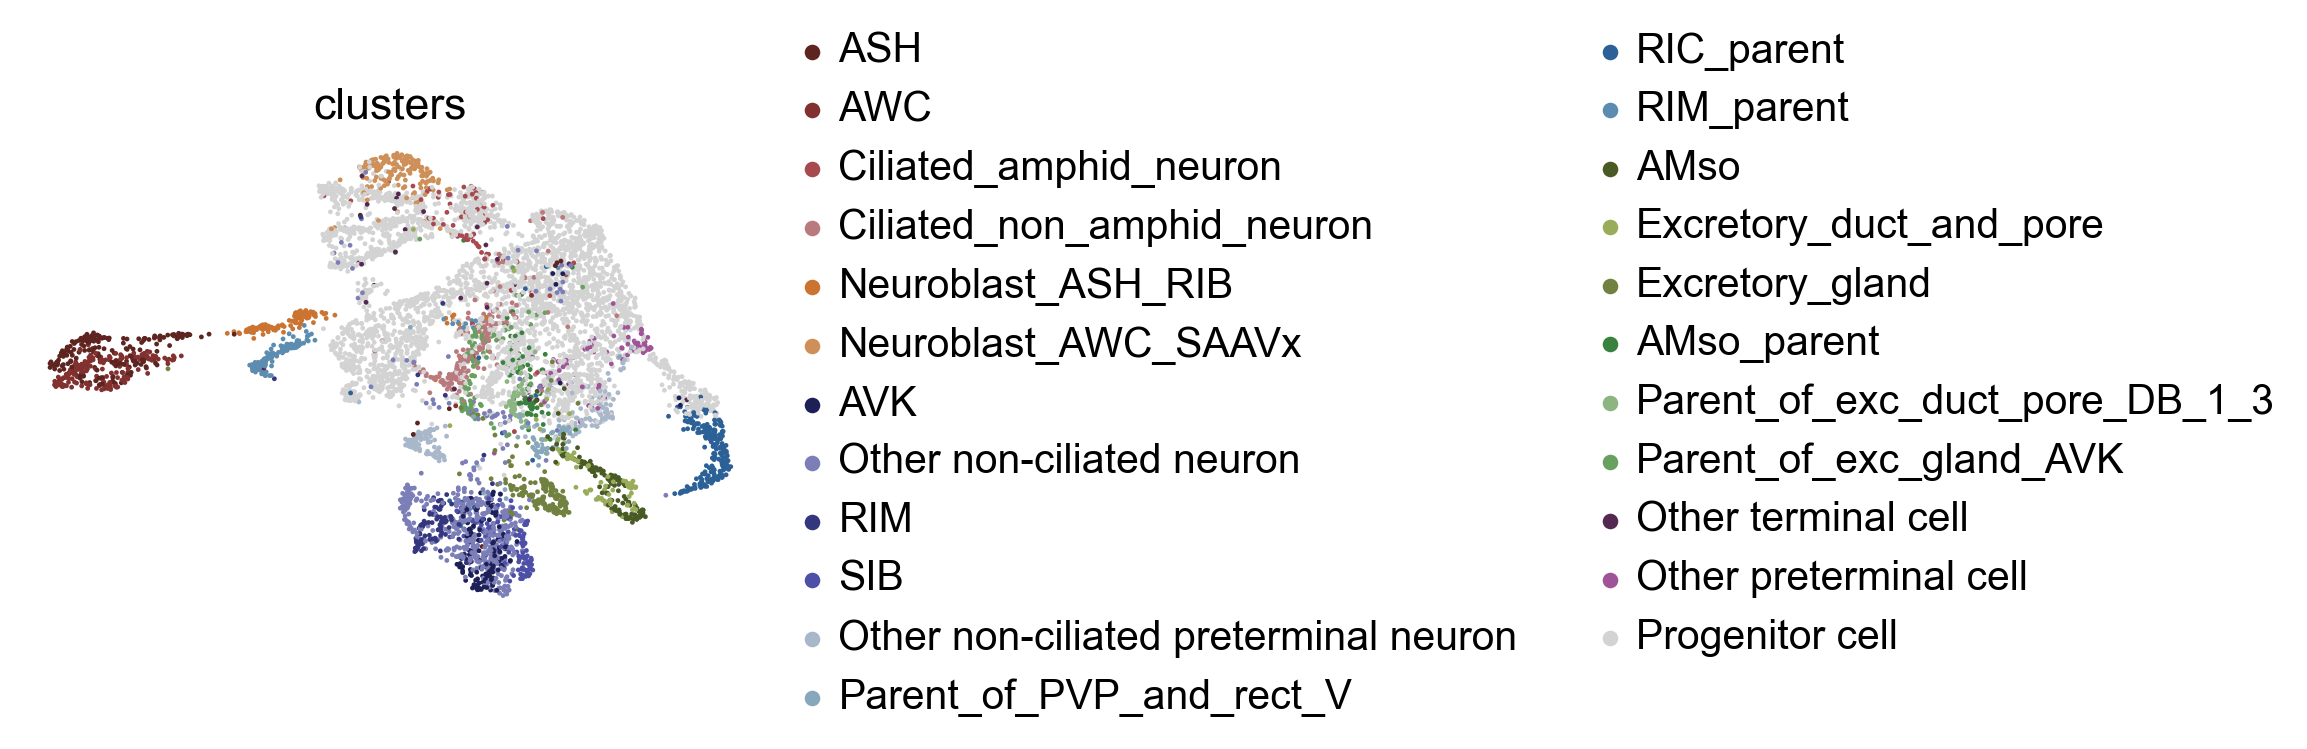

In [10]:
sc.pl.embedding(adata, basis="umap", color="clusters")

## CellRank 2 analysis

### Initialize a kernel

Compute a k-NN graph

In [11]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=30, random_state=random_state)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Use the pre-computed couplings to get a Markov chain description of the system. 

In [12]:
# initialize from pre-computed couplings
rtk = RealTimeKernel(adata, time_key="time_point", couplings=tmats)

# combine with local connectivities
rtk.compute_transition_matrix(self_transitions="connectivities")

# combine wiht global connectivities
conn = ConnectivityKernel(adata).compute_transition_matrix()
kernel = 0.9 * rtk + 0.1 * conn

100%|██████████| 6/6 [00:00<00:00, 105.99time pair/s]


Somehow, this converts the categories to float. Let's change that back, and let's also make sure they are strings. 

In [13]:
cats = adata.obs["time_point"].cat.categories
if isinstance(cats[0], (int, float, complex, np.int64)):
    mapping = {cat: str(int(cat)) for cat in cats}
    adata.obs["time_point"] = adata.obs["time_point"].cat.rename_categories(mapping)

## Compute terminal states

In [14]:
g = GPCCA(kernel)

[bs-mbpas-0057:34736] shmem: mmap: an error occurred while determining whether or not /var/folders/j6/fcqzqhwj6y7b1nzw3241zgjw0000gr/T//ompi.bs-mbpas-0057.504/jf.0/2206138368/sm_segment.bs-mbpas-0057.504.837f0000.0 could be created.


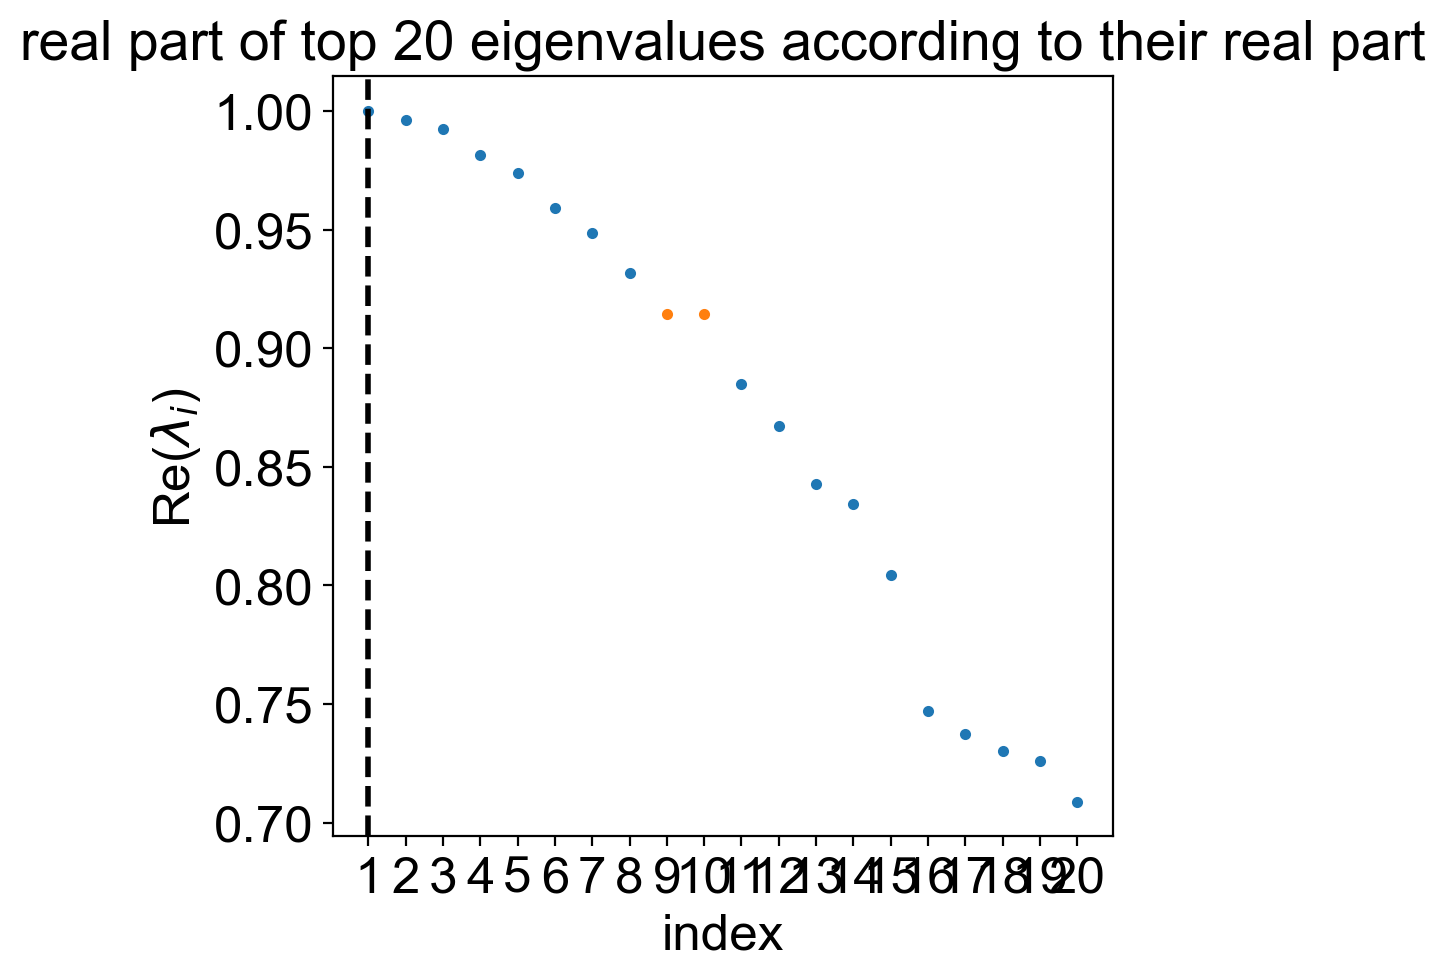

In [15]:
g.compute_schur()
g.plot_spectrum(real_only=True)

### Loop over a range of terminal states

saving figure to file /Users/mlange/Projects/moslin_analysis_3/figures/packer_c_elegans/terminal_state_robustness/macrostates_n_states_5.pdf


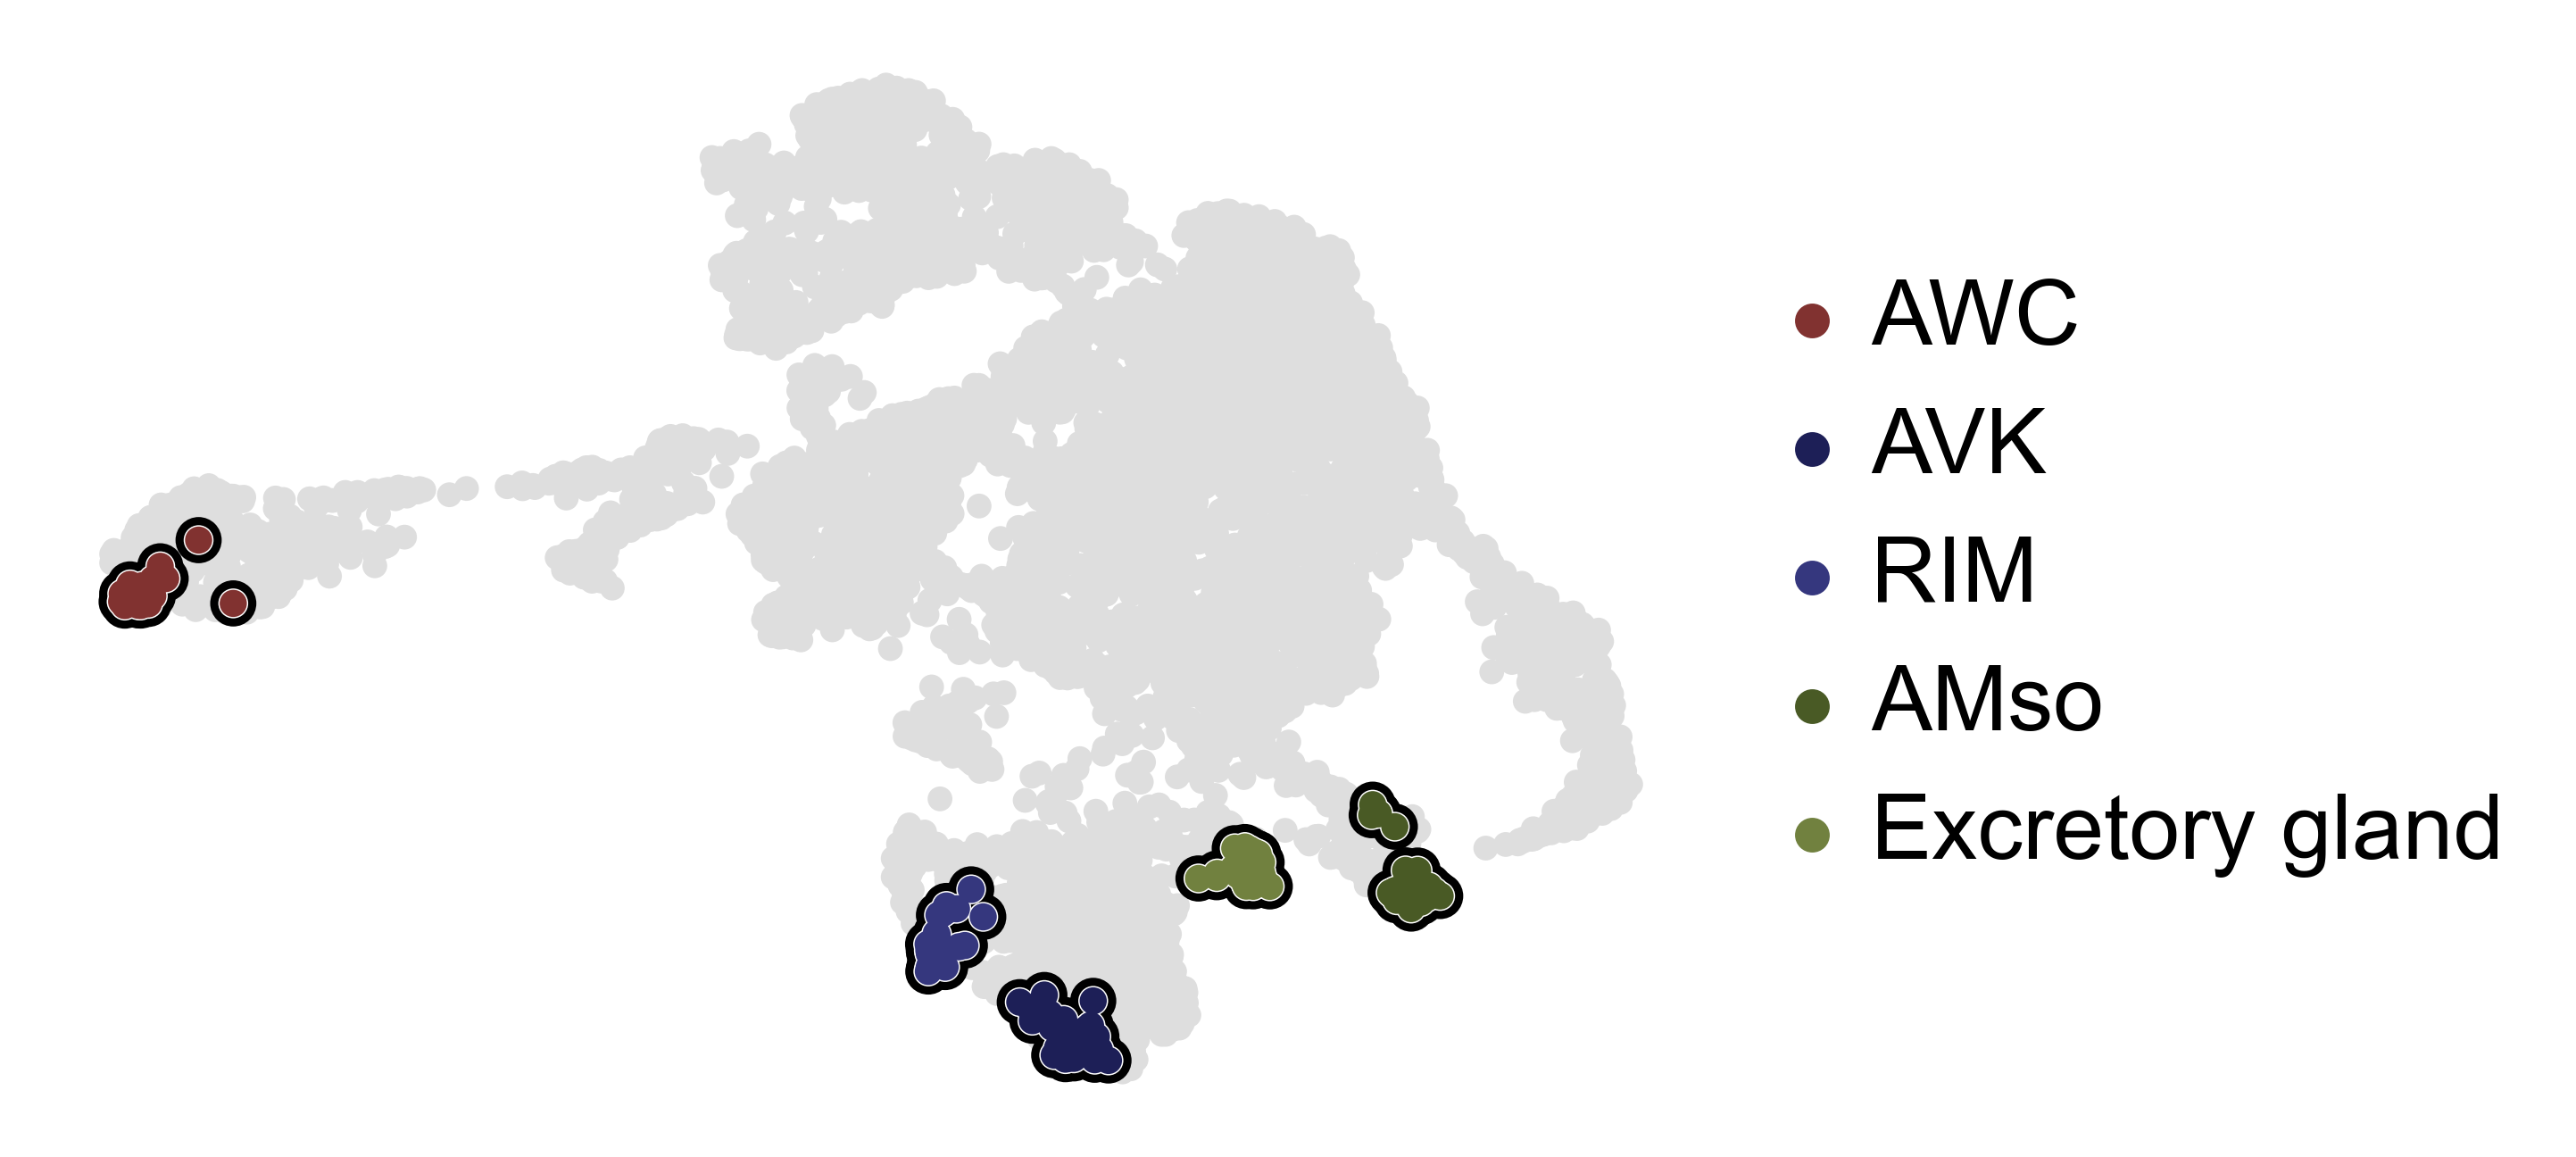

100%|██████████| 3/3 [00:01<00:00,  1.71/s]


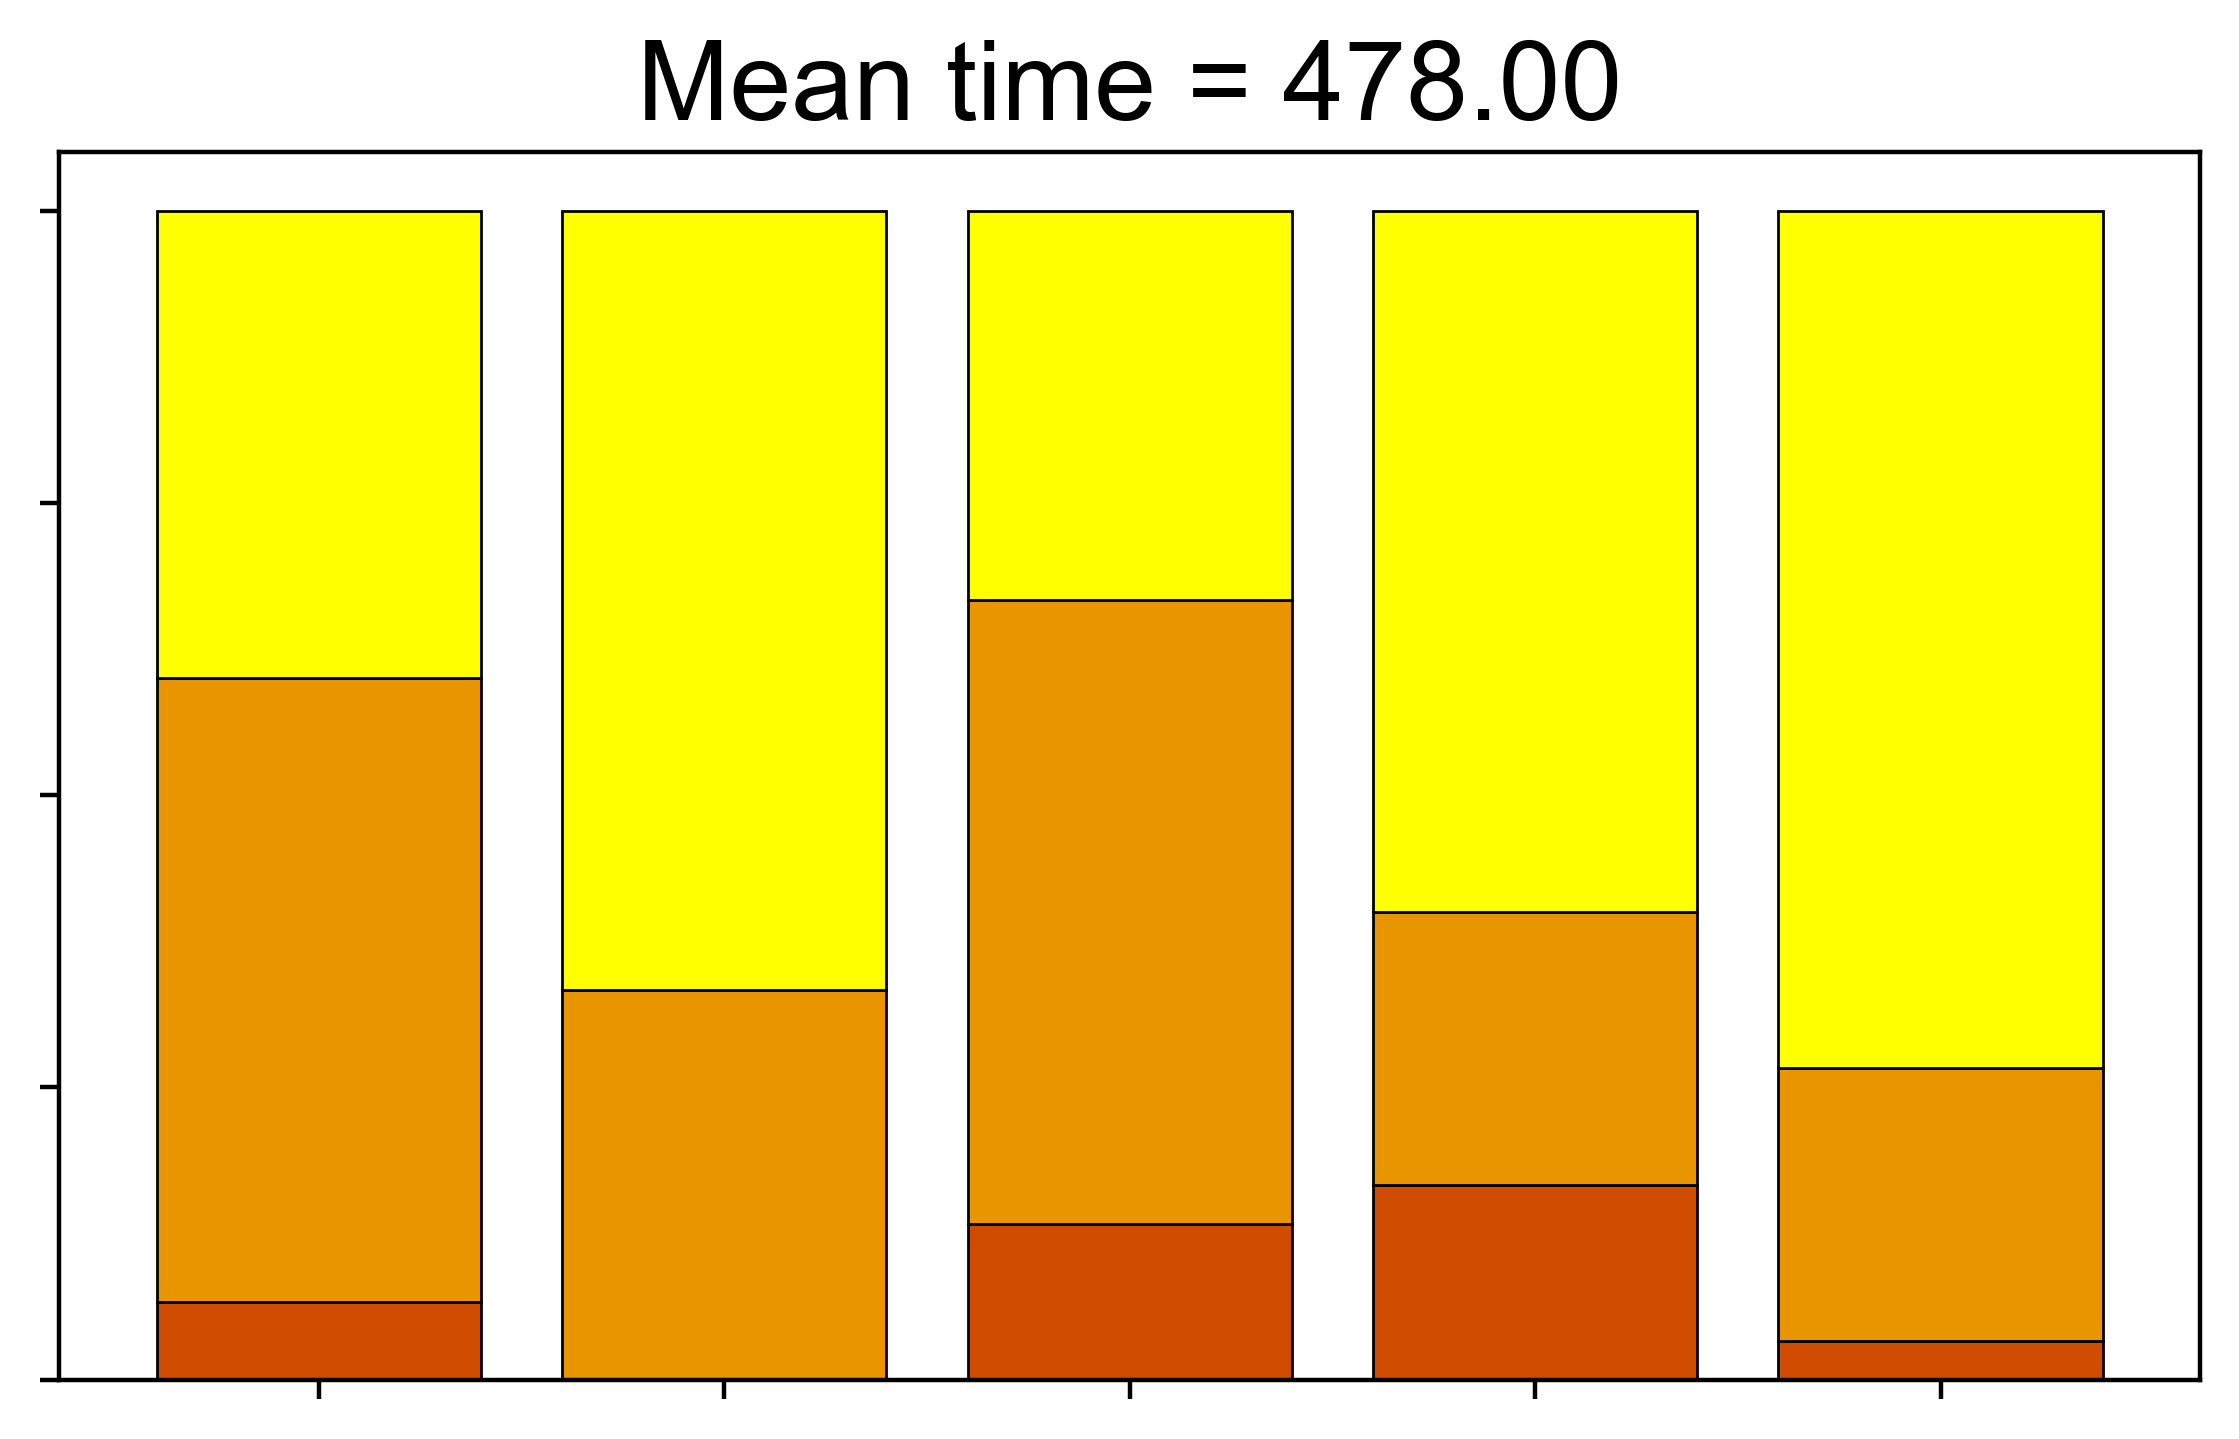

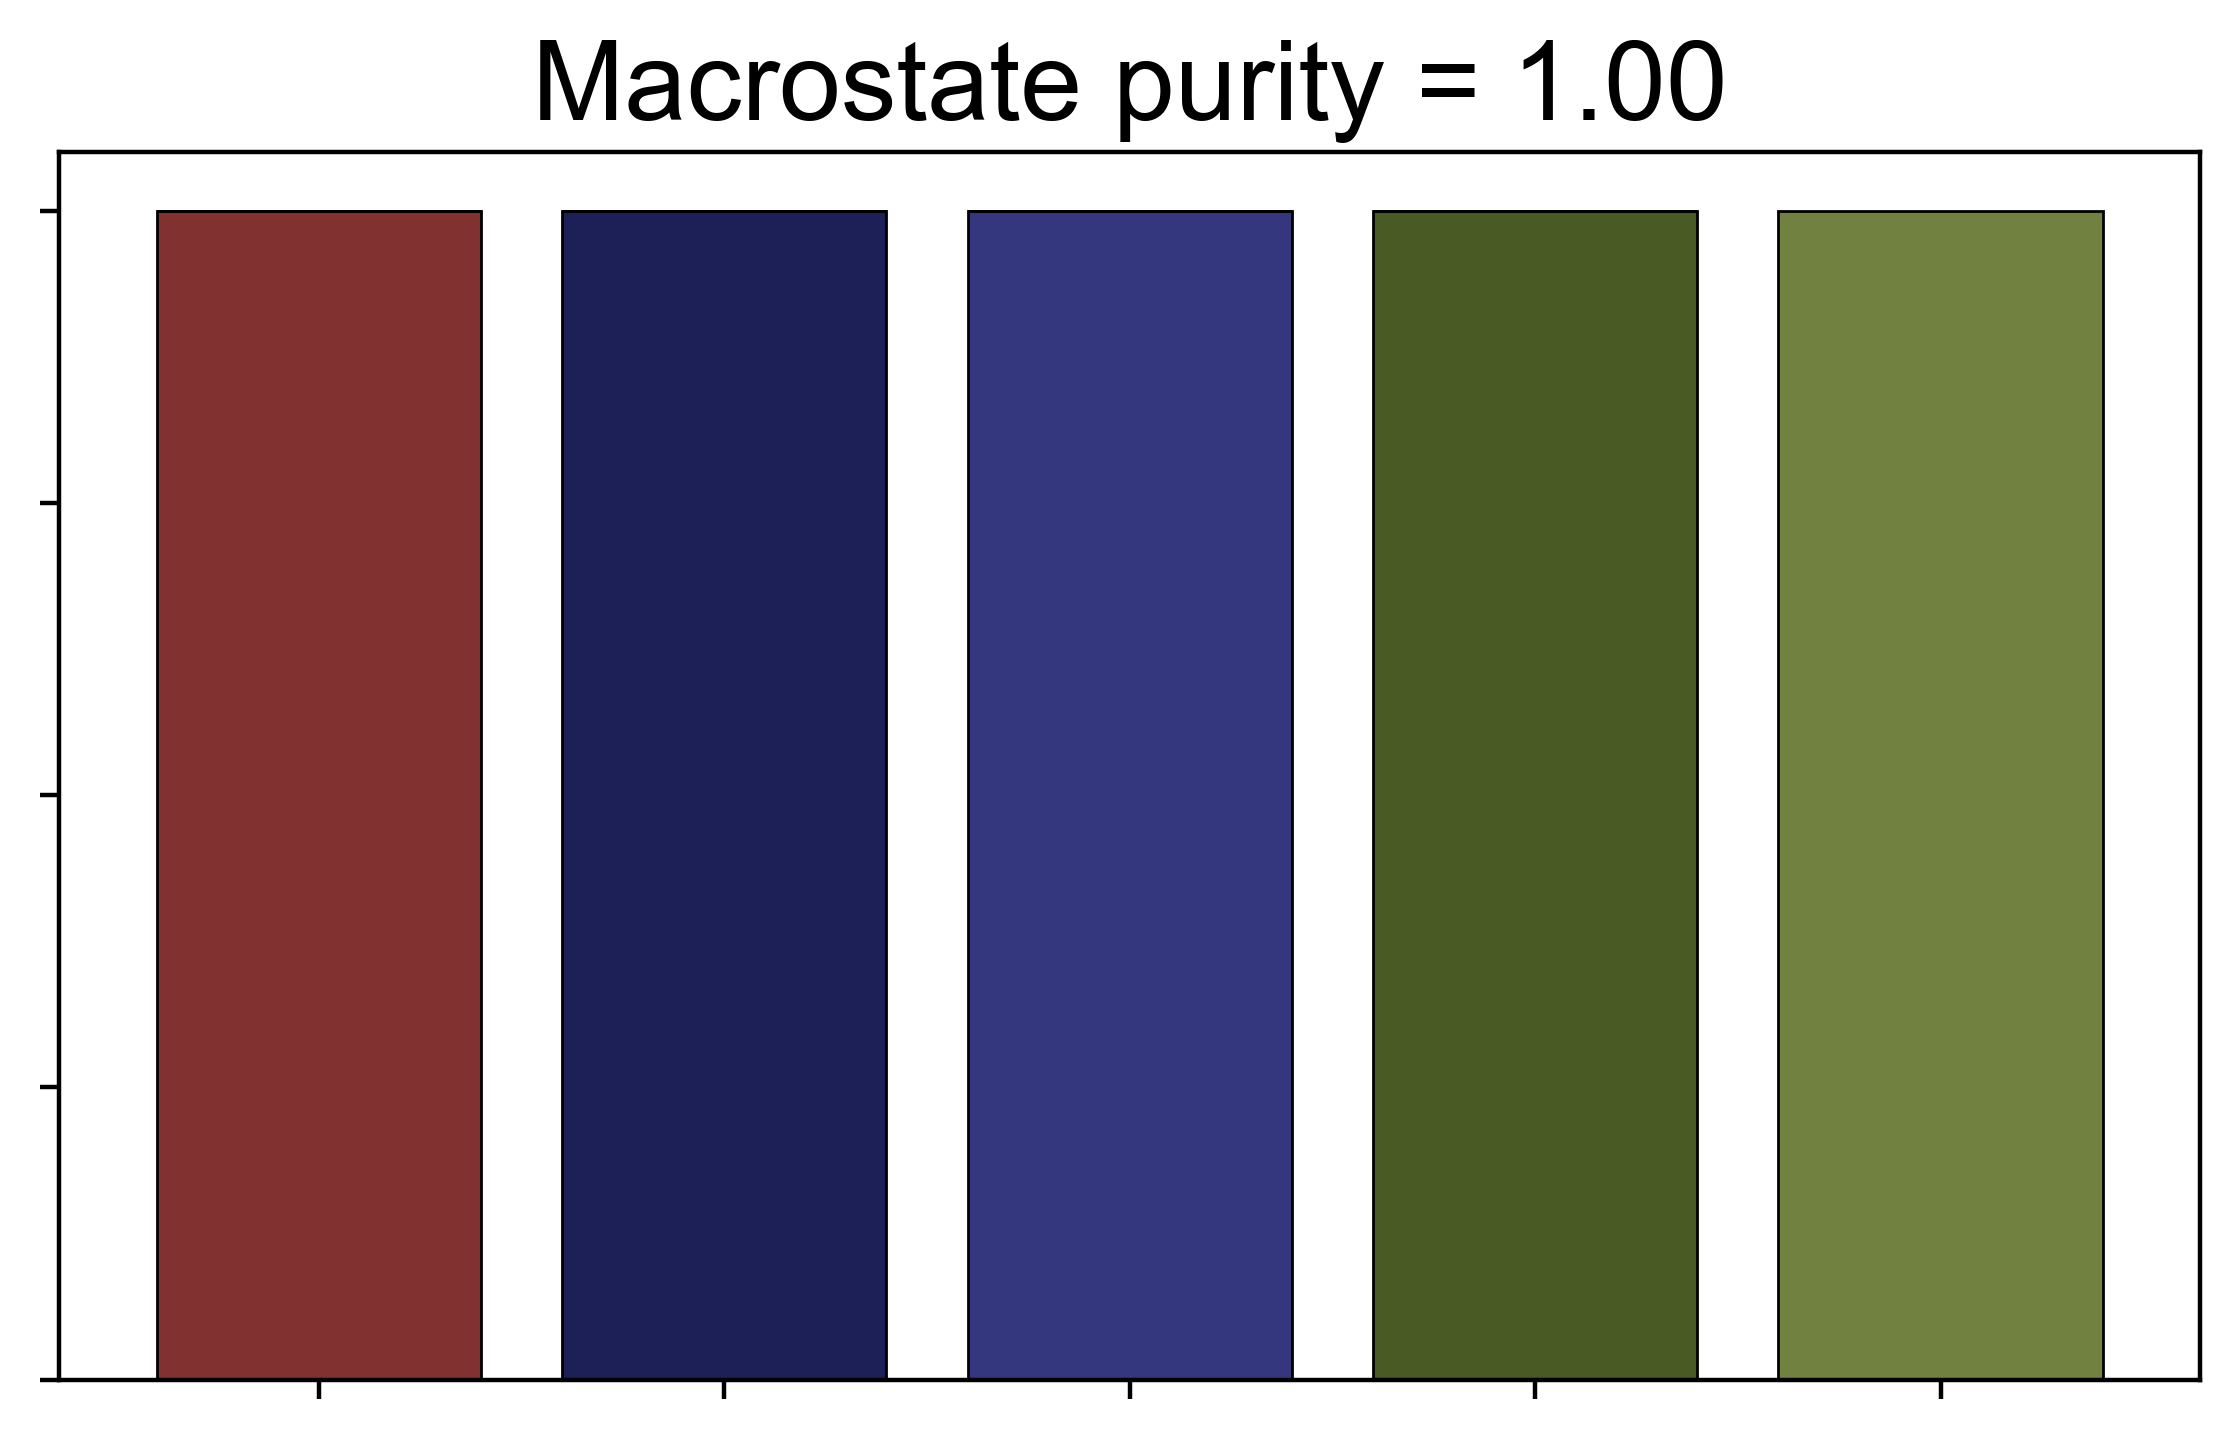

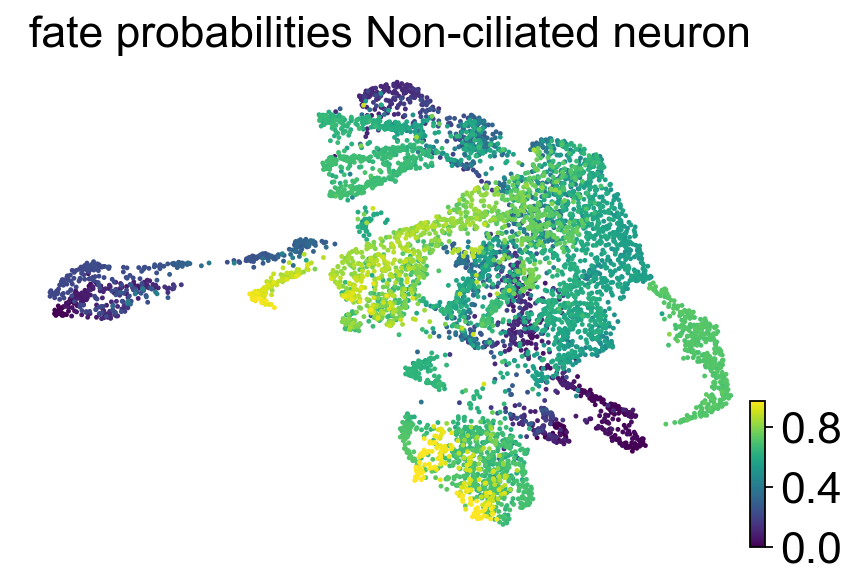

saving figure to file /Users/mlange/Projects/moslin_analysis_3/figures/packer_c_elegans/terminal_state_robustness/macrostates_n_states_6.pdf


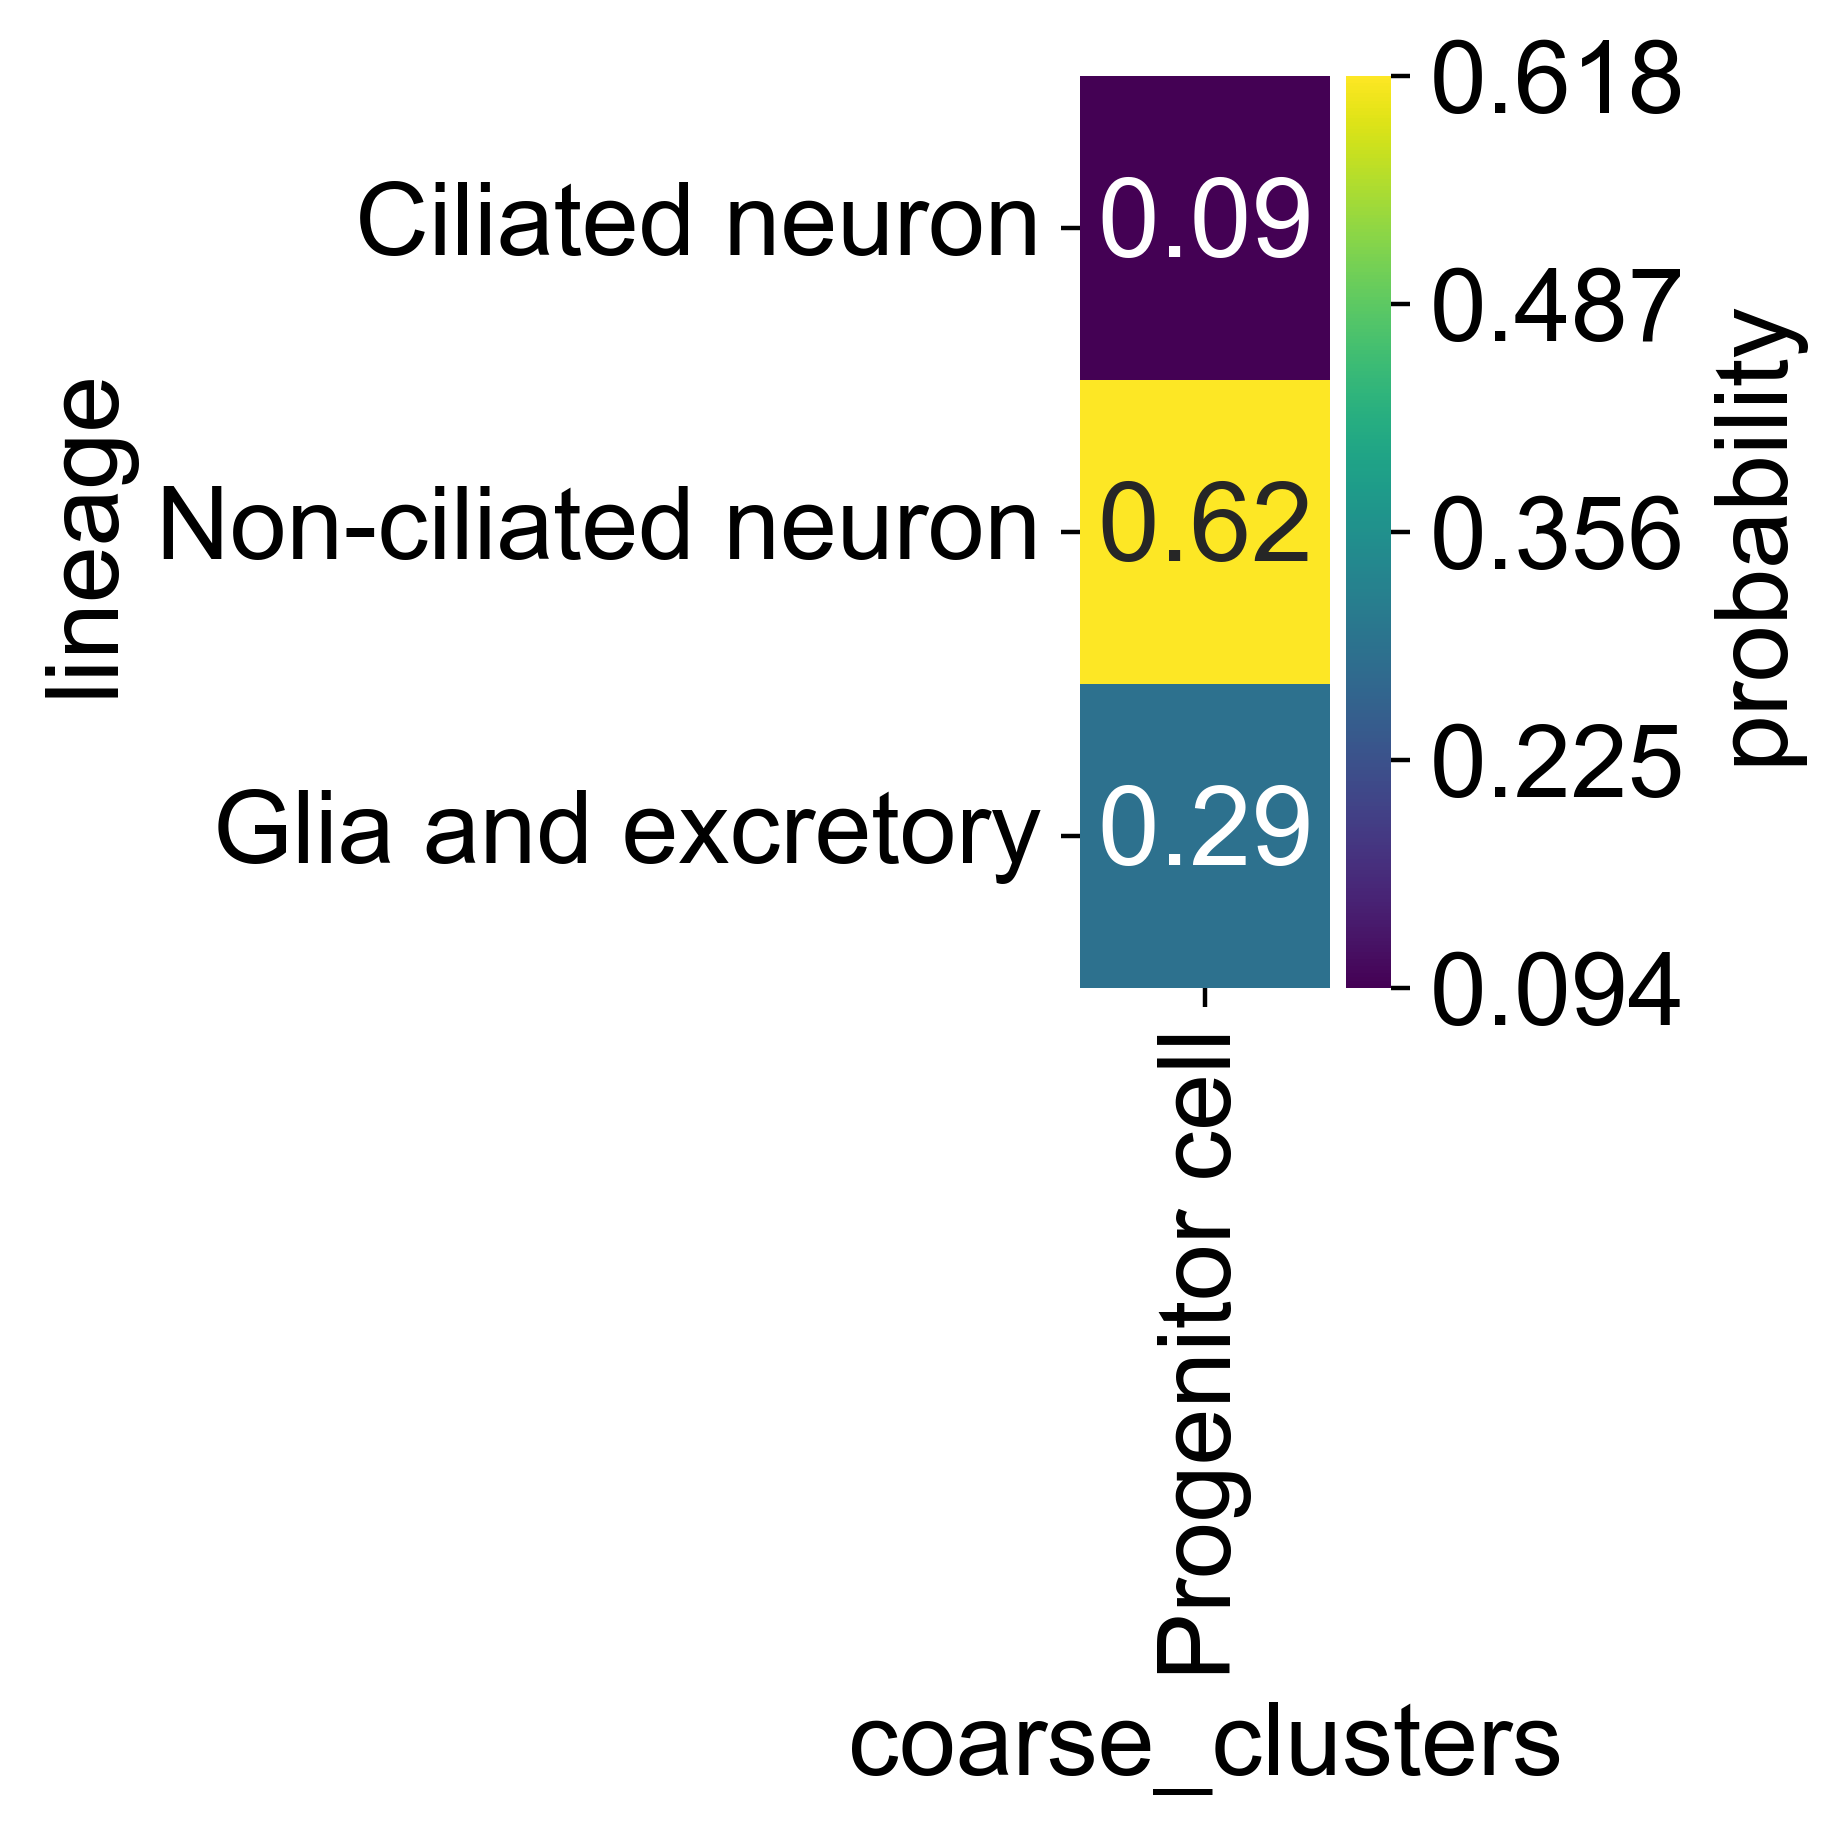

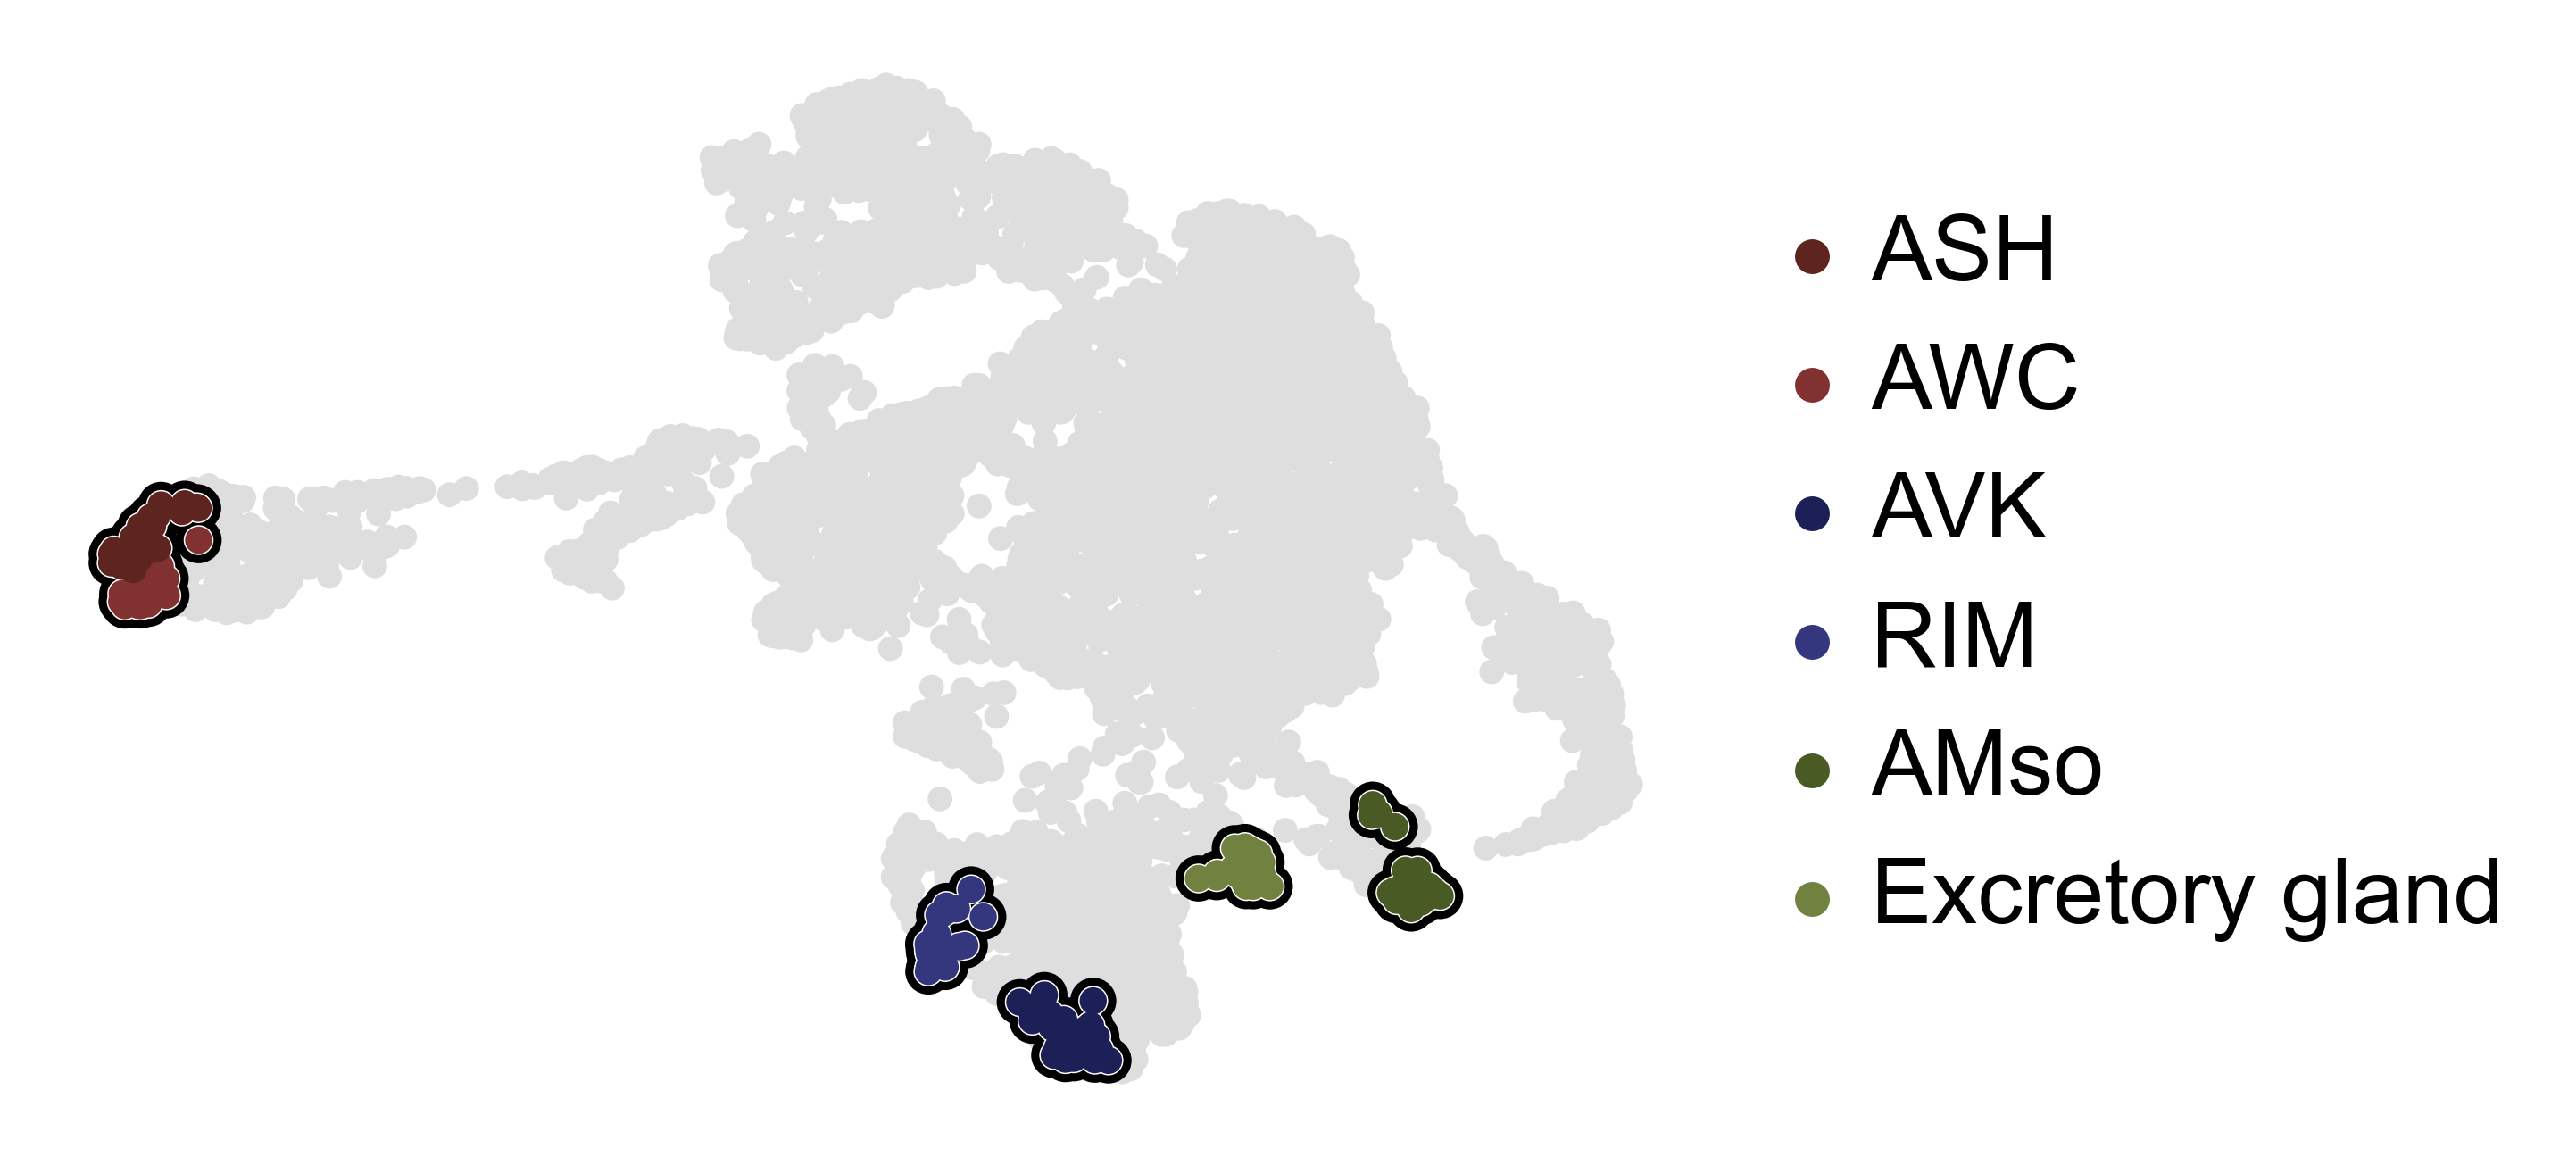

100%|██████████| 3/3 [00:01<00:00,  1.78/s]


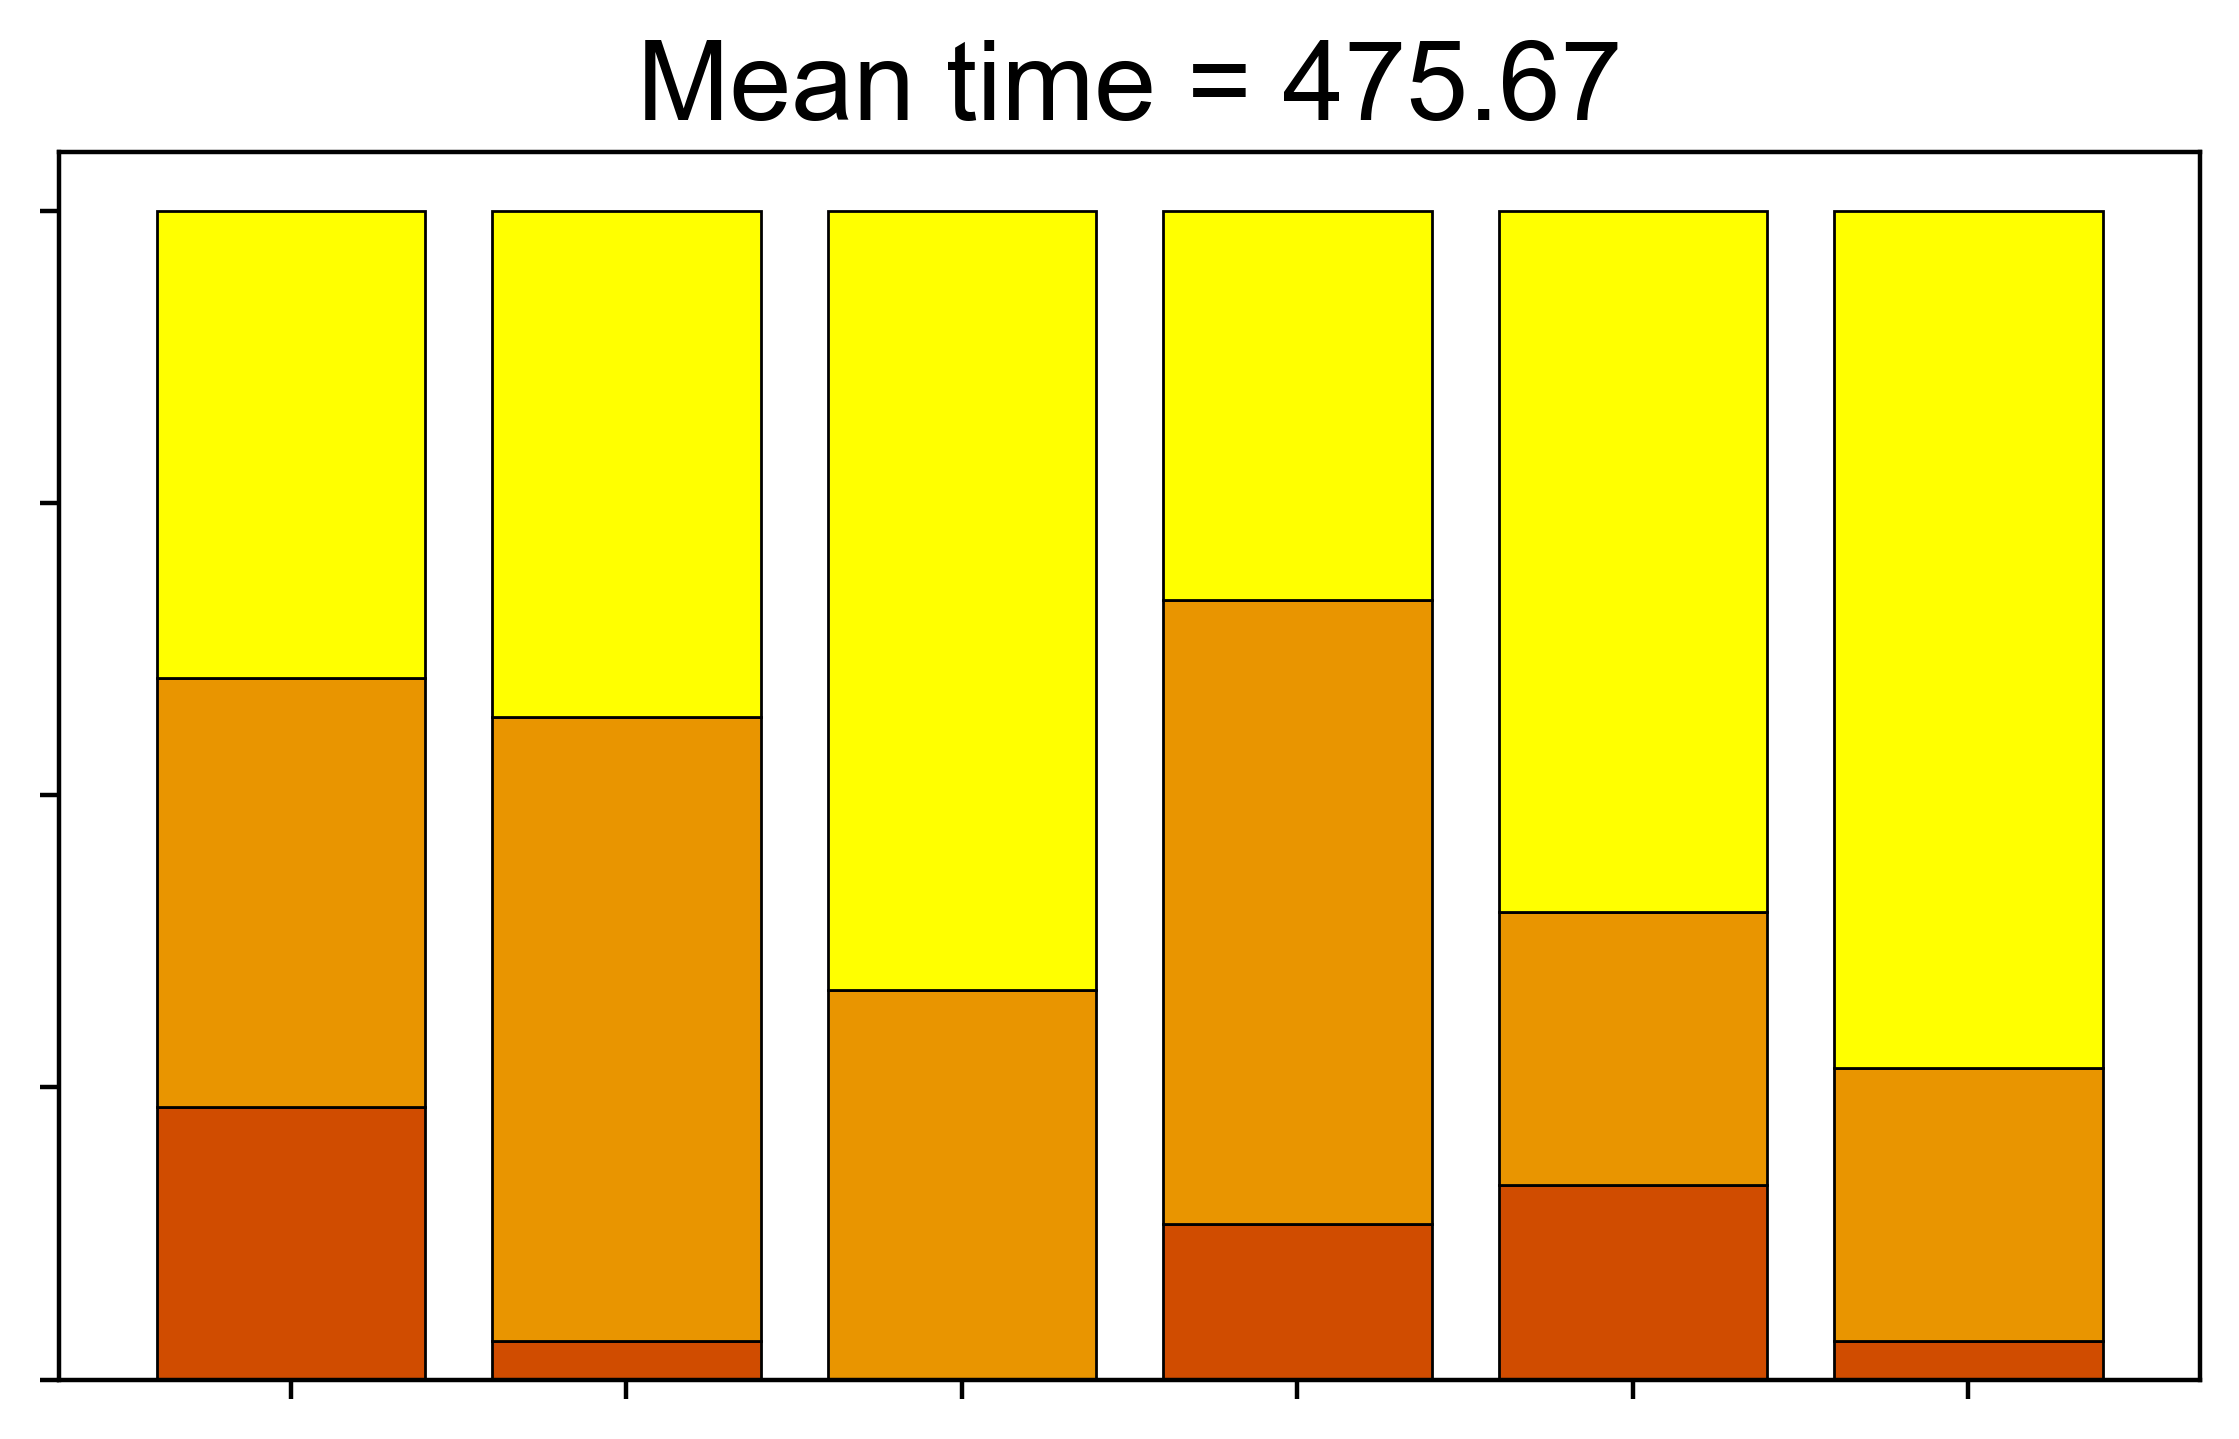

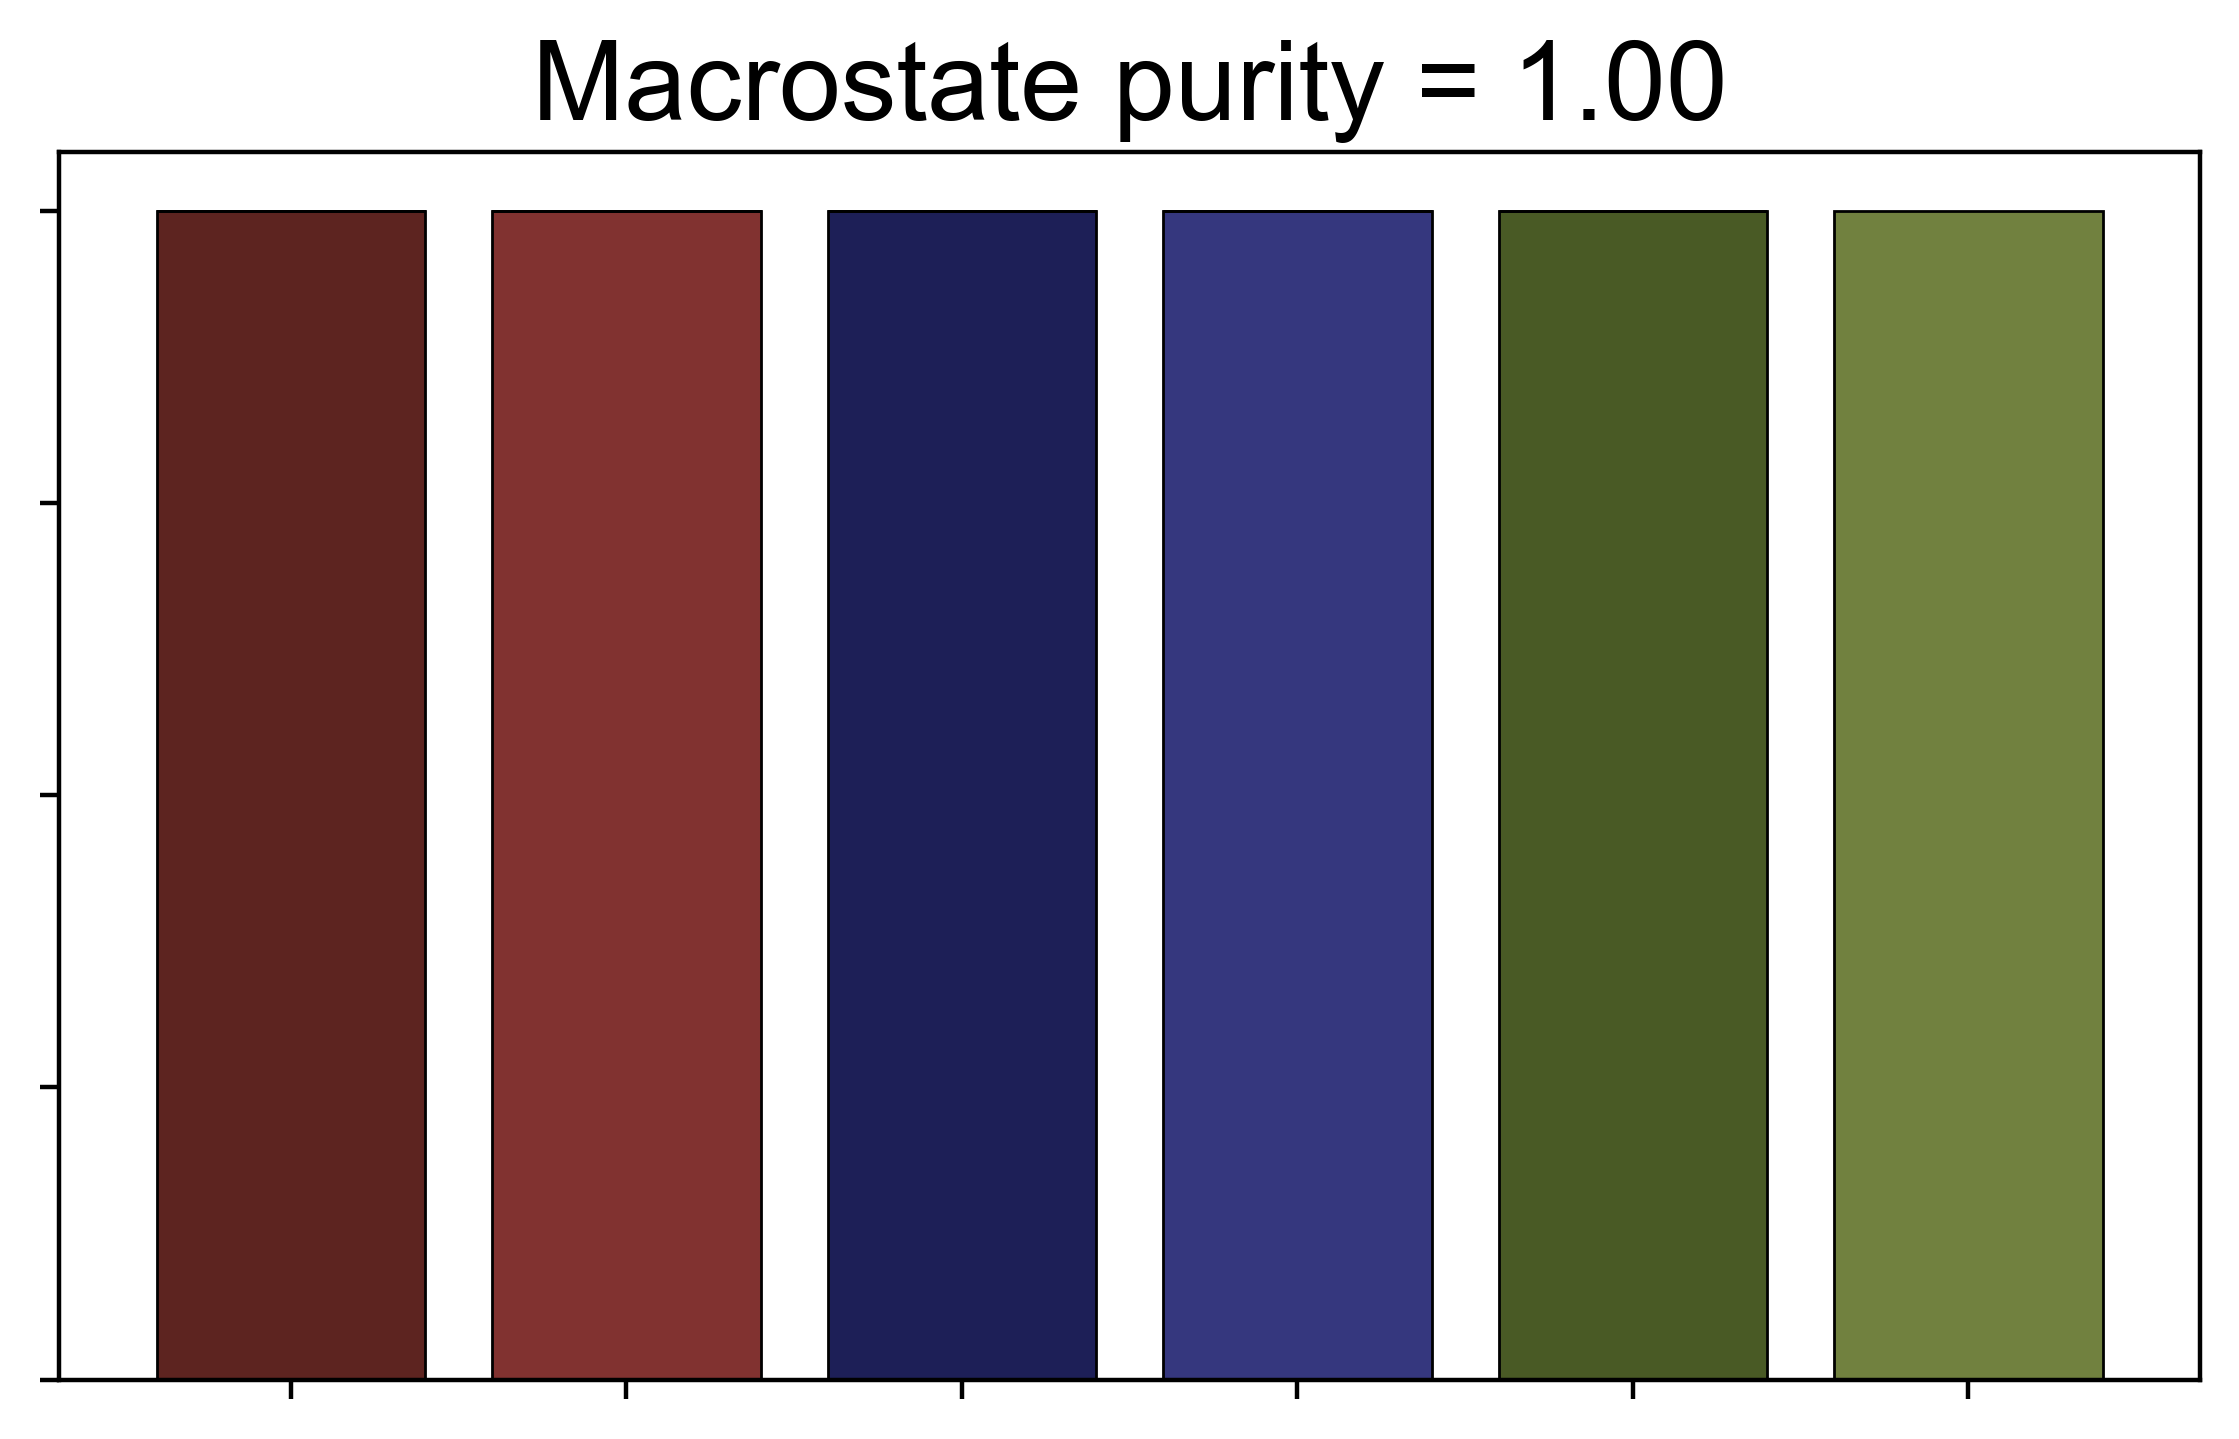

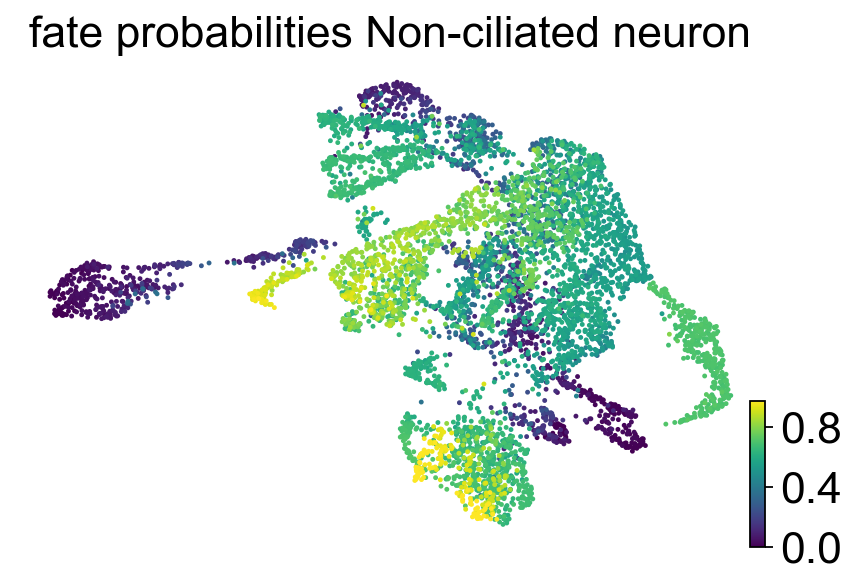

saving figure to file /Users/mlange/Projects/moslin_analysis_3/figures/packer_c_elegans/terminal_state_robustness/macrostates_n_states_7.pdf


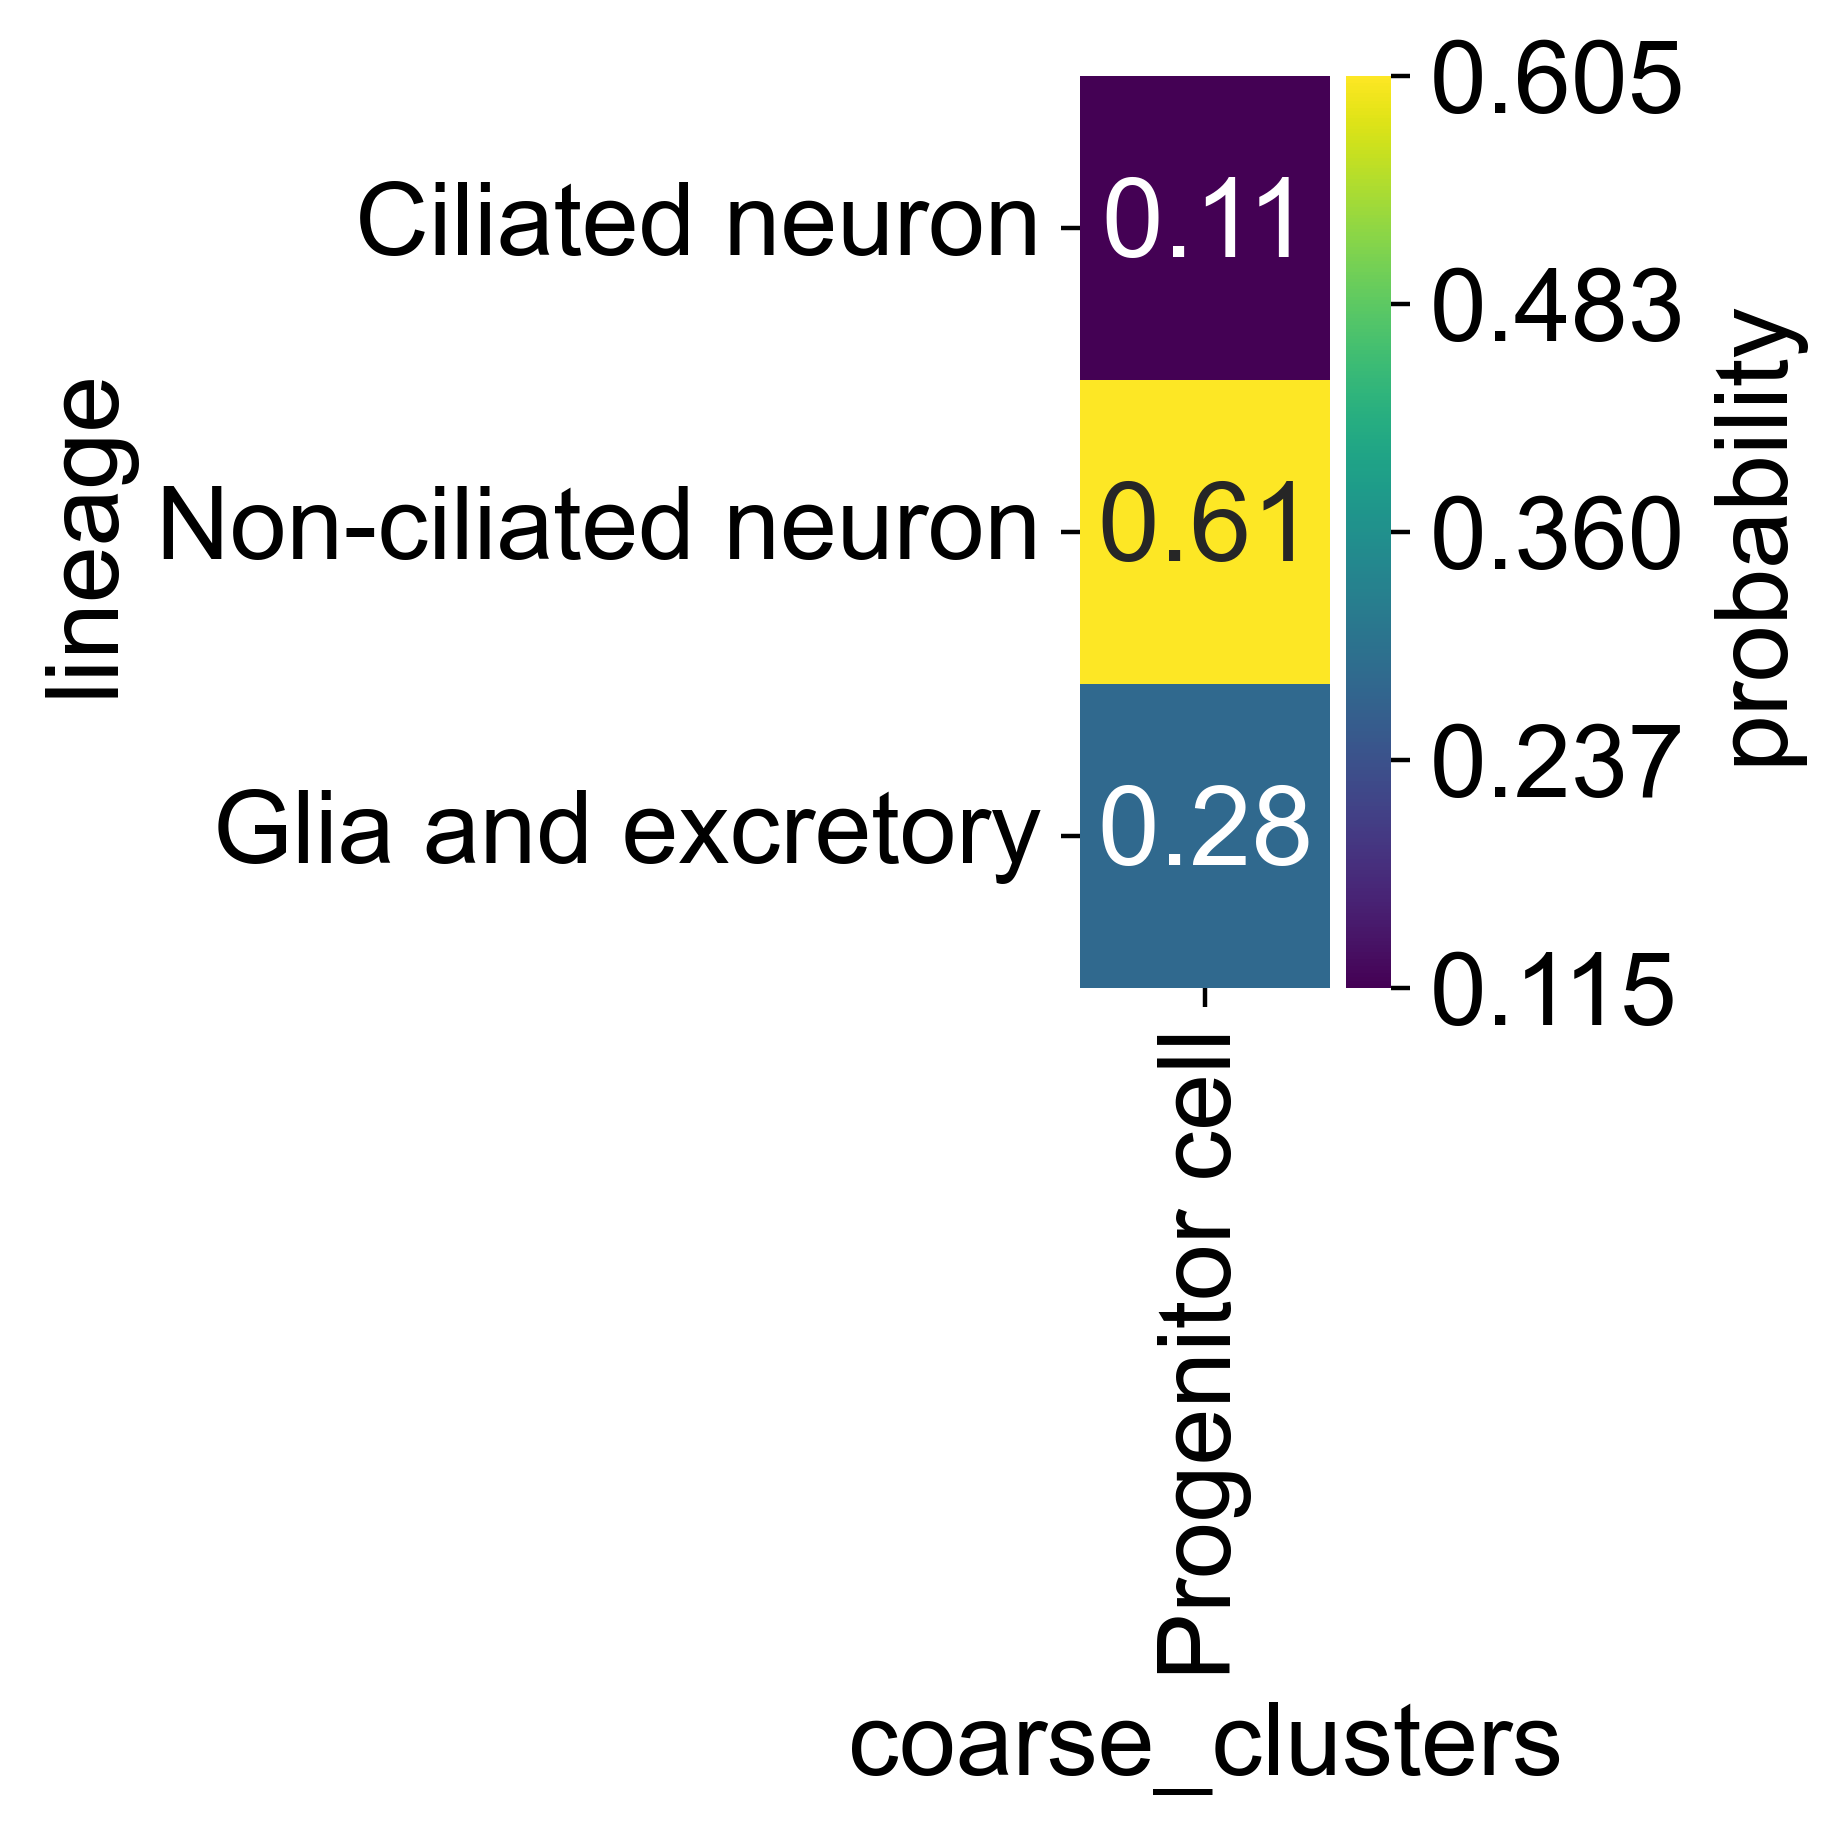

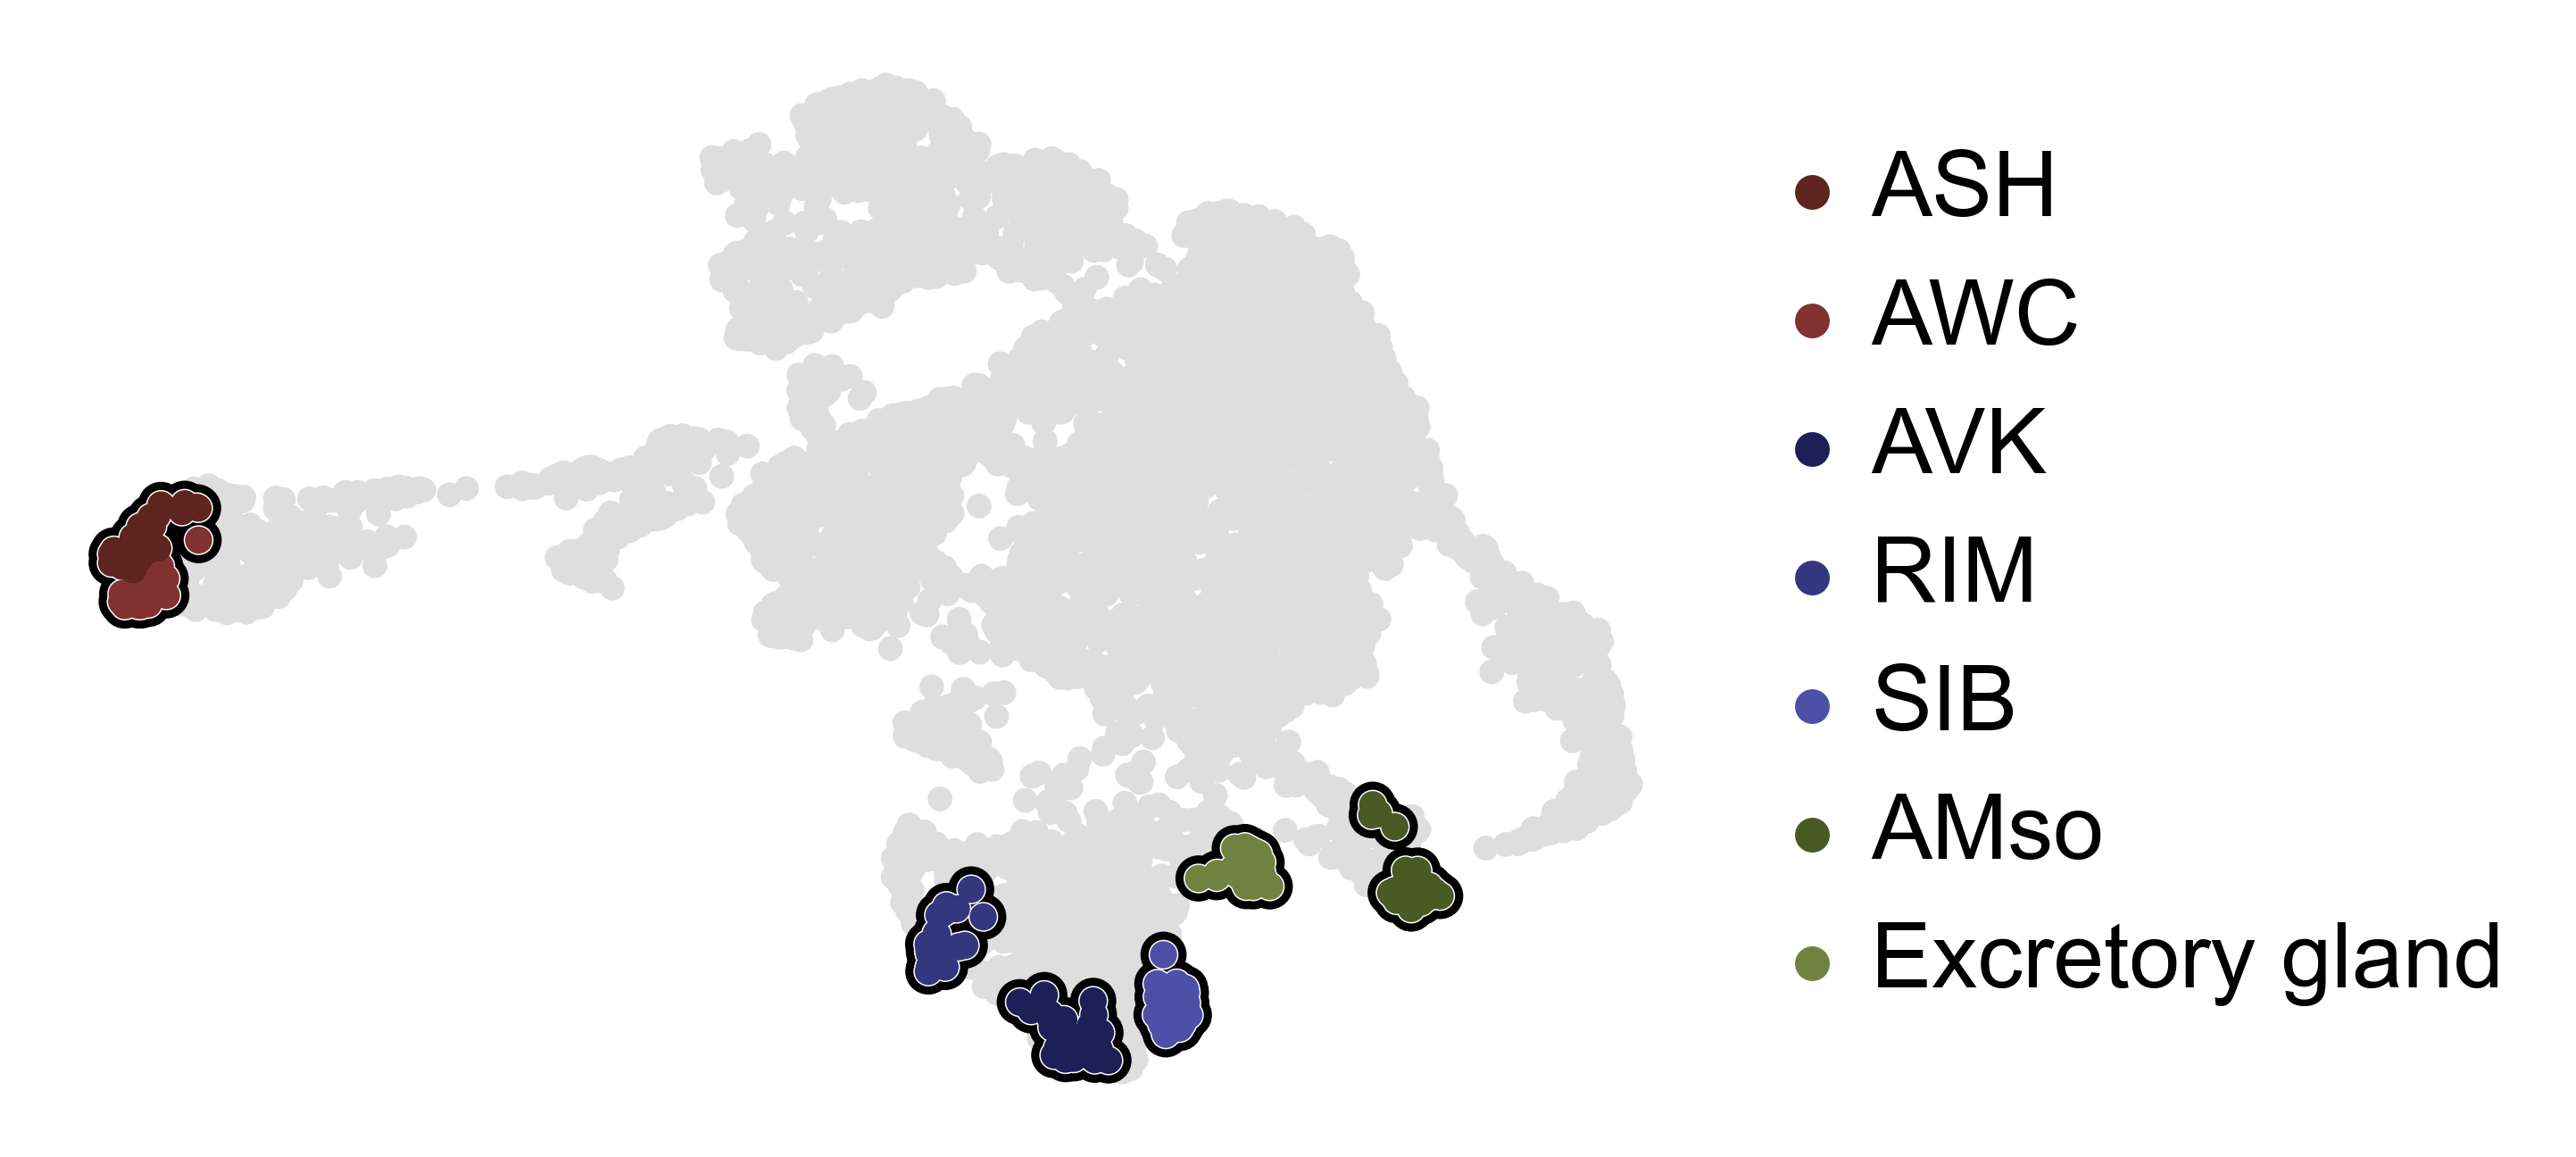

100%|██████████| 3/3 [00:01<00:00,  1.83/s]


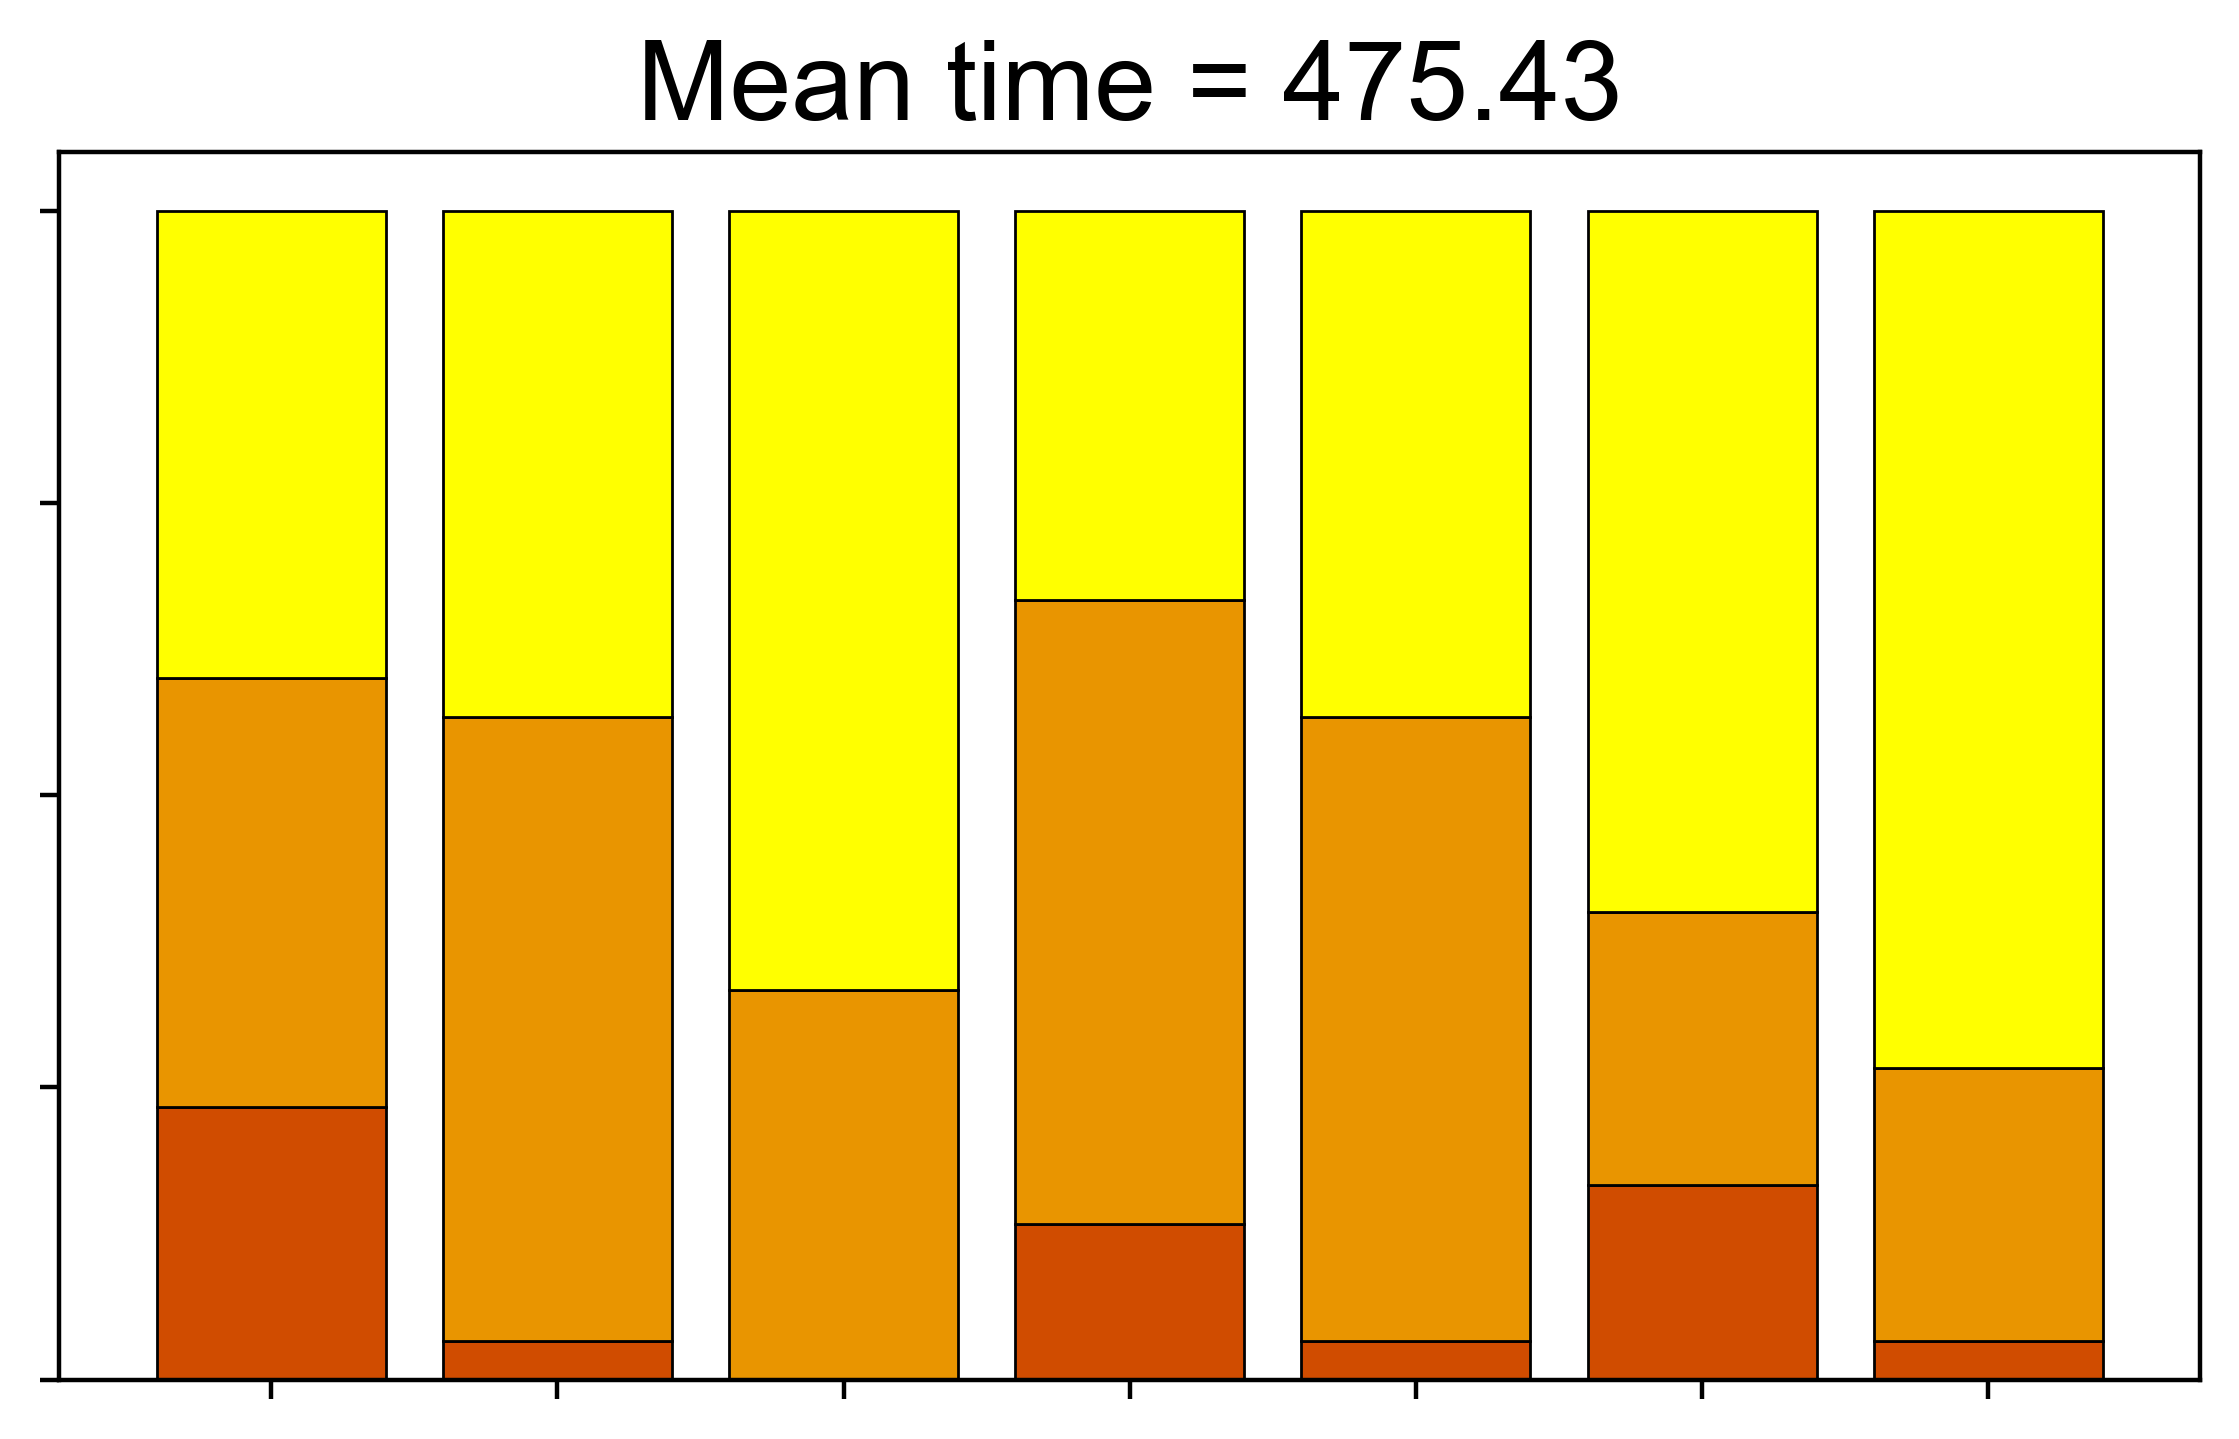

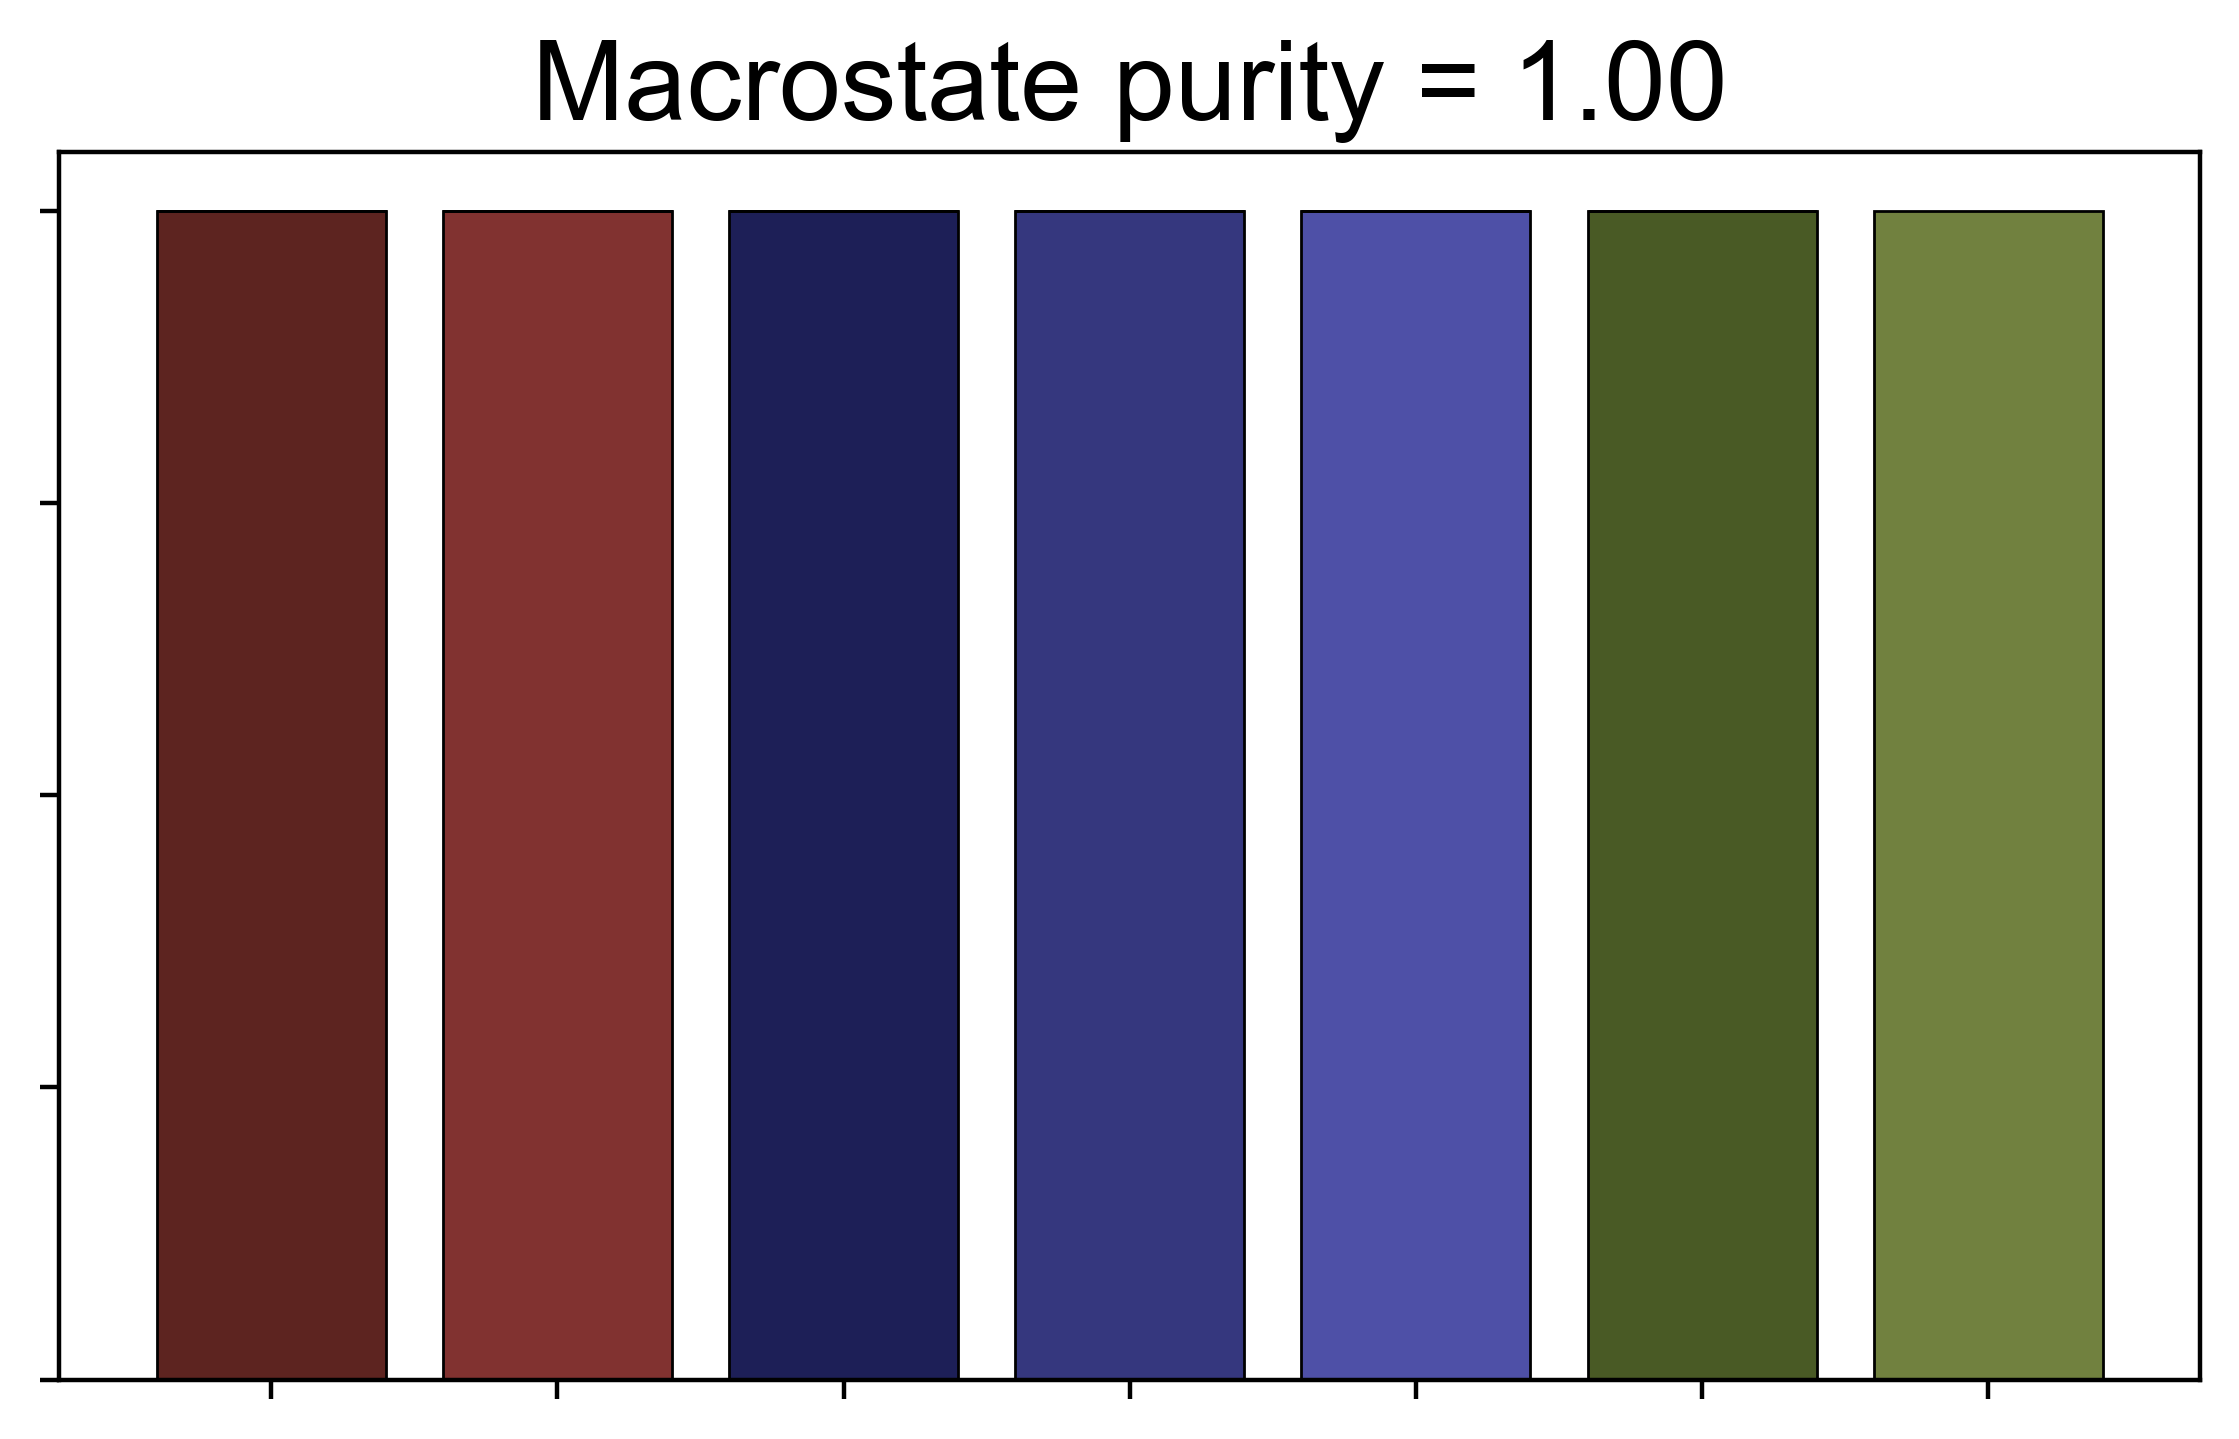

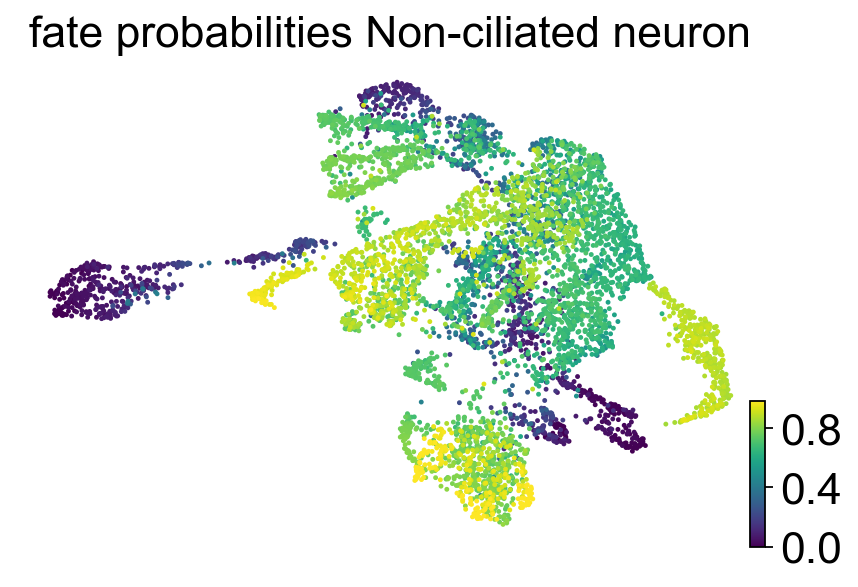

saving figure to file /Users/mlange/Projects/moslin_analysis_3/figures/packer_c_elegans/terminal_state_robustness/macrostates_n_states_8.pdf


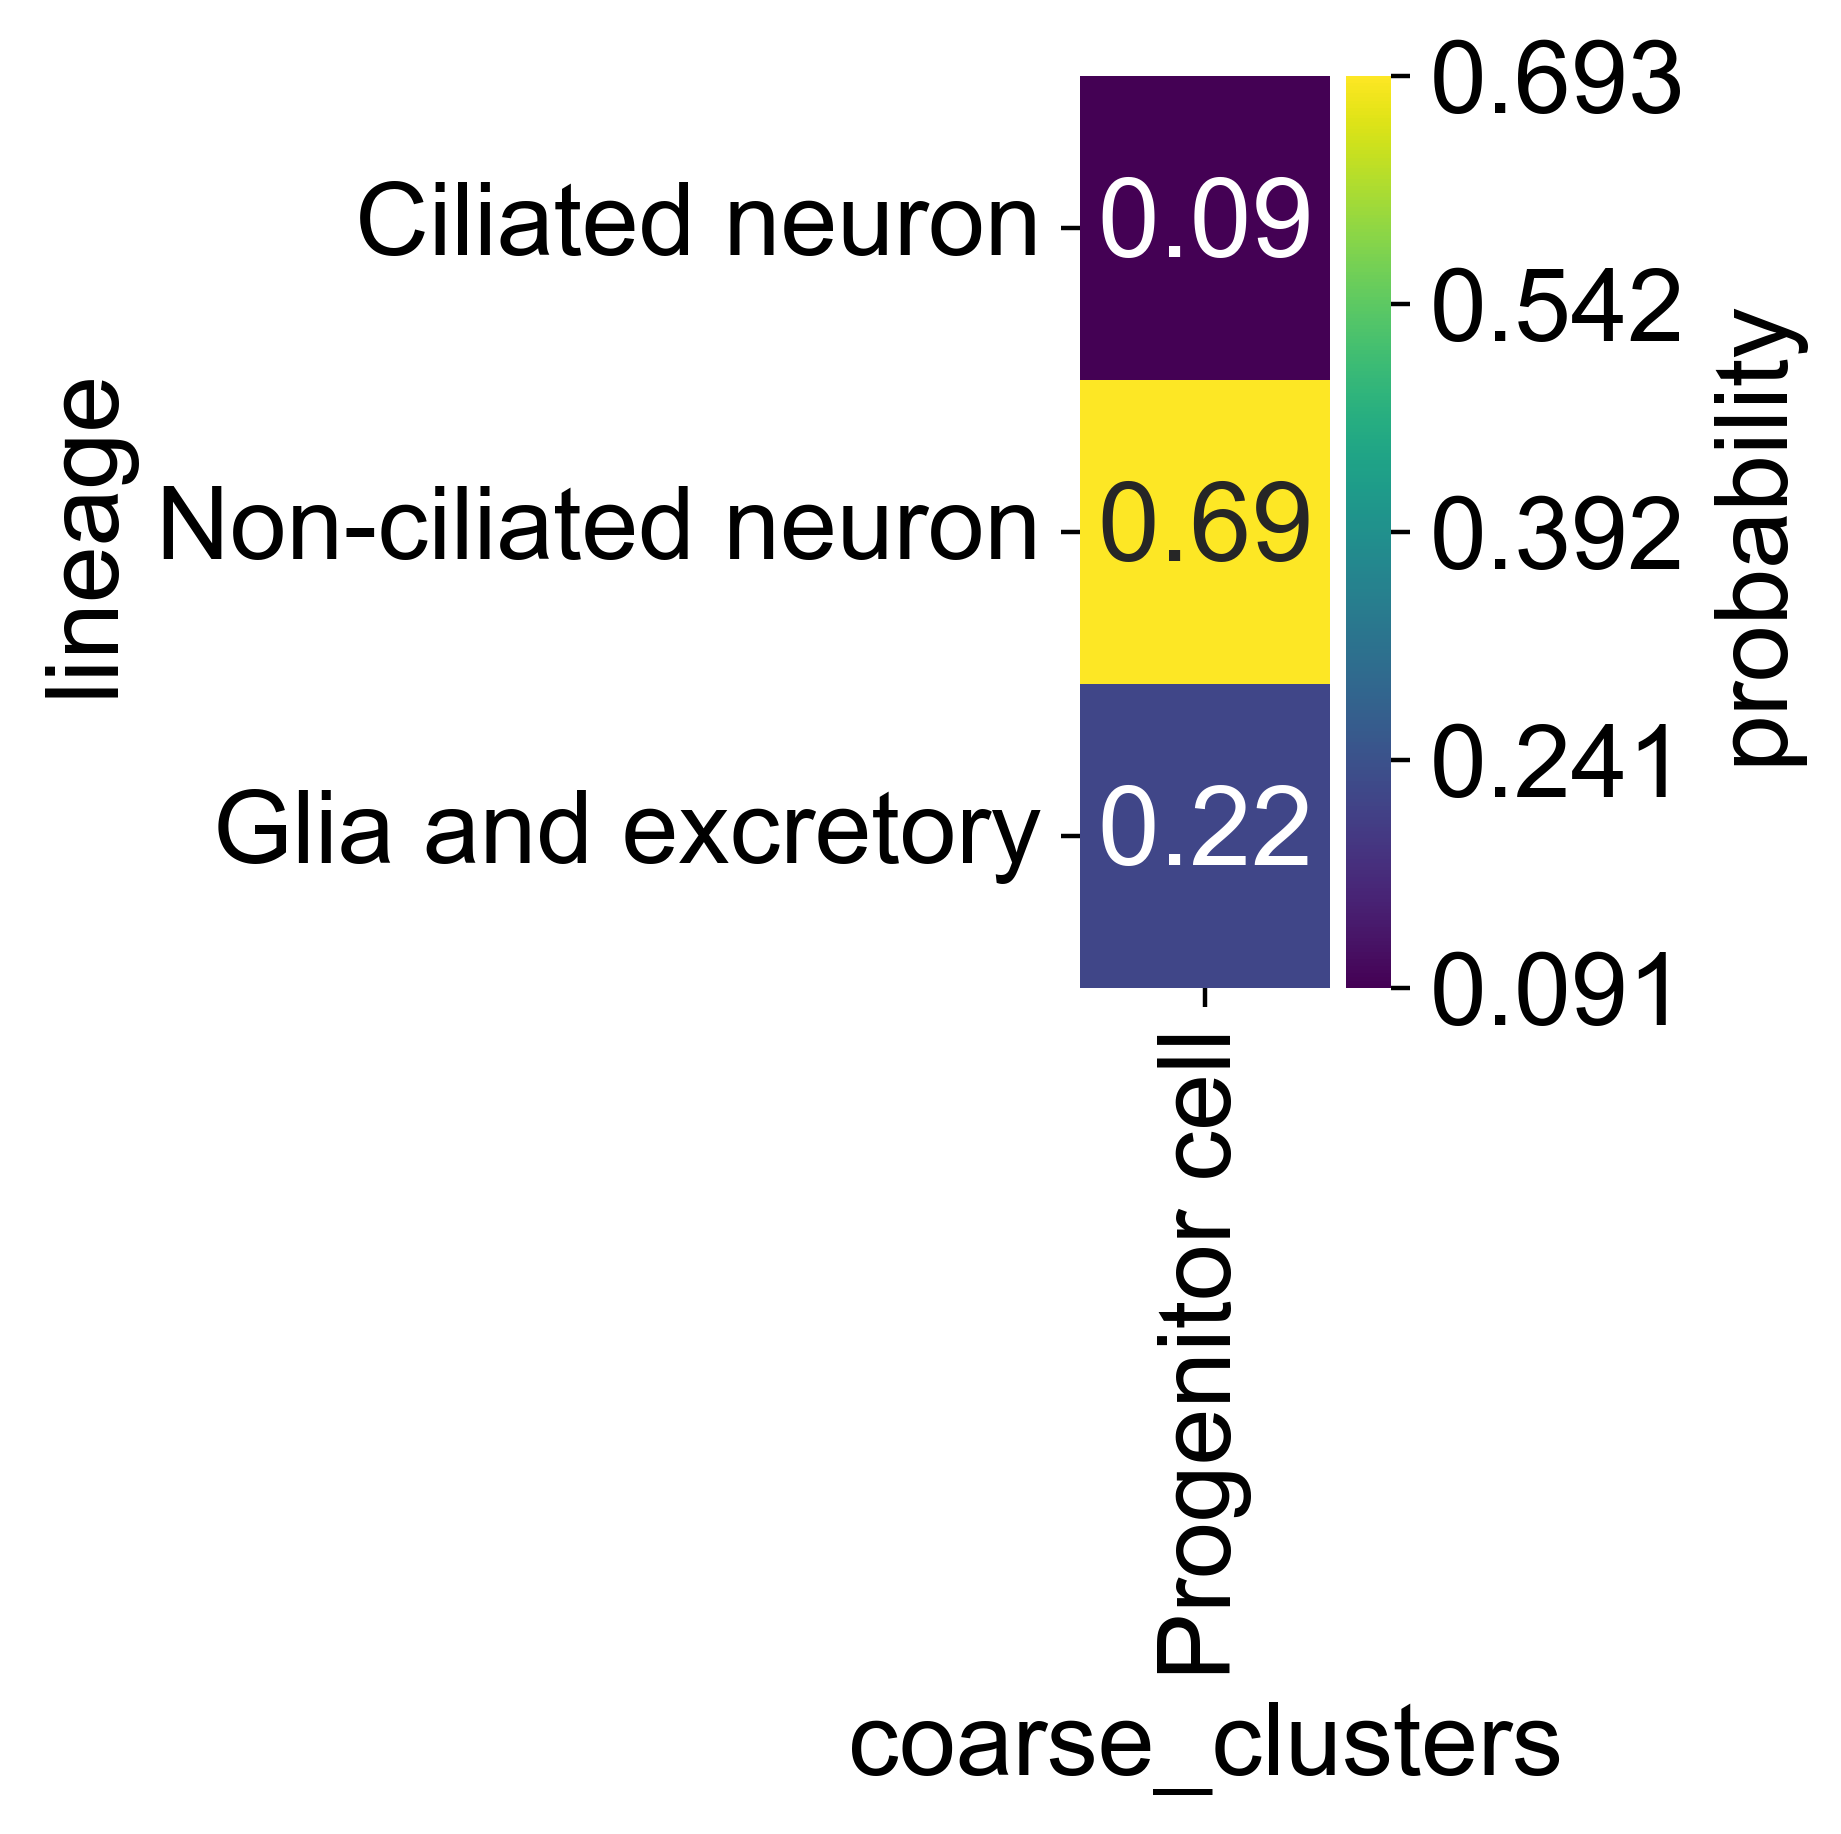

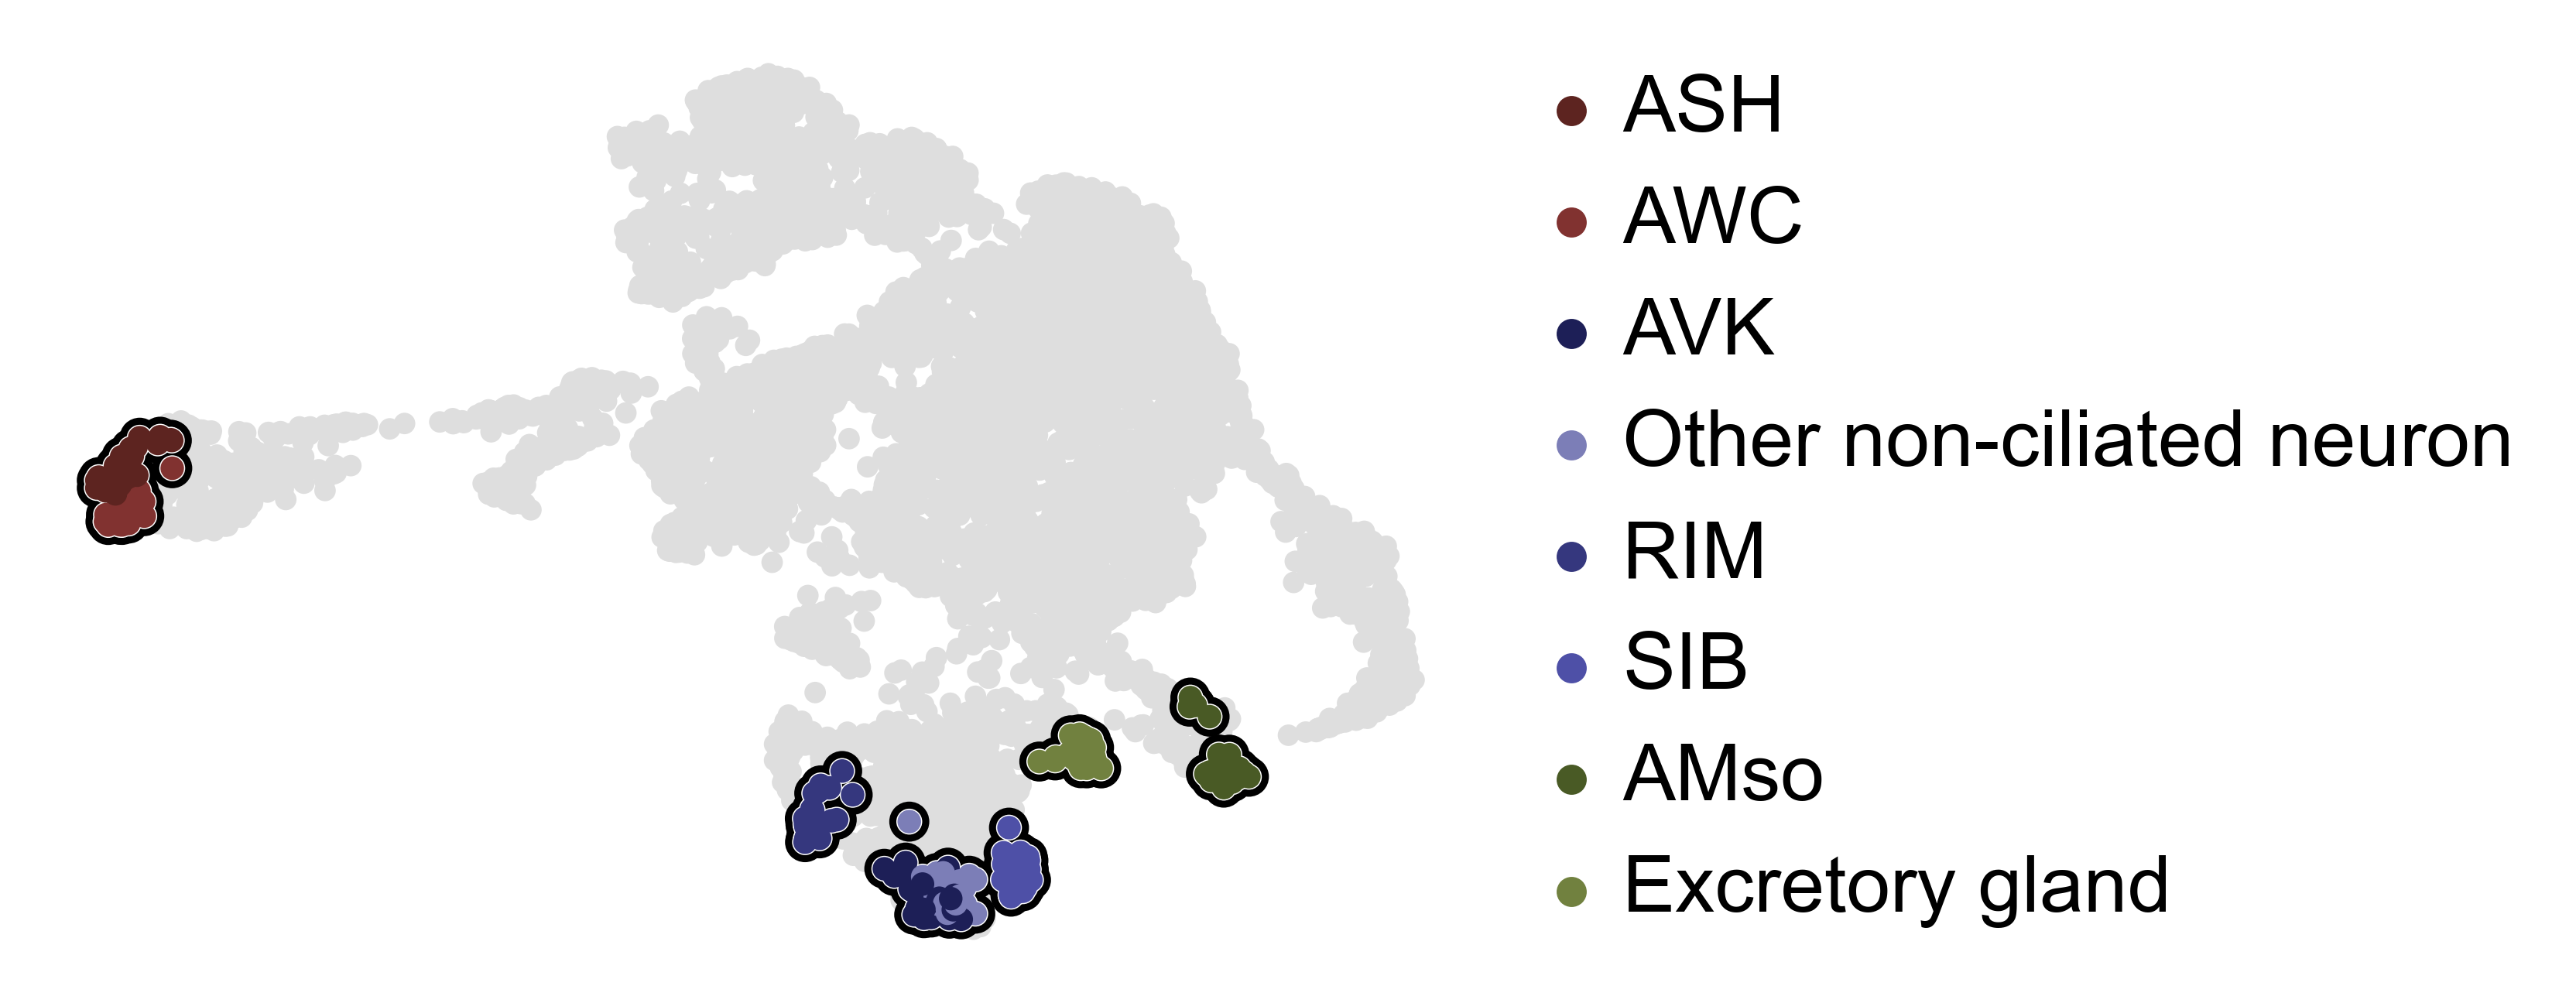

100%|██████████| 3/3 [00:01<00:00,  1.80/s]


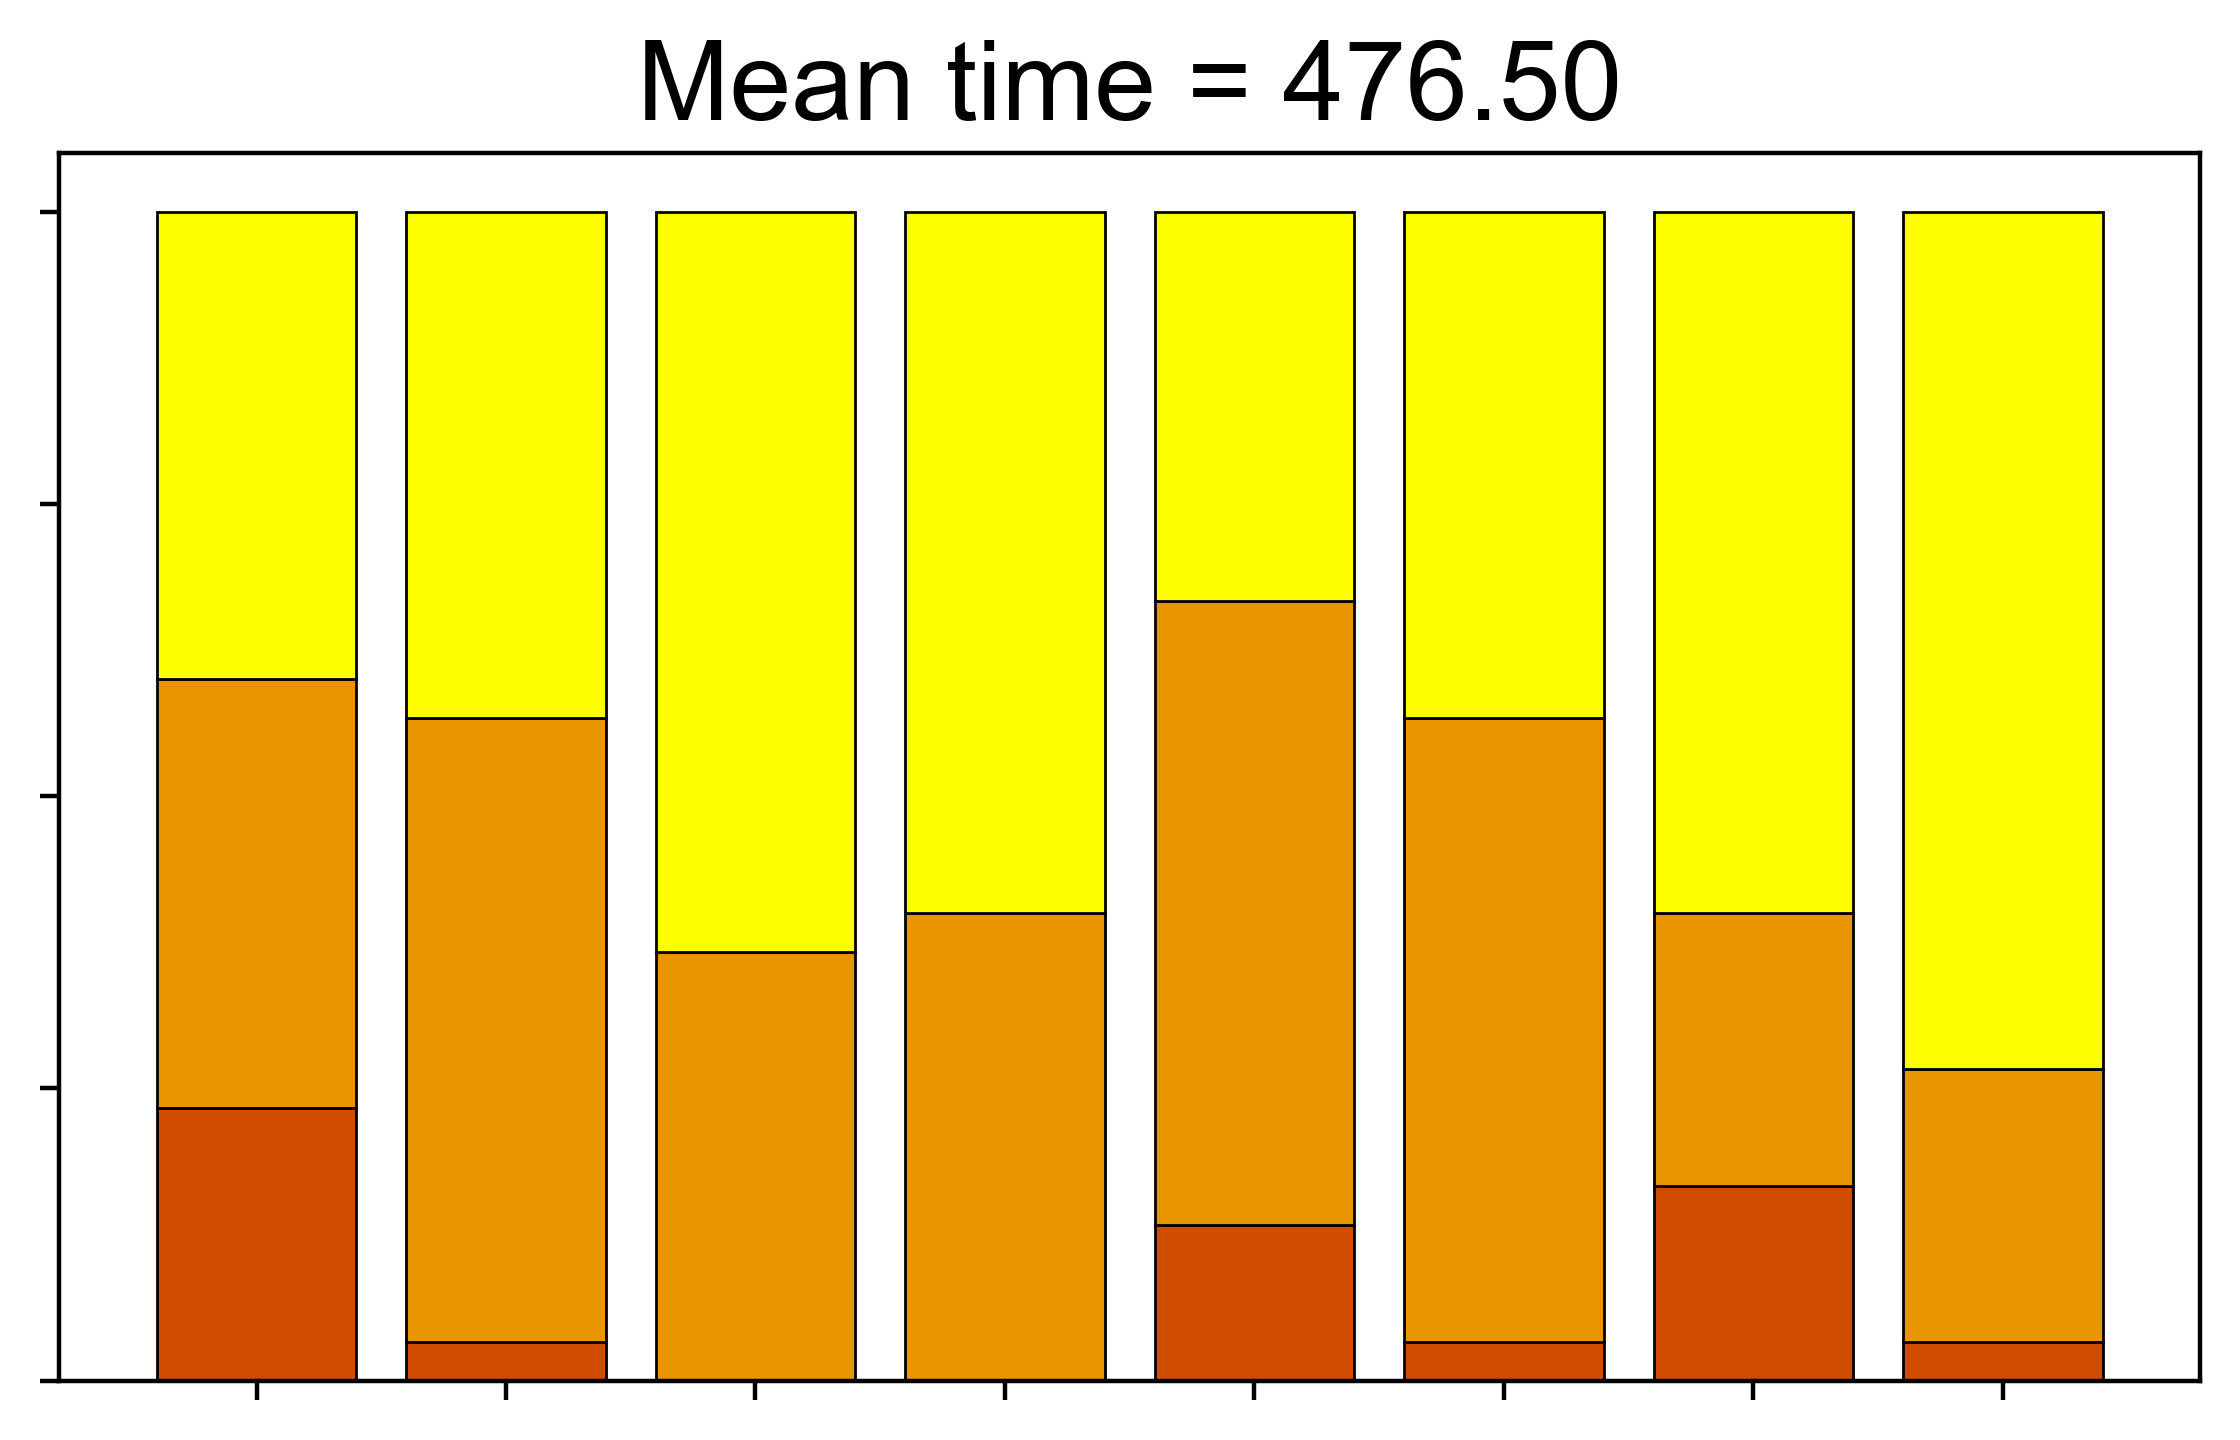

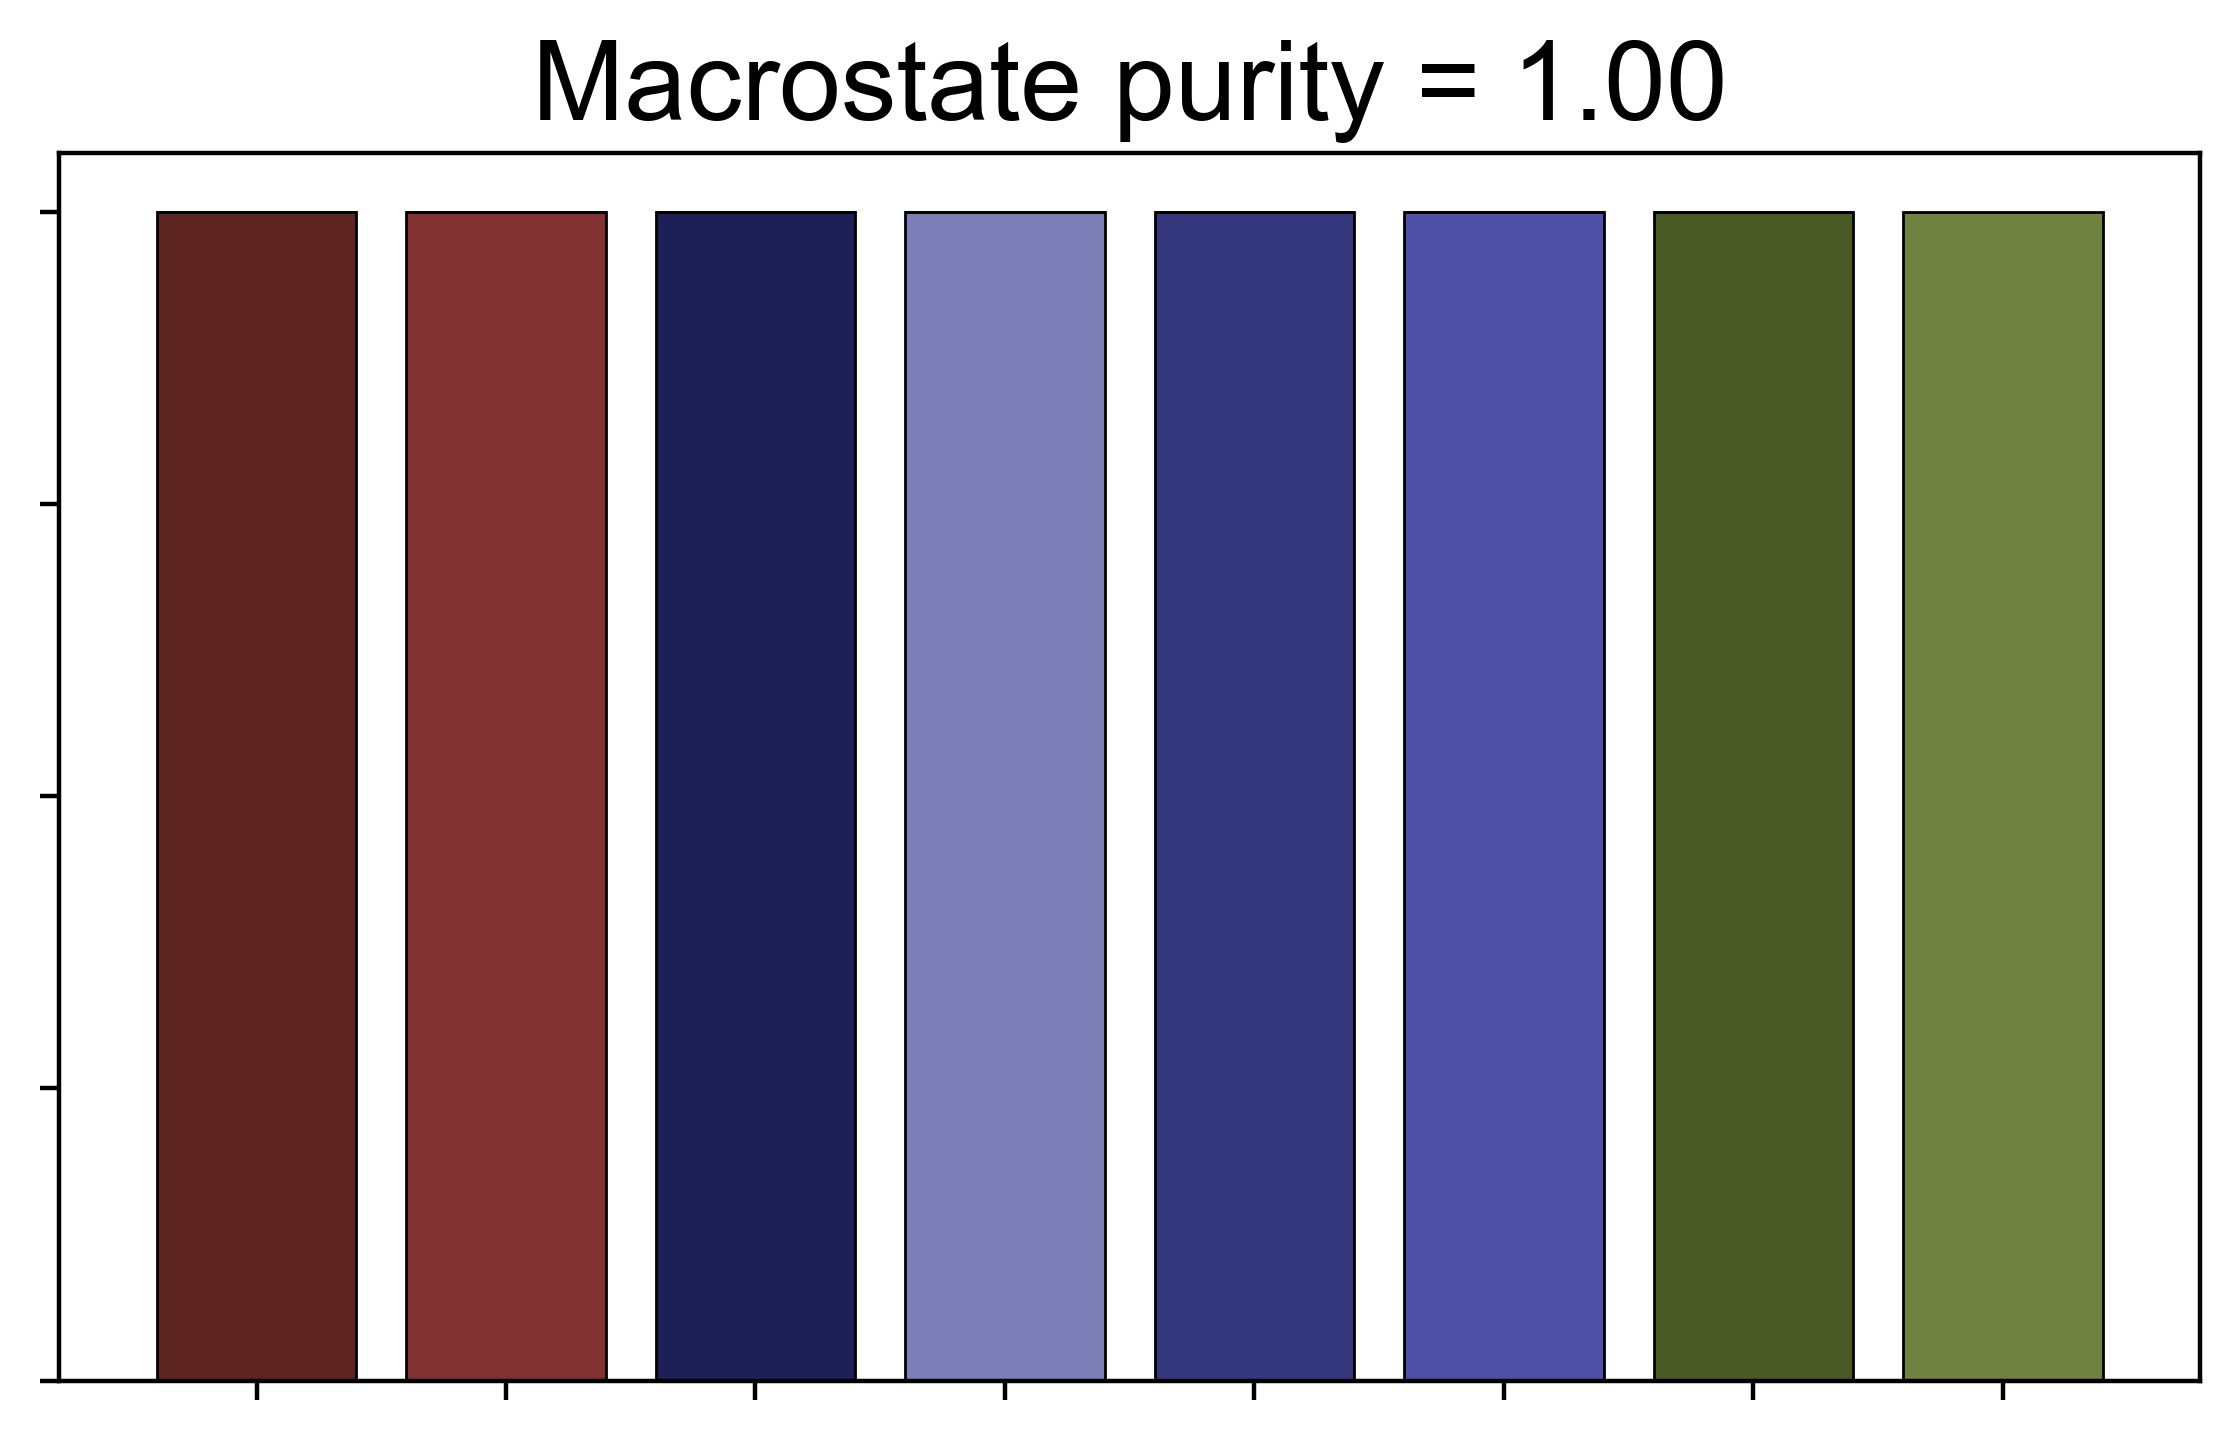

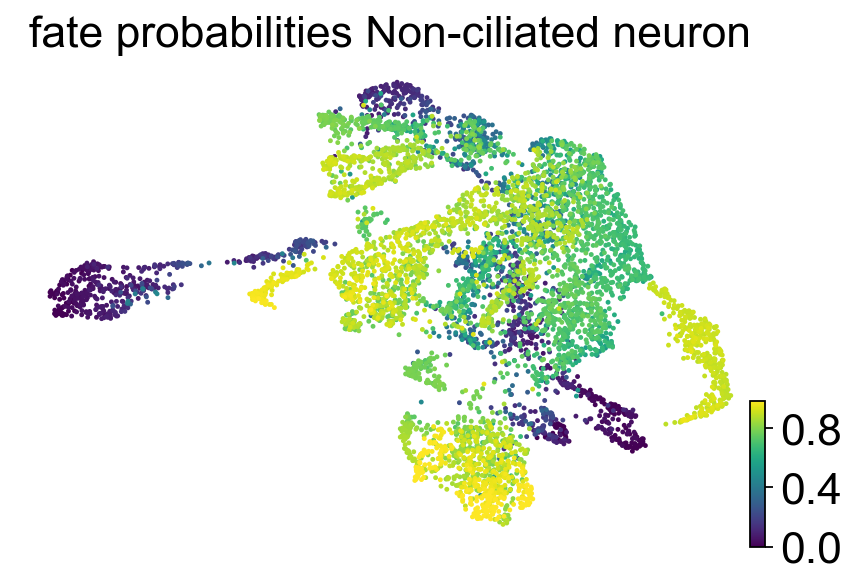

saving figure to file /Users/mlange/Projects/moslin_analysis_3/figures/packer_c_elegans/terminal_state_robustness/macrostates_n_states_10.pdf


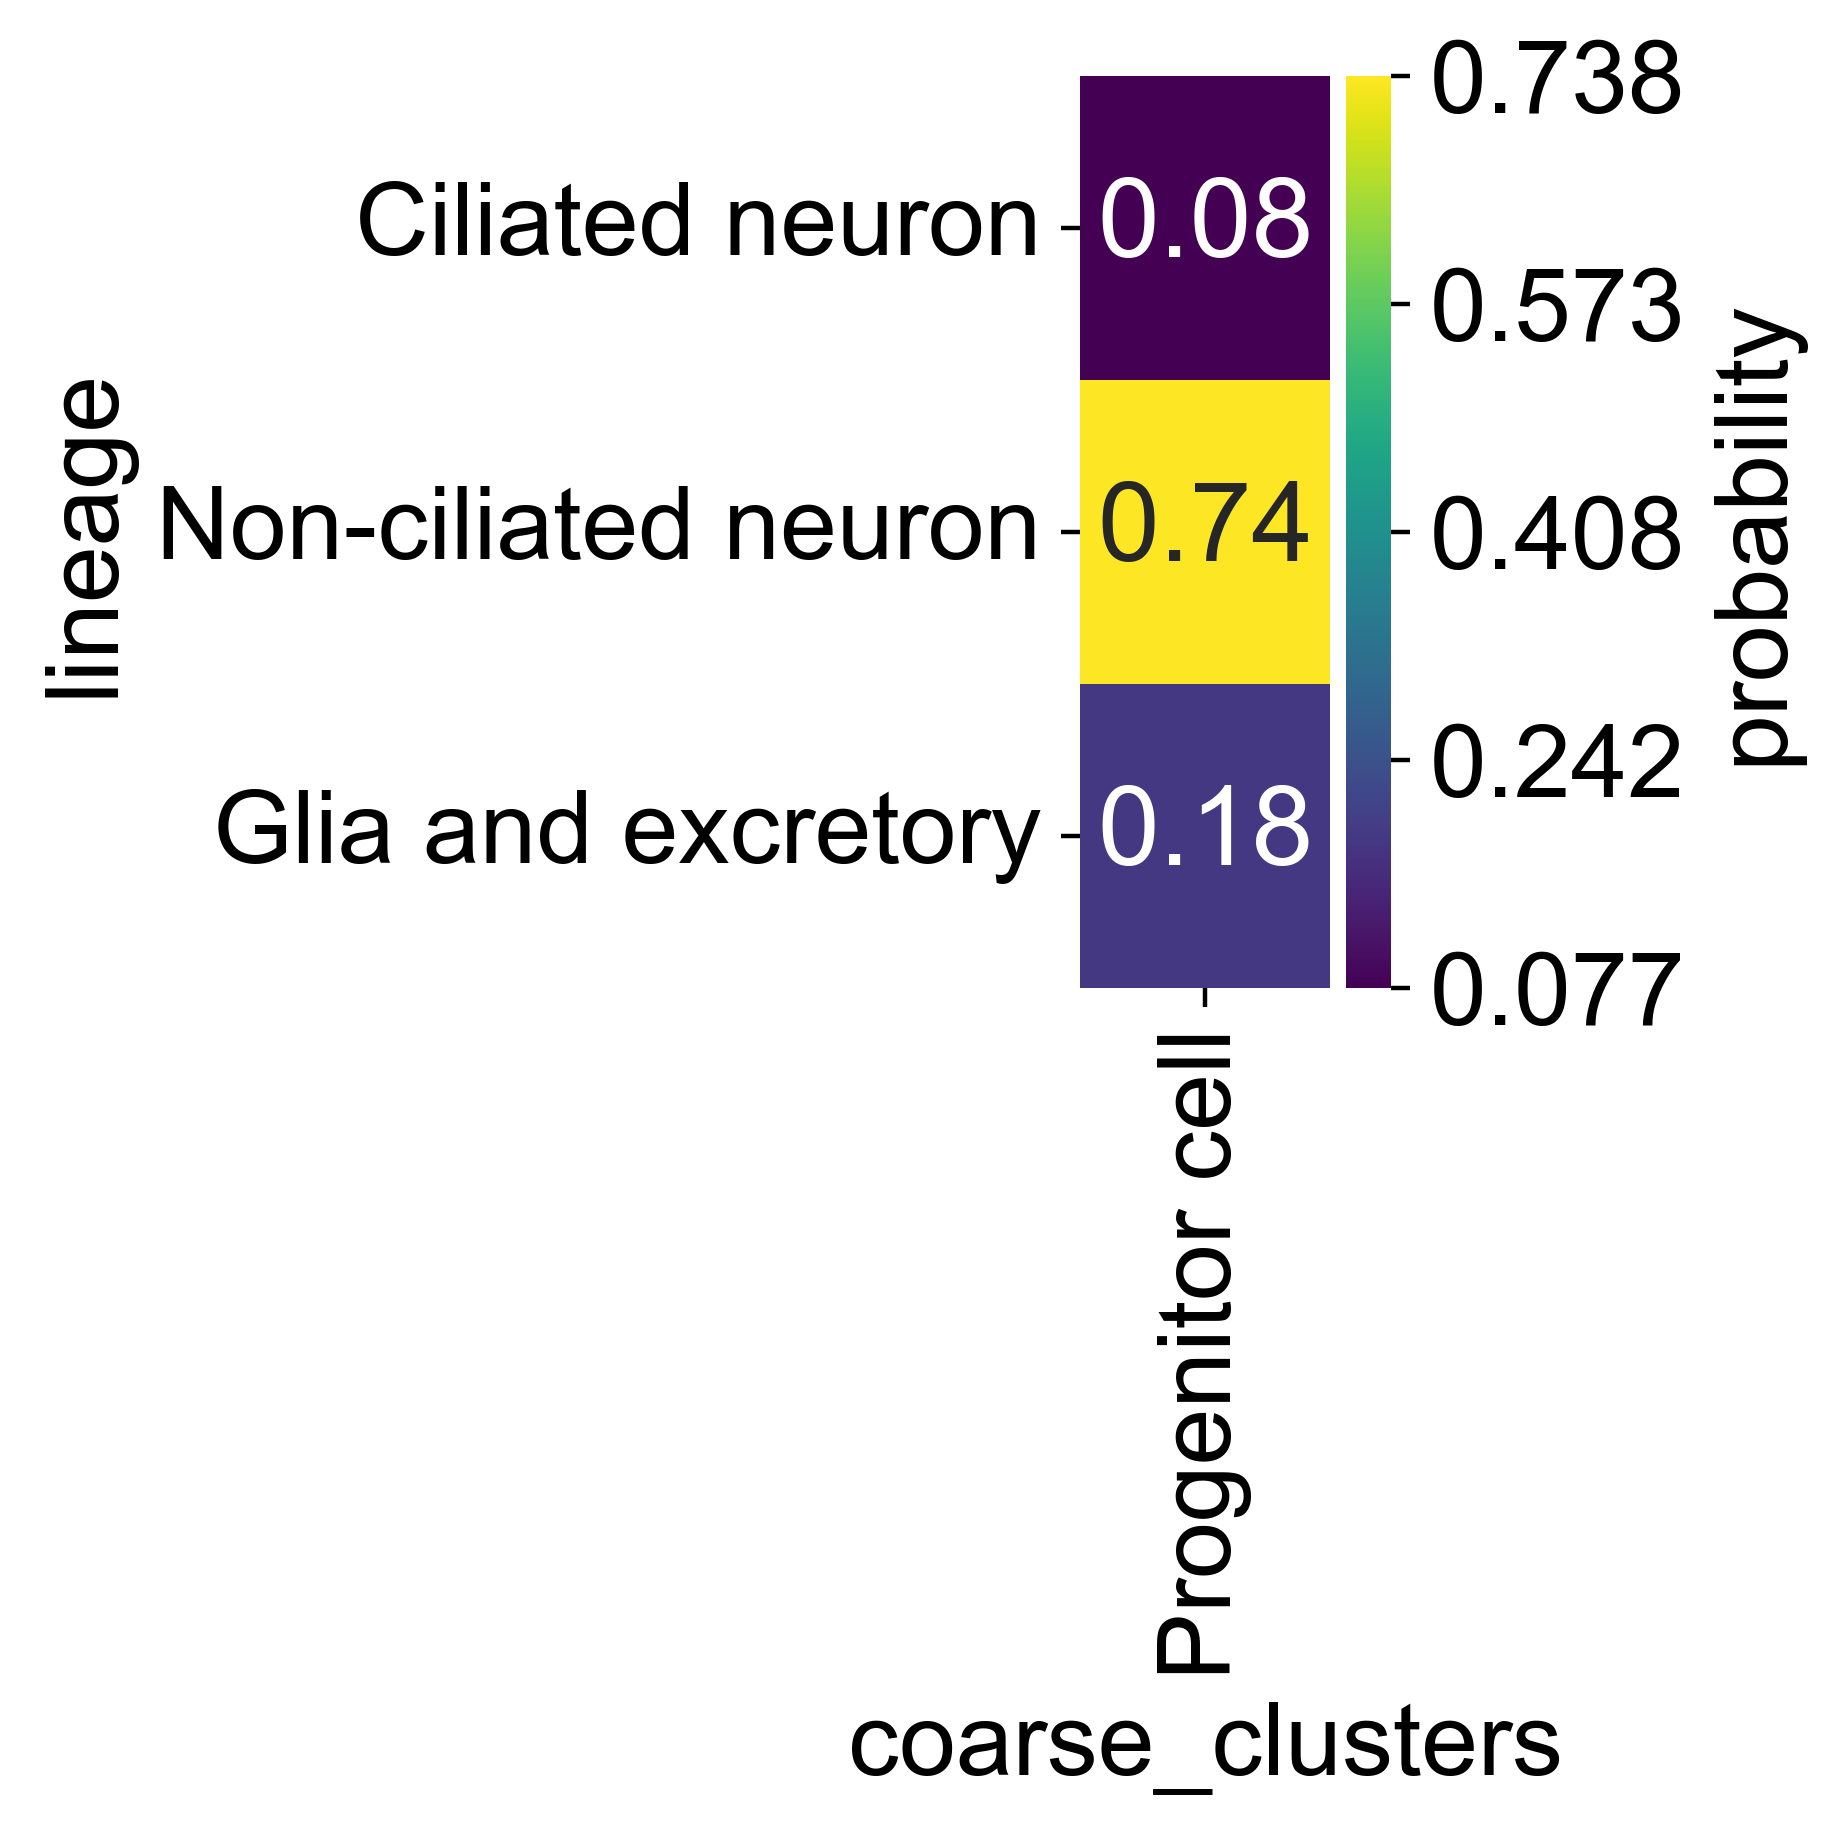

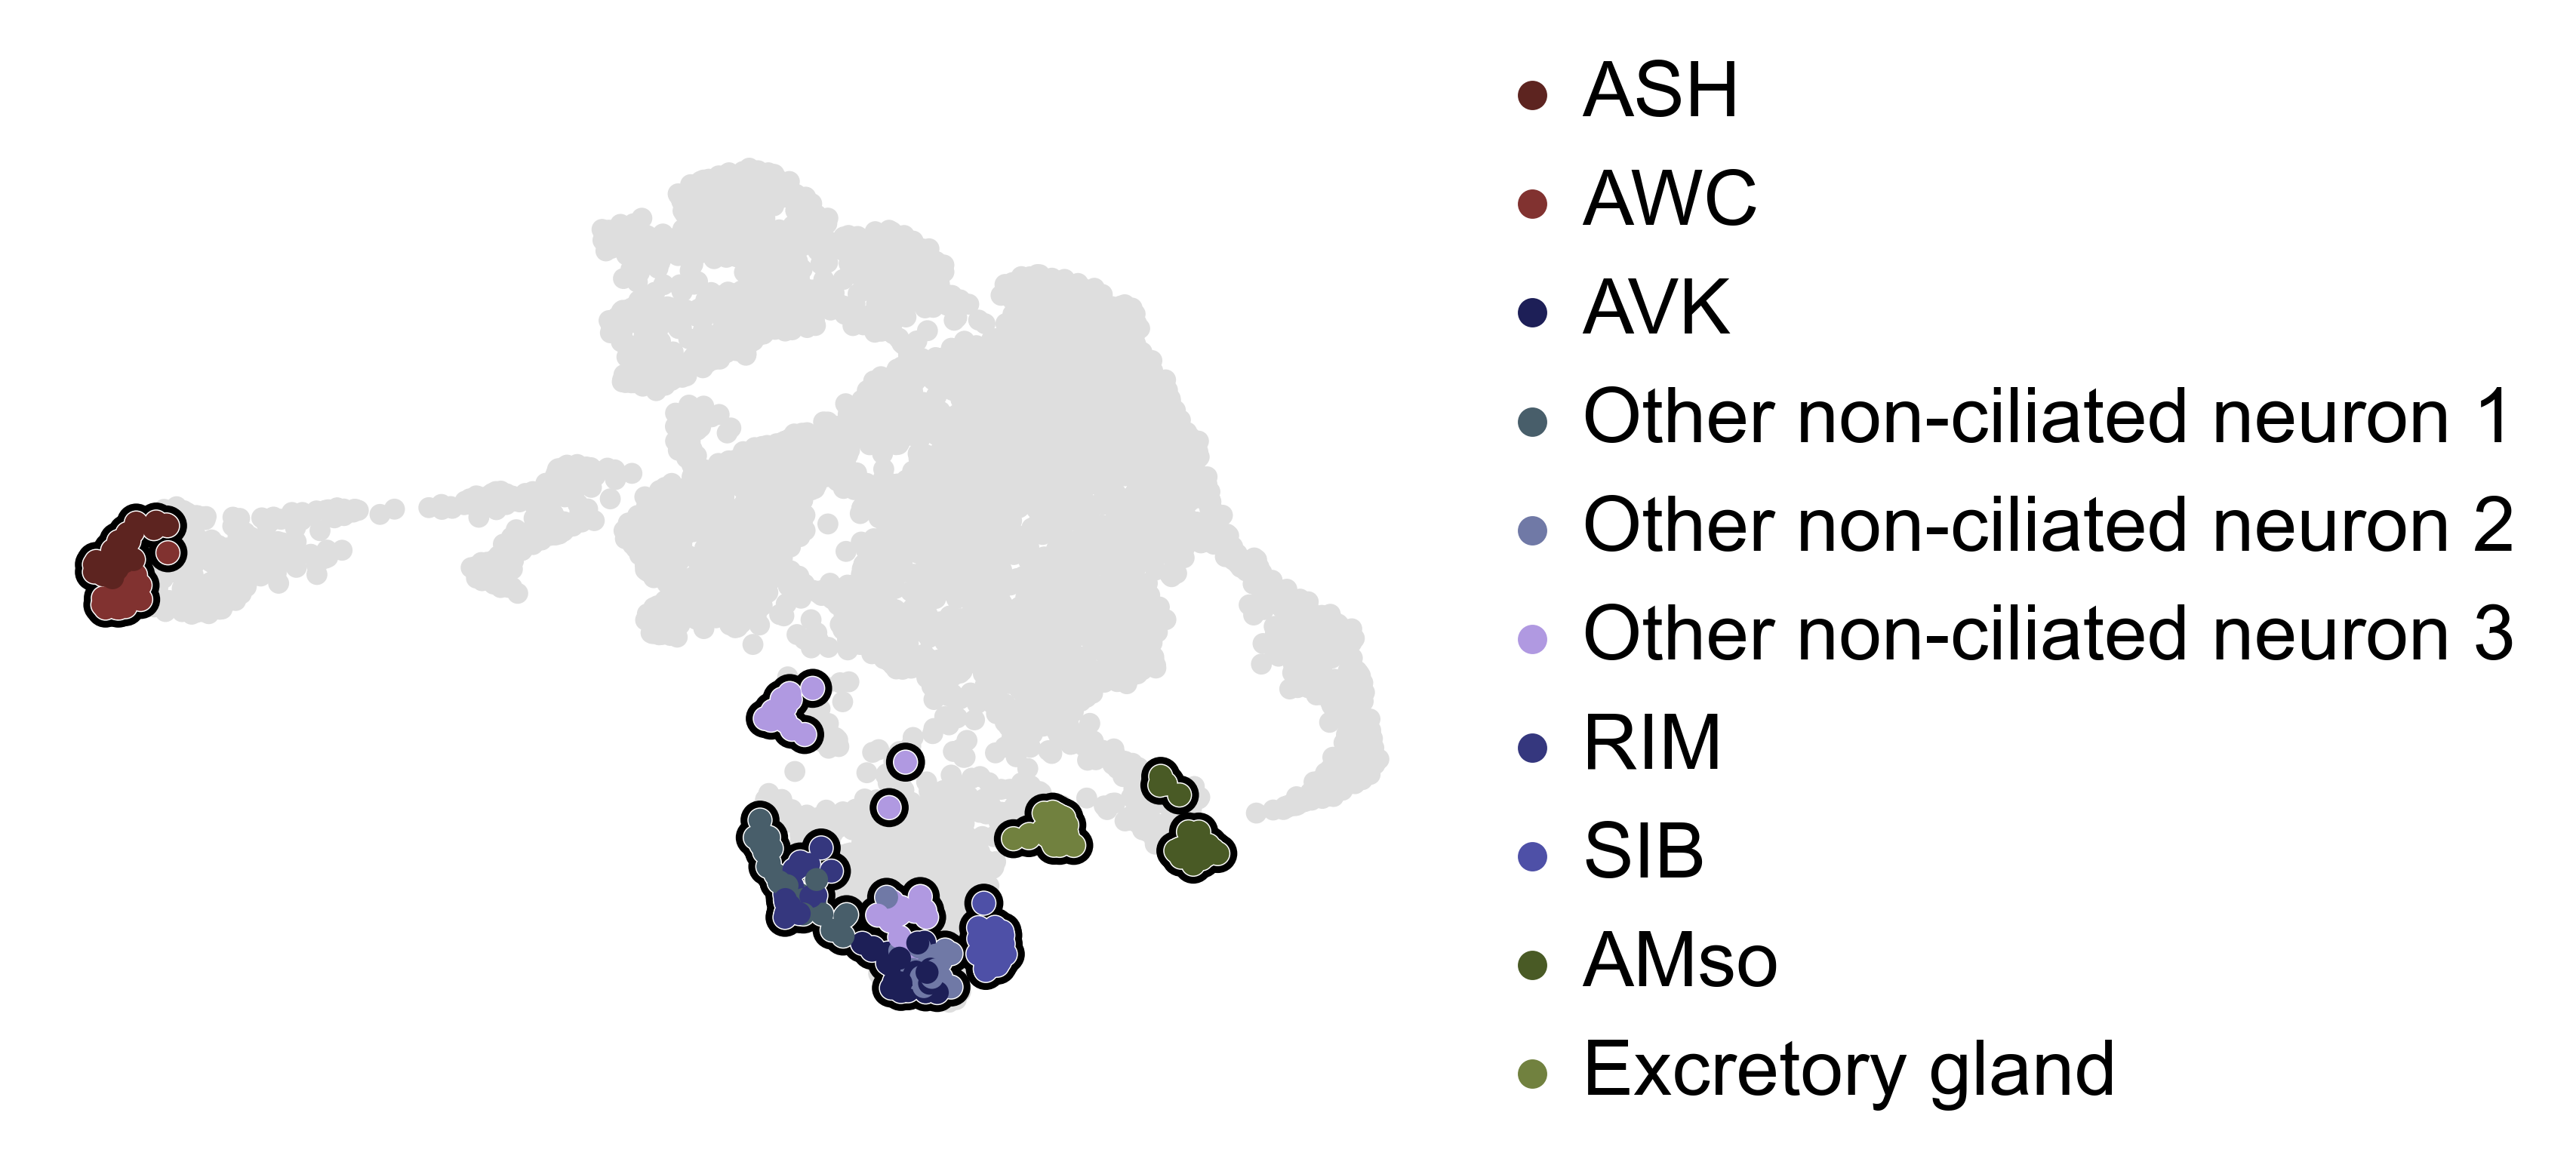

100%|██████████| 3/3 [00:01<00:00,  1.88/s]


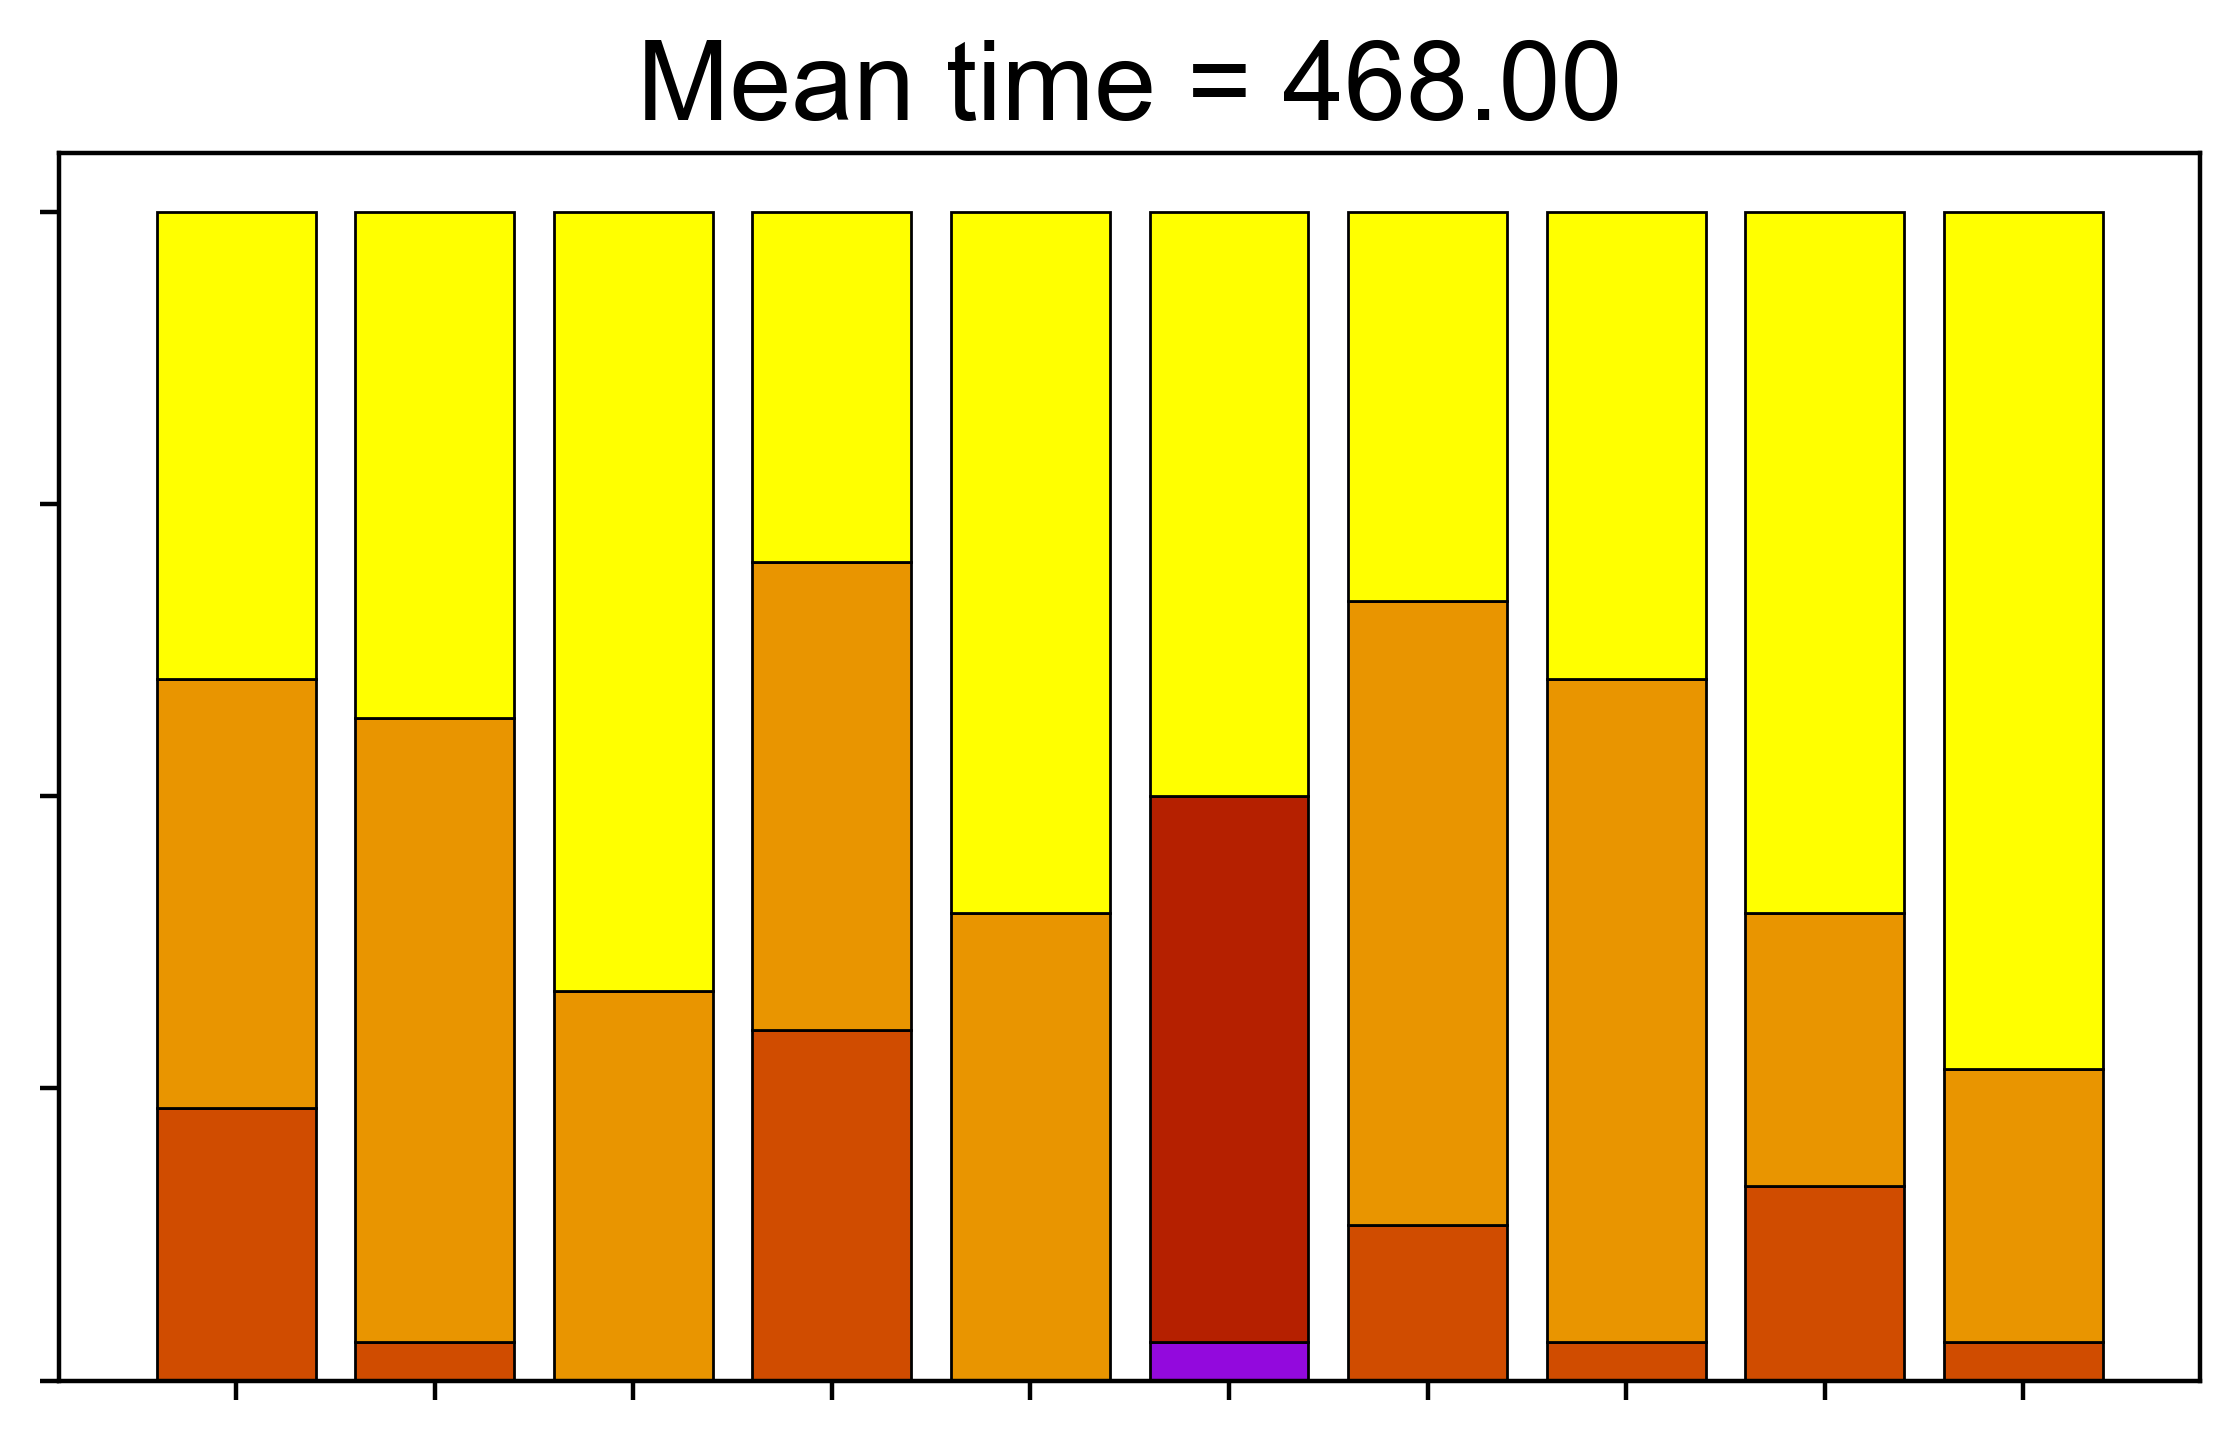

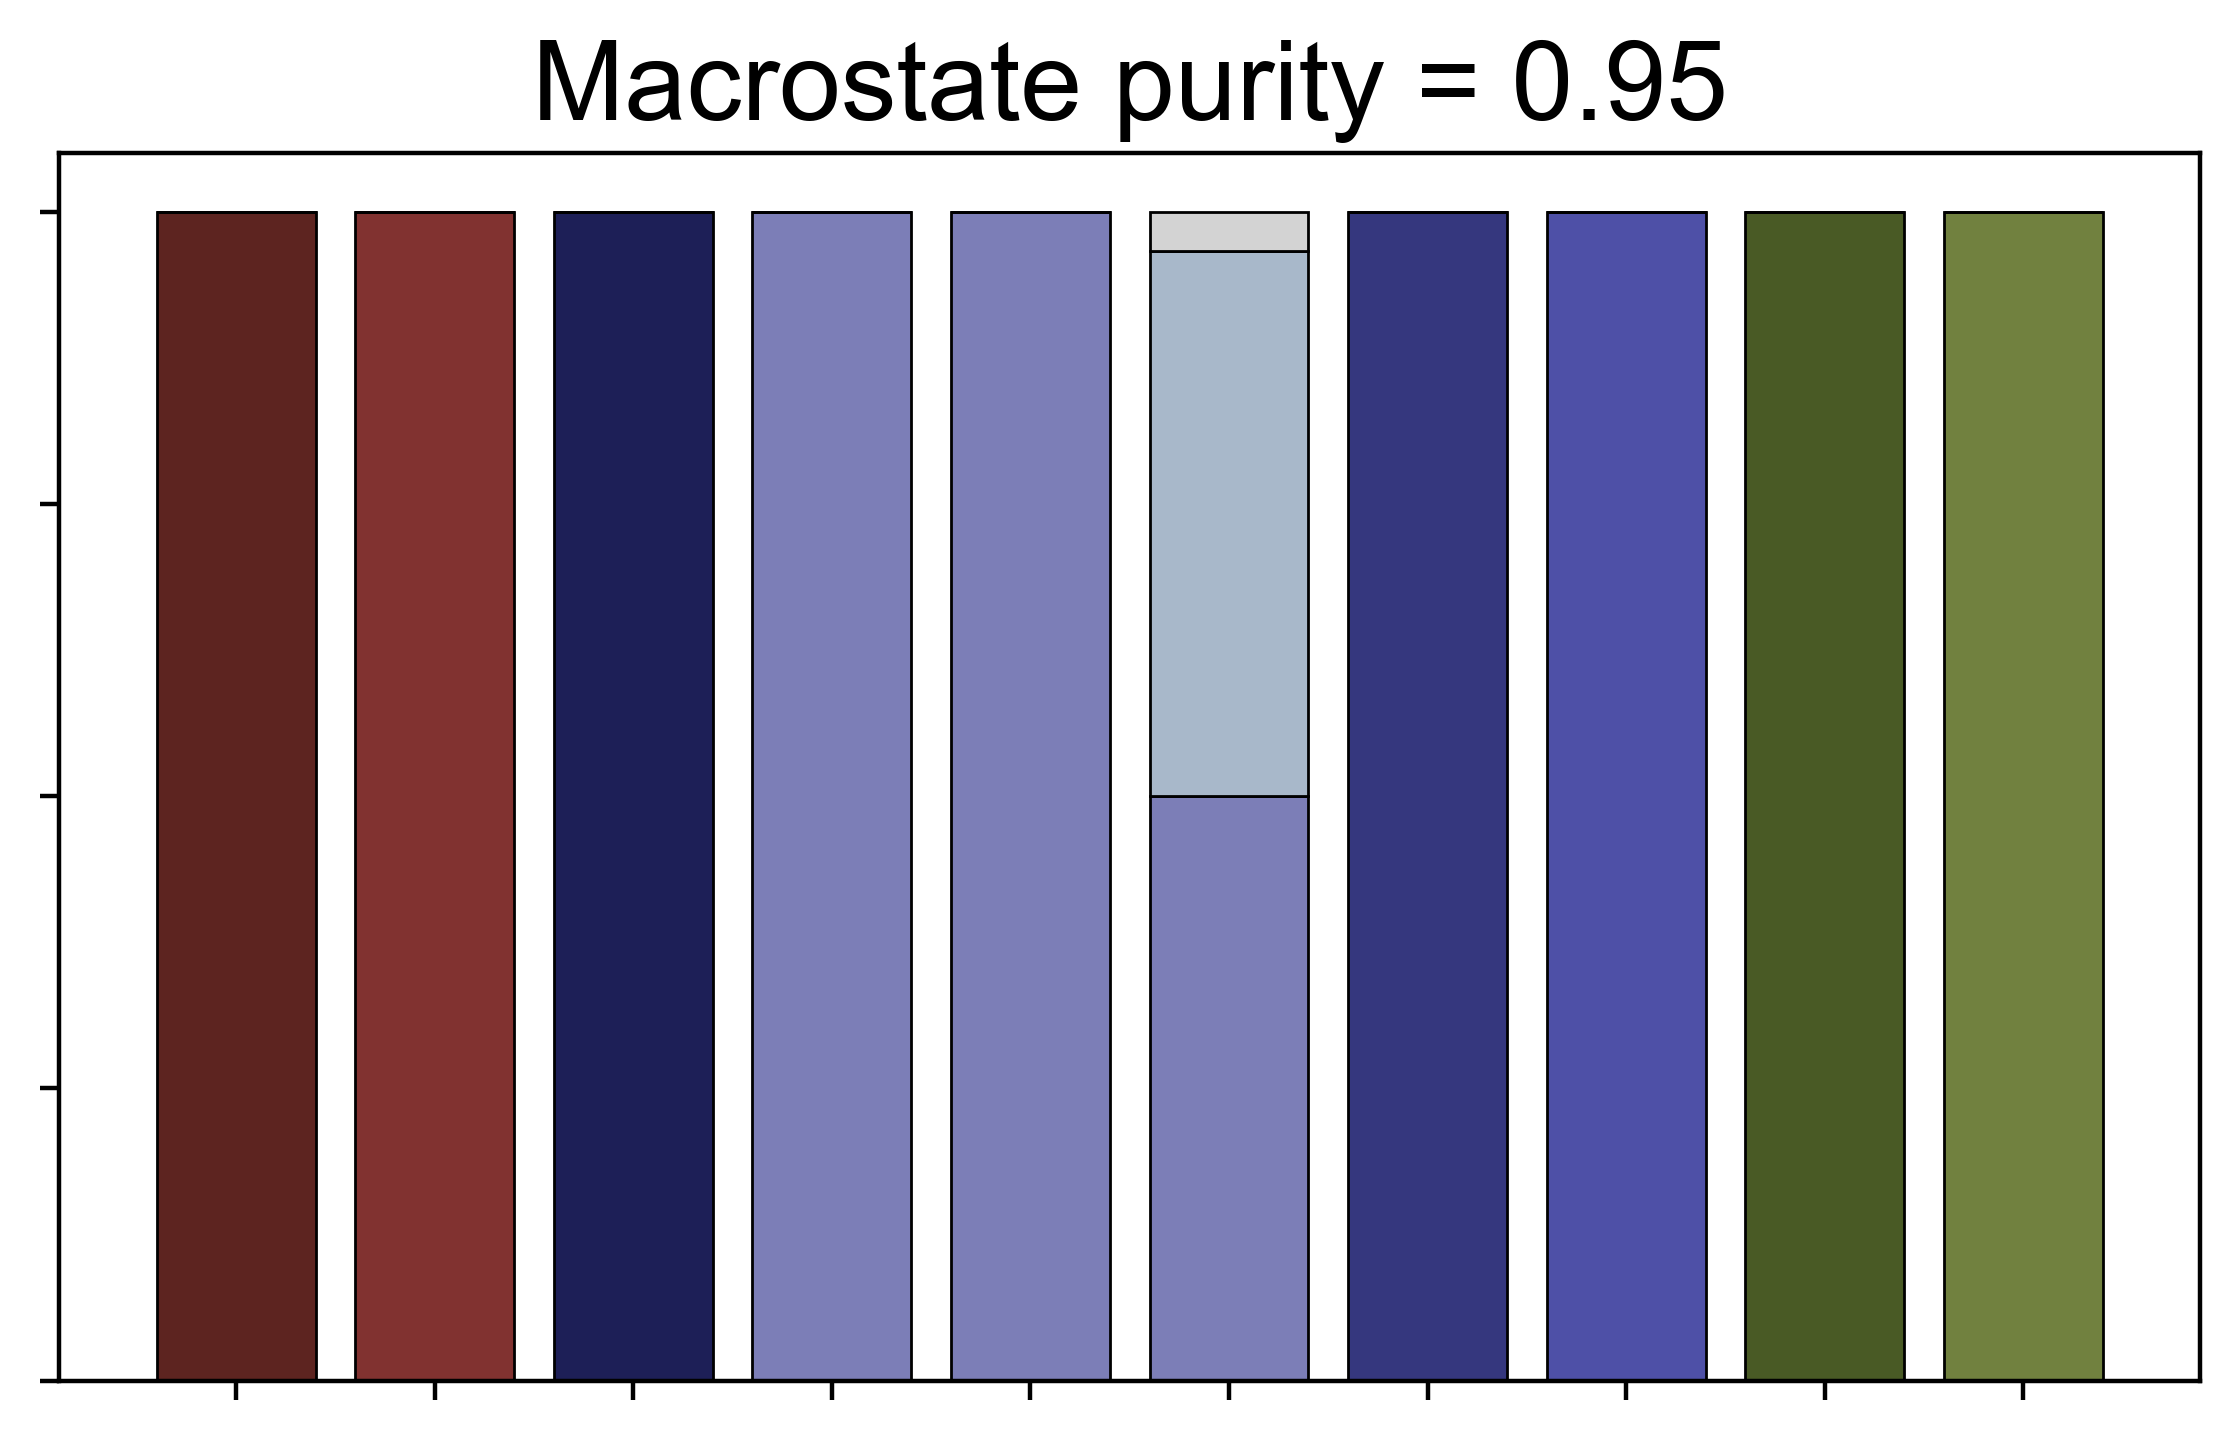

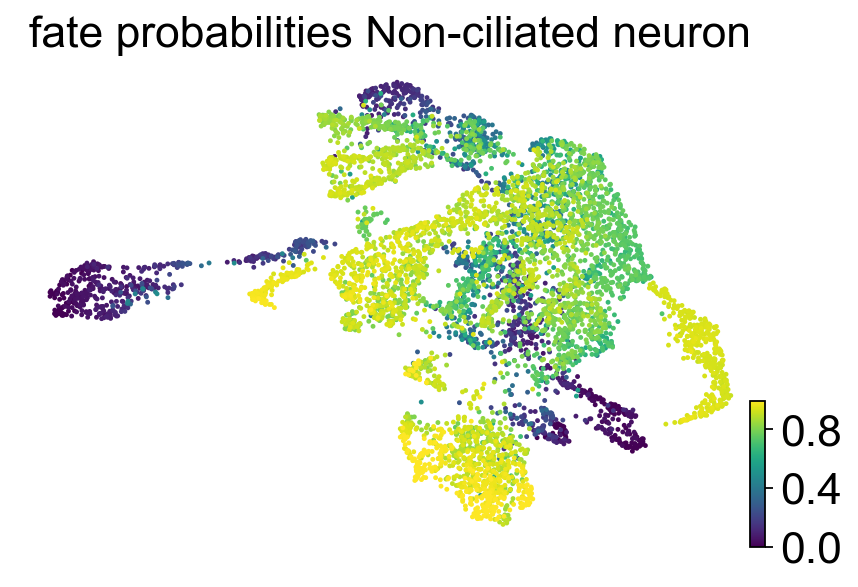

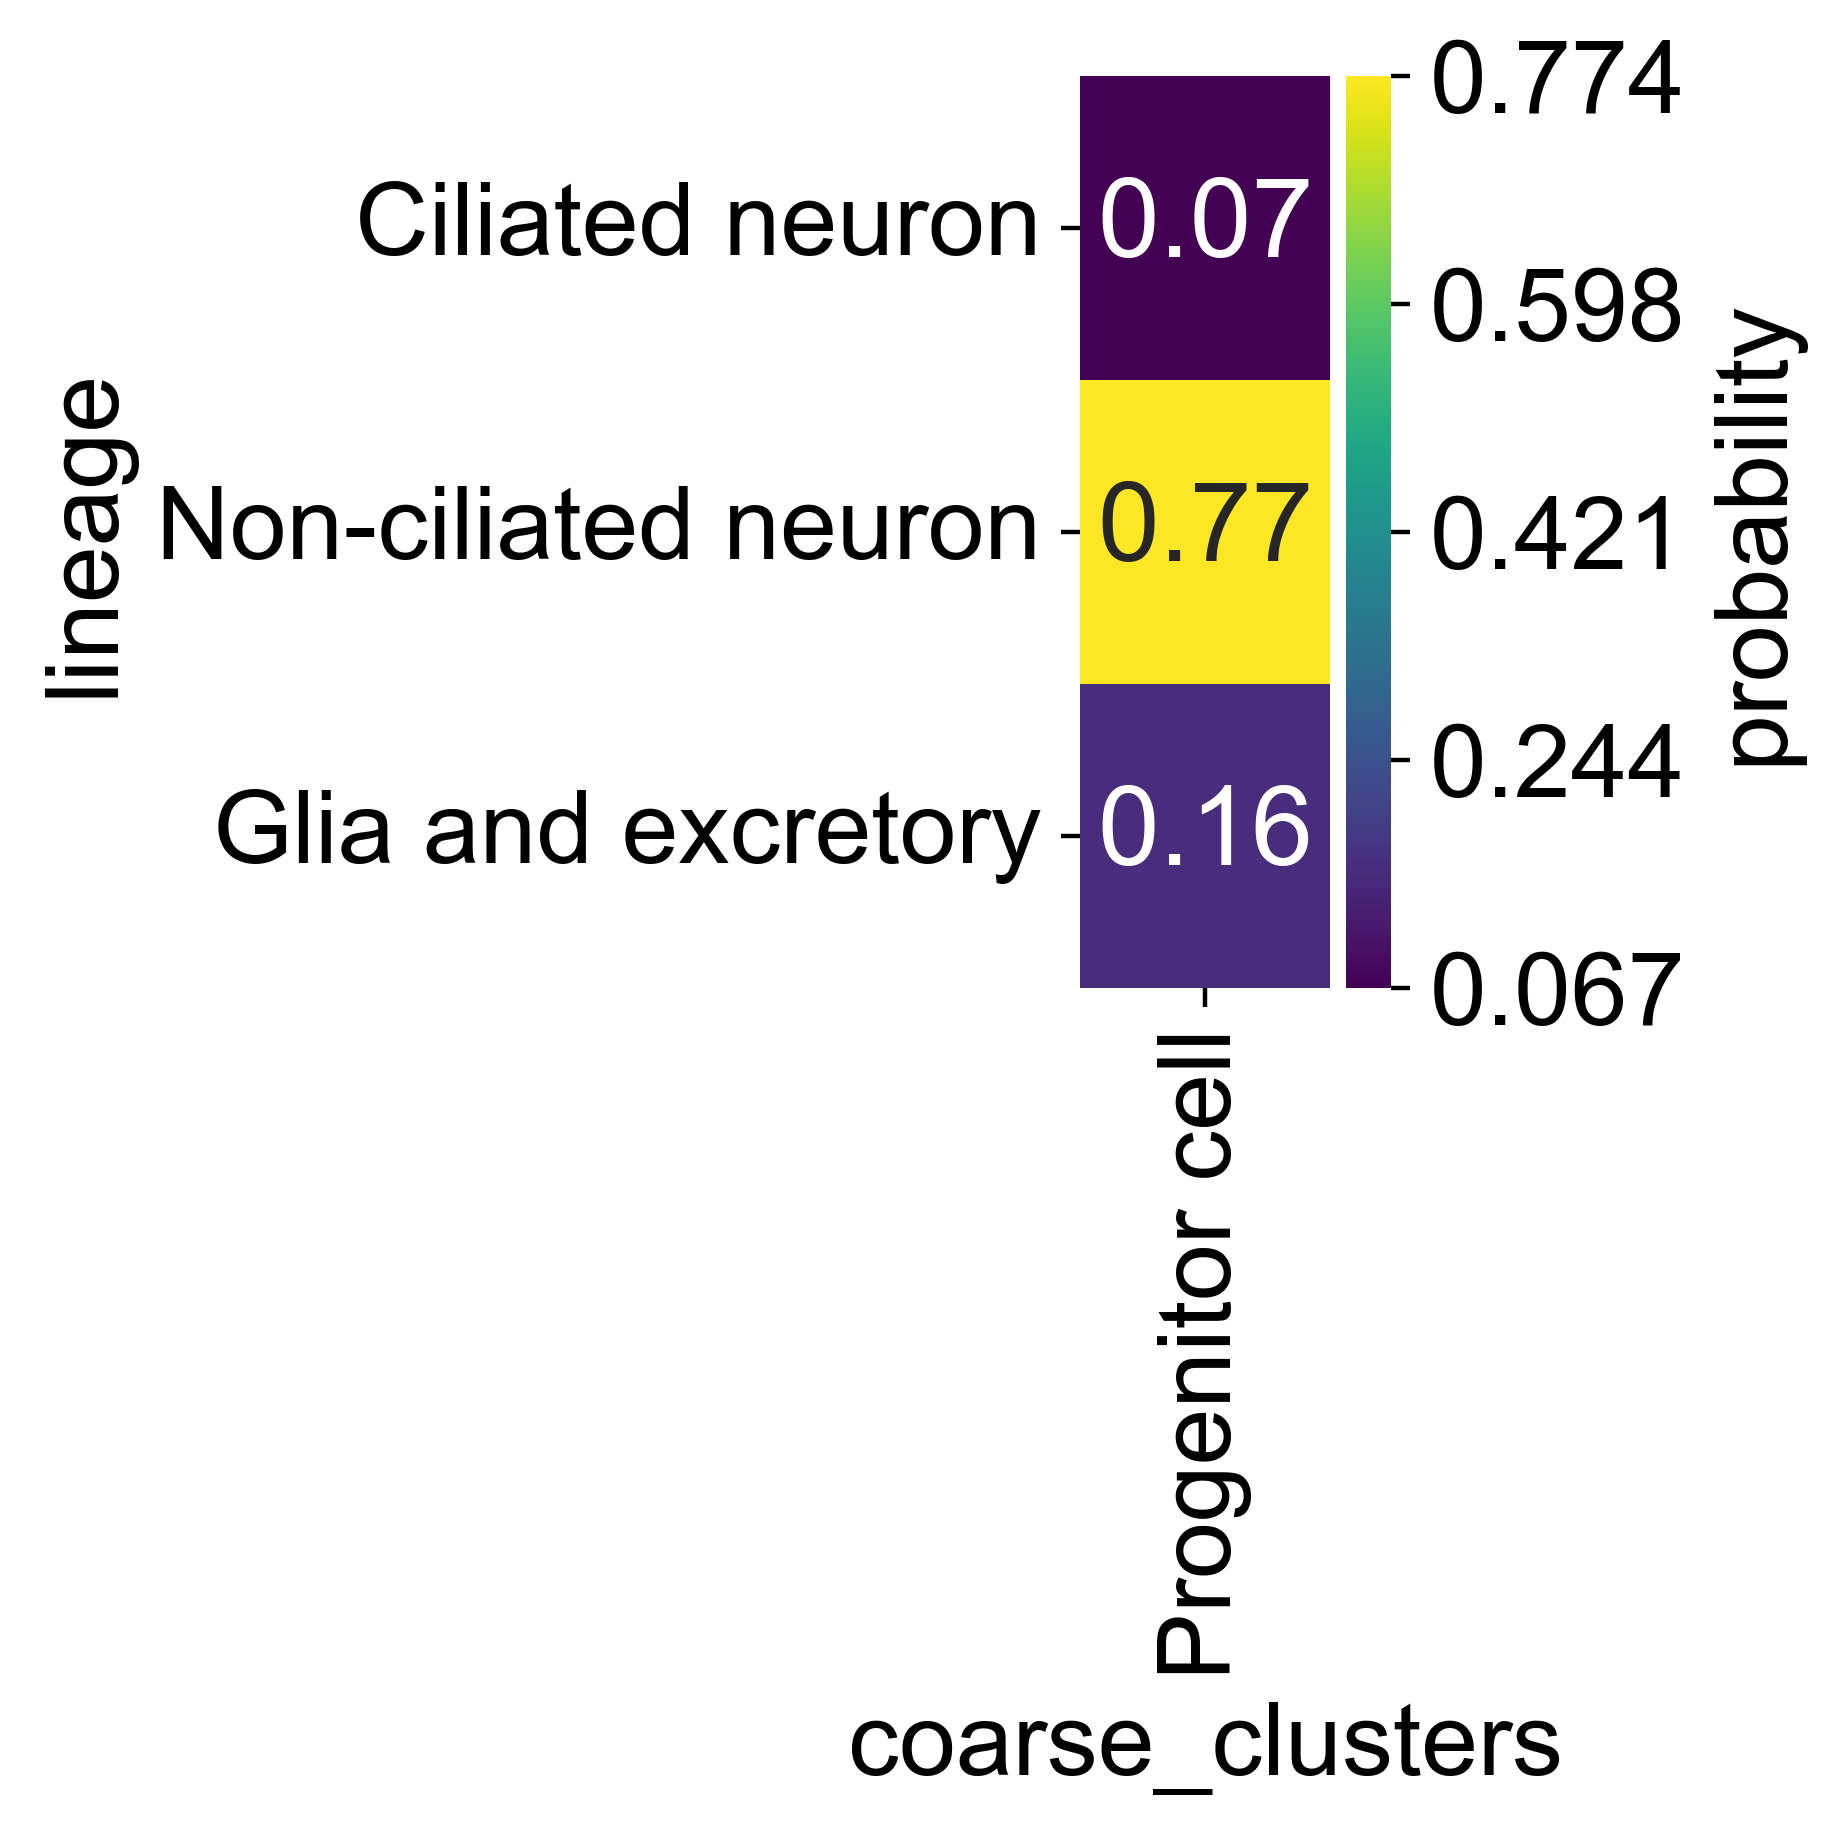

In [23]:
fate_probabilities = {}

for n_states in [5, 6, 7, 8, 10]:
    # compute and plot macrostates
    g.compute_macrostates(n_states=n_states, cluster_key="clusters")
    g, g_coarse = mu.ul.sort_and_aggregate_macrostates(adata, g)
    g.plot_macrostates(
        legend_loc="right", s=100, which="all", save=f"macrostates_n_states_{n_states}", title="", dpi=DPI_SAVE
    )

    # compute and plot the mean macrostate time
    macrostate_time = mu.ul.get_state_time(adata, g, states="macrostates", obs_col="time_point")
    ax = g.plot_macrostate_composition(
        key="time_point",
        figsize=(6, 4),
        labelrot=45,
        legend_loc=None,
        title=f"Mean time = {np.mean(list(macrostate_time.values())):.2f}",
        save=f"macrostate_time_n_states_{n_states}",
        show=False,
        dpi=DPI_SAVE,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # compute and plot macrostate purity
    macrostate_purity = mu.ul.get_state_purity(adata, g, states="macrostates", obs_col="clusters")
    ax = g.plot_macrostate_composition(
        key="clusters",
        figsize=(6, 4),
        labelrot=45,
        legend_loc=None,
        title=f"Macrostate purity = {np.mean(list(macrostate_purity.values())):.2f}",
        save=f"macrostate_purity_n_states_{n_states}",
        show=False,
        dpi=DPI_SAVE,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # compute fate probabilities and plot in heatmap
    g_coarse.compute_fate_probabilities()

    g_coarse.plot_fate_probabilities(states=["Non-ciliated neuron"], same_plot=False)

    cr.pl.aggregate_fate_probabilities(
        adata,
        cluster_key="coarse_clusters",
        mode="heatmap",
        clusters=["Progenitor cell"],
        figsize=(1, 3),
        save=f"fate_probabilites_n_states_{n_states}",
        title="",
        dpi=DPI_SAVE,
    )

    fate_probabilities[n_states] = g_coarse.fate_probabilities.copy()

### Visualize fate probability correlation. 

Compute pairwise correlations within each coarse terminal state

In [105]:
# Prepare data
correlation_matrices = {}
terminal_states_names = list(g_coarse.terminal_states.cat.categories)
macrostate_range = list(fate_probabilities.keys())

# Reshape fate probabilities
fate_probabilities_by_endpoint = {state: [] for state in terminal_states_names}
for n_macrossates, probabilities in fate_probabilities.items():
    for state in terminal_states_names:
        fate_probabilities_by_endpoint[state].append(probabilities[state].X.flatten())

# Calculate correlation matrices
for endpoint, probs_list in fate_probabilities_by_endpoint.items():
    correlation_matrix = np.corrcoef(probs_list)
    correlation_matrices[endpoint] = correlation_matrix

Visualize with heatmaps

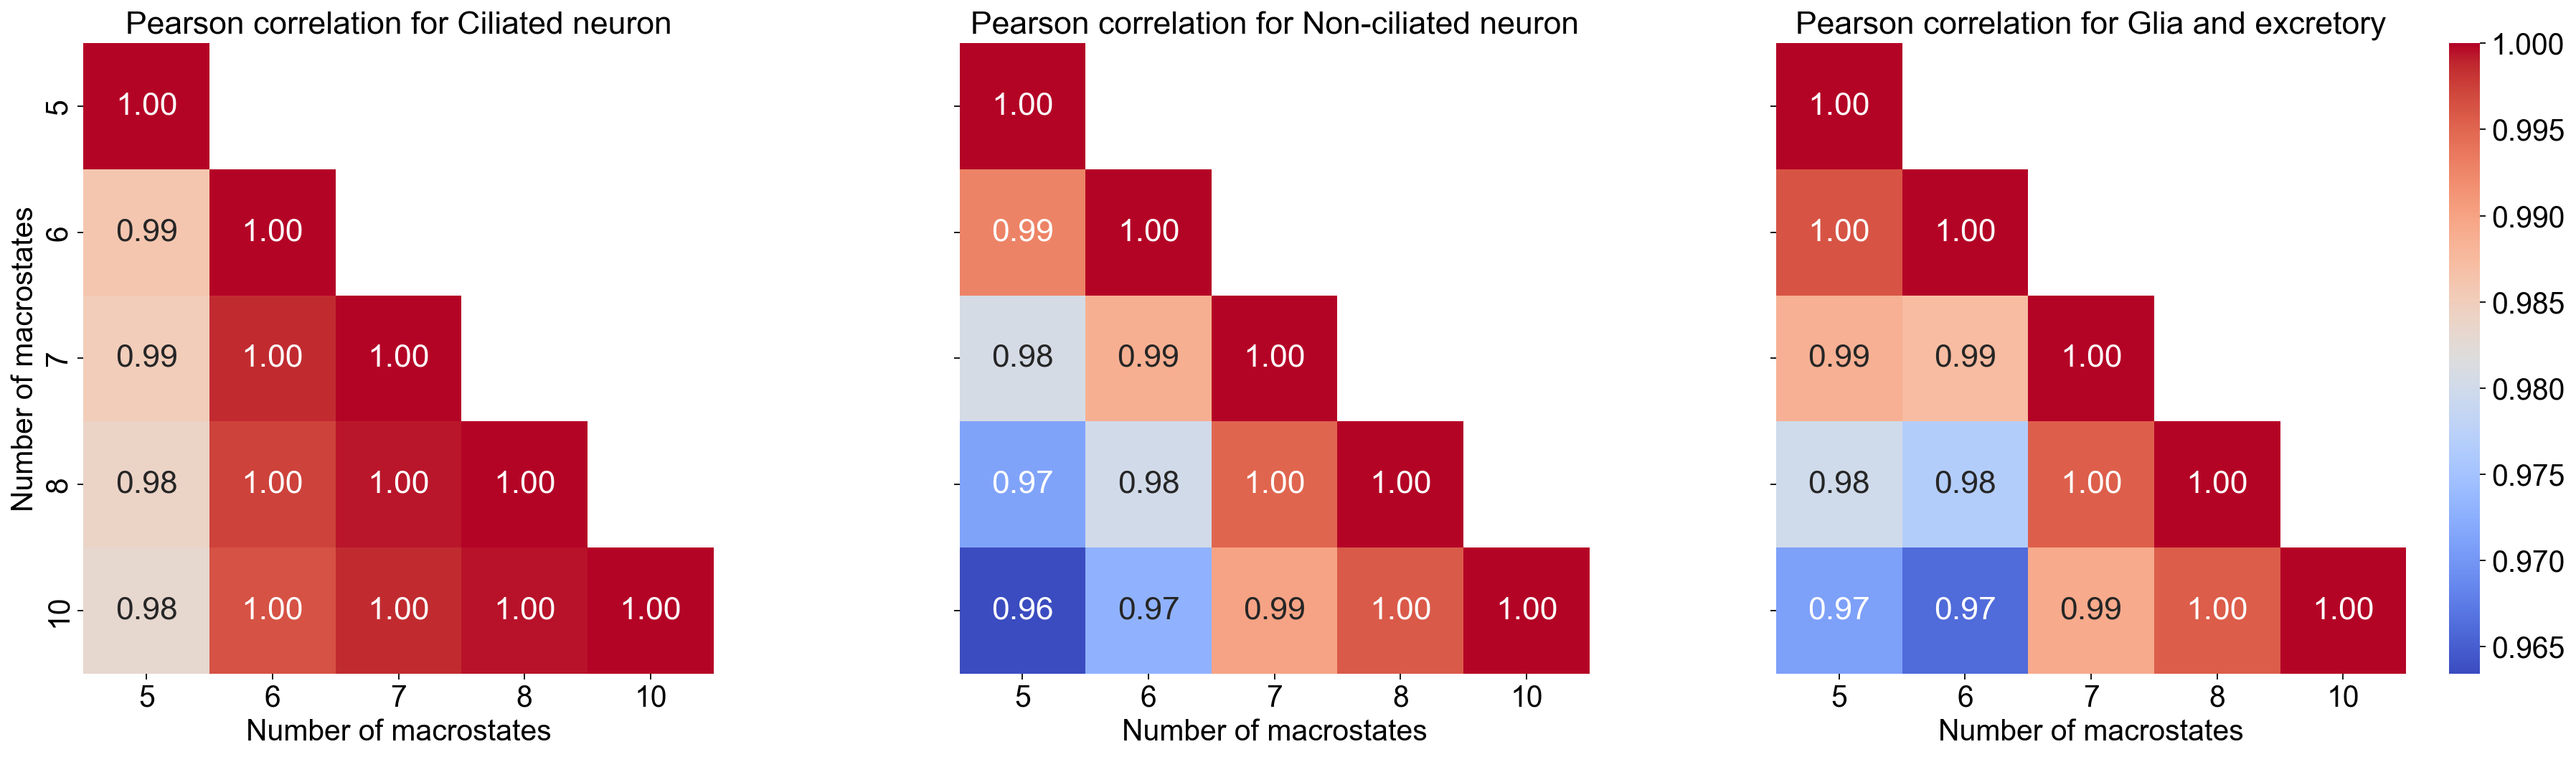

In [106]:
# Create a figure with a row of three subplots
fig, axes = plt.subplots(1, len(correlation_matrices), figsize=(24, 7), sharey=True)

# Track the min and max values for the color bar scale
vmin = min(matrix.min() for matrix in correlation_matrices.values())
vmax = max(matrix.max() for matrix in correlation_matrices.values())

for i, (endpoint, matrix) in enumerate(correlation_matrices.items()):
    # Only show the lower triangular part of the heatmap
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)

    # Plot heatmap with shared color bar
    sns.heatmap(
        matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        xticklabels=macrostate_range,
        yticklabels=macrostate_range,
        mask=mask,
        ax=axes[i],
        cbar=i == len(correlation_matrices) - 1,
        vmin=vmin,
        vmax=vmax,
        square=True,
    )

    axes[i].set_title(f"Pearson correlation for {endpoint}")
    axes[i].set_xlabel("Number of macrostates")
    if i == 0:
        axes[i].set_ylabel("Number of macrostates")

plt.tight_layout()
plt.savefig(FIG_DIR / "fate_probabilities_correlation_matrices.png", dpi=DPI_SAVE)

plt.show()